<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Entrenamiento de redes *Feed-Forward* vı́a GD y variantes (SGD, mini-*batches*), *momentum*, regularización y tasa de aprendizaje adaptiva.
* Evaluación de redes *Feed-Forward* vı́a validación cruzada (cross-validation).
* Rol de capas ocultas y mayor profundidad (*Deep Learning*).
* Identificar el gradiente desvaneciente.
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: 26 de Octubre.
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<margarita.bugueno.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<cvalle@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea1-INF395-II-2018]

<hr style="height:2px;border:none"/>

#### Paquetes instalación

Para poder trabajar en el curso se necesitará instalar librerías para Python, por lo que se recomienda instalarlas a través de anaconda (para Windows y sistemas Unix) en un entorno virtual, donde podrán elegir su versión de Python. Se instalarán librerías como sklearn, una librería simple y de facil acceso para data science, keras en su versión con GPU (para cálculo acelerado a través de la tarjeta gráfica), además de que ésta utiliza como backend TensorFlow o Theano, por lo que habrá que instalar alguno de éstos, además de las librerías básicas de computer science como *numpy, matplotlib, pandas,* además de claramente *jupyter*.

* Descargar anacona
* Luego de instalar Anaconda y tenerla en el path de su computador crear un entorno virtual:
```
conda create -n redesneuronales python=version
```
con version, la version de Python que desea utilizar. Si está en Windows, se recomienda Python 3 debido a dependencias con una de las librerías a utilziar.

* Acceder al ambiente creado
```
source activate redesneuronales
```

* Instalar los paquetes a utilizar
```
conda install jupyter sklearn numpy pandas matplotlib keras-gpu tensorflow-gpu
```

*  Para salir del entorno
```
source deactivate redesneuronales
```

<hr style="height:2px;border:none"/>
La tarea se divide en secciones:

[1.](#primero) Predicción de Entalpía de Atomización  
[2.](#segundo) *Deep Networks*  
[3.](#tercero) Entendimiento de imágenes de personas

<a id="primero"></a>
## 1. Predicción de Entalpía de Atomización


Las simulaciones de propiedades moleculares son computacionalmente costosas y requieren de un arduo trabajo científico. El objetivo de esta sección corresponde a la utilización de métodos de aprendizaje automático supervisado (Redes Neuronales Artificiales) para predecir propiedades moleculares, en este caso la Energía de Atomización o Entalpía de Atomización, a partir de una base de datos de simulaciones obtenida mediante __[Quantum Espresso](http://www.quantum-espresso.org/)__. Si esto se lograse hacer con gran precisión, se abrirían muchas posibilidades en el diseño computacional y el descubrimiento de nuevas moléculas, compuestos y fármacos.

<img src="https://pubs.rsc.org/services/images/RSCpubs.ePlatform.Service.FreeContent.ImageService.svc/ImageService/Articleimage/2012/NR/c2nr11543c/c2nr11543c-f4.gif" title="Title text" width="40%"/>


La **entalpía de atomización** es la cantidad de variación de entalpía cuando los enlaces de un compuesto se rompen y los componentes se reducen a átomos individuales. Tal como se ha indicado, su tarea es la de predecir dicho nivel a partir de los atributos enunciados en el dataset puesto a vuestra disposición en *moodle*.

> a) Construya un *dataframe* con los datos a analizar y descríbalo brevemete. Además, realice la división de éste en los conjuntos de entrenamiento, validación y testeo correspondientes. Comente por qué se deben eliminar ciertas columnas.
```python
import pandas as pd
datos= pd.read_csv("EnergyMolecule/roboBohr.csv")
datos.shape
datos.info()
datos.describe()
...
datos.drop(columns=['Unnamed: 0','pubchem_id'],axis=1,inplace=True)
total=len(datos)
df_train=datos[:int(0.6*total)]                       #60% de los datos
df_val=datos[int(0.6*total):int(0.85*total)]          #25% de los datos
df_test=datos[int(0.85*total)::]                      #15% restante
```
>> a.1) Una buena práctica es la de normalizar los datos antes de trabajar con el modelo. **Explique por qué se aconseja dicho preprocesamiento**
>```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
X_val_scaled =  pd.DataFrame(scaler.transform(df_val),columns=df_val.columns)
X_test_scaled =  pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)
...
y_train = df_train.pop('Eat').values.reshape(-1,1)
y_val = df_val.pop('Eat').values.reshape(-1,1)
...
X_train_scaled.drop(columns=['Eat'],axis=1,inplace=True)
X_val_scaled.drop(columns=['Eat'],axis=1,inplace=True)
X_test_scaled.drop(columns=['Eat'],axis=1,inplace=True)
```

 
>b) Muestre en un gráfico el error cuadrático (MSE) para el conjunto de entrenamiento y de pruebas vs número de *epochs* de entrenamiento, para una red *feedforward* de 3 capas, con 256 unidades ocultas y función de activación sigmoidal. Entrene la red usando gradiente descendente estocástico con tasa de aprendizaje (learning rate) 0.01 y 250 epochs de entrenamiento, en el conjunto de entrenamiento y de validación. Comente. Si observara divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento.
```python
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error')
history = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))
```
> c) Repita el paso anterior, utilizado ’**ReLU**’ como función de activación y compare con lo obtenido en b).  

> d) Repita b) y c) variando la tasa de aprendizaje (*learning rate*) en un rango sensible. Comente. Si observara divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento.
```python
import numpy as np
n_lr = 20
lear_rate = np.linspace(0,1,n_lr)
```

> e) Entrene los modelos considerados en b) y c) usando *progressive decay*. Compare y comente.
```python
n_decay = 10
lear_decay = np.logspace(-6,0,n_decay)
sgd = SGD(lr=0.2, decay=1e-6)
```

> f) Entrene los modelos considerados en b) y c) utilizando SGD en mini-*batches*. Experimente con diferentes tamaños del *batch*. Comente.
```python
n_batches = 21
batch_sizes = np.round(np.linspace(1,X_train_scaled.shape[0],n_batches))
model.fit(X_train_scaled,y_train,batch_size=50,epochs=250,validation_data=(X_val_scaled, y_val))
```
> g) Entrene los modelos obtenidos en b) y c) utilizando estrategias modernas para adaptar la tasa de aprendizaje. Compare los desempeños de adagrad, adadelta, RMSprop y adam. ¿Se observa en algún caso un mejor resultado final? ¿Se observa en algún caso una mayor velocidad de convergencia sobre el dataset de entrenamiento? ¿Sobre el dataset de validación?
```python
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
moptimizer = Adagrad(lr=0.01)
model.compile(optimizer=moptimizer)
model.fit(X_train_scaled,y_train,batch_size=bs,epochs=250,validation_data=(X_val_scaled, y_val))
```

> h) Entrene los modelos obtenidos en b) y c) utilizando regularizadores $l_1$ y $l_2$ (*weight decay*). Compare los desempeños de prueba obtenidos antes y después de regularizar. Experimente con distintos valores del parámetro de regularización y comente. Además evalúe el efecto de regularizar solo la primera capa *vs* la segunda, comente.
```python
model = Sequential()
...#la regularization se debe incorporar a cada capa separadamente
idim=X_train_scaled.shape[1]
model.add(Dense(256,input_dim=idim,kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('linear'))
```

> i) Entrene los modelos obtenidos en b) y c) utilizando *Dropout*. Compare los desempeños de prueba obtenidos antes y después de regularizar. Experimente con distintos valores del parámetro de regularización y comente.
```python
from keras.layers import Dropout
model = Sequential()
...
model.add(Dense(256,kernel_initializer='uniform'))
model.add(Activation('sigmoid'))
model.add(Dropout(0.2))
...
```

> j) Fijando todos los demás hiper-parámetros del modelo definido en b) y en c), utilice validación cruzada con un número de *folds* igual a *K* = 5 y *K*=10 para determinar el mejor valor correspondiente a un parámetro que usted elija (tasa de aprendizaje, número de neuronas, parámetro de regularización, etc) ¿El mejor parámetro para la red con sigmoidal es distinto que para ReLU? ¿Porqué sucede? Además mida el error real del modelo sobre el conjunto de pruebas, compare y concluya.
```python
from sklearn import cross_validation
Xm = X_train_scaled.values
ym = y_train
kfold = cross_validation.KFold(len(Xm), 10)
cvscores = []
for i, (train, val) in enumerate(kfold):
    ...# create model
    model = #model with hiperparam
    ...# Compile model
    model.compile(optimizer=,loss='mean_squared_error')
    ...# Fit the model
    model.fit(Xm[train], ym[train], epochs=250)
    ...# evaluate the model
    scores = model.evaluate(Xm[val], ym[val])
    cvscores.append(scores)
mse_cv = np.mean(cvscores)
```

## Funciones auxiliares

In [ ]:
# Creating and training model
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

In [24]:
def view(file,model,title,label): 
    df_aux = pd.read_csv(file)
    df_aux.drop(['Unnamed: 0'],axis=1,inplace=True)

    for c in np.split(df_aux.columns,len(df_aux.columns)/2):
        loss,v_loss = c
        ylab = label
        # Ploting
        plt.plot(df_aux[loss])
        plt.plot(df_aux[v_loss])
        plt.title(title+'\n Model '+str(model))
        plt.xlabel('Epoch')
        plt.ylabel(ylab)
        plt.legend(['Loss', 'Validation Loss'], loc='upper right')
        plt.savefig(title+' Model '+str(model)+ '.png')
        plt.show()

# Respuesta Pregunta 1

a) Descripción de los datos

* Se carga los datos eliminando la columna entregada por pandas y además la columna de índice que contenia la propia data
* Se divide en la data de entrenamiento para el modelo, la data para validar los diferentes hiperparámetros y la data de testeo para corroborar cuales son mejores modelos

In [36]:
import pandas as pd
datos= pd.read_csv("roboBohr.csv")
datos.drop(columns=['Unnamed: 0','pubchem_id'],axis=1,inplace=True)
total=len(datos)
df_train=datos[:int(0.6*total)]                       #60% de los datos
df_val=datos[int(0.6*total):int(0.85*total)]          #25% de los datos
df_test=datos[int(0.85*total)::]                      #15% restante

a.1) Normalizando

* Debido a diferencia de escala implica una mejora en el daño que pueden provocar por ejemplo outliers

In [19]:
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
X_val_scaled =  pd.DataFrame(scaler.transform(df_val),columns=df_val.columns)
X_test_scaled =  pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)

y_train = df_train.pop('Eat').values.reshape(-1,1)
y_val = df_val.pop('Eat').values.reshape(-1,1)

X_train_scaled.drop(columns=['Eat'],axis=1,inplace=True)
X_val_scaled.drop(columns=['Eat'],axis=1,inplace=True)
X_test_scaled.drop(columns=['Eat'],axis=1,inplace=True)

b) Modelo con función Sigmoidal

* Se obtieen convergencia para lr=0.01

In [29]:
histories = dict()
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error')
model.summary()
history = model.fit(X_train_scaled, y_train, epochs=250, verbose=0, validation_data=(X_val_scaled, y_val))
histories['loss'] = history.history['loss']
histories['val loss'] = history.history['val_loss']
df_aux = pd.DataFrame(histories)
df_aux.to_csv('model-b.csv')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 256)               326656    
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 257       
Total params: 326,913
Trainable params: 326,913
Non-trainable params: 0
_________________________________________________________________


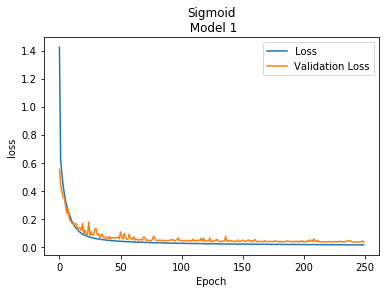

In [31]:
view(file='model-b.csv',title='Sigmoid',label='loss',model=1)

c) Modelo con función relu

* Se observó divergencia para lr=0.01, por ense se bajó a lr=0.001

In [34]:
histories = dict()
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=SGD(lr=0.001),loss='mean_squared_error')
model.summary()
history2 = model.fit(X_train_scaled, y_train, epochs=250, verbose=0, validation_data=(X_val_scaled, y_val))
histories['loss'] = history2.history['loss']
histories['val loss'] = history2.history['val_loss']
df_aux = pd.DataFrame(histories)
df_aux.to_csv('model-c.csv')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 256)               326656    
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 257       
Total params: 326,913
Trainable params: 326,913
Non-trainable params: 0
_________________________________________________________________


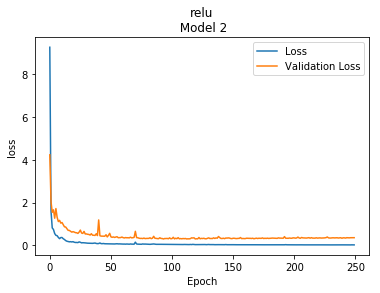

In [35]:
view(file='model-c.csv',title='relu',label='loss',model=2)

d) Variando Learning Rate

In [12]:
histories = dict() # Key = learn_rate, Value = history
n_lr = 20
learn_rate = np.linspace(0,1,n_lr)

for learn_r in learn_rate:
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=SGD(lr=learn_r),loss='mean_squared_error')
    history = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))
    histories['loss('+str(learn_r)+')'] = history.history['loss']
    histories['val loss('+str(learn_r)+')'] = history.history['val_loss']
    
df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-D-1.csv')

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 2s 217us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 2/250
9745/9745 [==============================] - 2s 217us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 3/250
9745/9745 [==============================] - 2s 212us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 4/250
9745/9745 [==============================] - 2s 161us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 5/250
9745/9745 [==============================] - 2s 157us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 6/250
9745/9745 [==============================] - 2s 176us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 7/250
9745/9745 [==============================] - 2s 176us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 8/250
9745/9745 [==============================] - 2s 171us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 9/250
9745/9745 [==============================] - 2s 157us/step - loss: 1

9745/9745 [==============================] - 2s 162us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 150/250
9745/9745 [==============================] - 2s 173us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 151/250
9745/9745 [==============================] - 2s 168us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 152/250
9745/9745 [==============================] - 2s 163us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 153/250
9745/9745 [==============================] - 2s 164us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 154/250
9745/9745 [==============================] - 2s 171us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 155/250
9745/9745 [==============================] - 2s 186us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 156/250
9745/9745 [==============================] - 2s 177us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 157/250
9745/9745 [==============================] - 2s 167us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 158/250
9

Epoch 223/250
9745/9745 [==============================] - 2s 155us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 224/250
9745/9745 [==============================] - 2s 154us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 225/250
9745/9745 [==============================] - 2s 159us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 226/250
9745/9745 [==============================] - 1s 153us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 227/250
9745/9745 [==============================] - 1s 153us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 228/250
9745/9745 [==============================] - 2s 157us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 229/250
9745/9745 [==============================] - 2s 155us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 230/250
9745/9745 [==============================] - 2s 154us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 231/250
9745/9745 [==============================] - 2s 158us/step - loss: 135.1554 - val_loss: 154.6922
E

9745/9745 [==============================] - 2s 220us/step - loss: nan - val_loss: nan
Epoch 133/250
9745/9745 [==============================] - 2s 207us/step - loss: nan - val_loss: nan
Epoch 134/250
9745/9745 [==============================] - 2s 183us/step - loss: nan - val_loss: nan
Epoch 135/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 136/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 137/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 138/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 139/250
9745/9745 [==============================] - 1s 154us/step - loss: nan - val_loss: nan
Epoch 140/250
9745/9745 [==============================] - 2s 186us/step - loss: nan - val_loss: nan
Epoch 141/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 208us/step - loss: nan - val_loss: nan
Epoch 45/250
9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 46/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 47/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 48/250
9745/9745 [==============================] - 2s 179us/step - loss: nan - val_loss: nan
Epoch 49/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 50/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 51/250
9745/9745 [==============================] - 1s 153us/step - loss: nan - val_loss: nan
Epoch 52/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 53/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 54/250


Epoch 126/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 127/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 128/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 129/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 130/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 131/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 132/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 133/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 134/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 135/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_

9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 208/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 209/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 210/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 211/250
9745/9745 [==============================] - 1s 154us/step - loss: nan - val_loss: nan
Epoch 212/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 213/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 214/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 215/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 216/250
9745/9745 [==============================] - 1s 154us/step - loss: nan - val_loss: nan
Epoc

Epoch 120/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 121/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 122/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 123/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 124/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 125/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 126/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 127/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 128/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 129/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_

9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 202/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 203/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 204/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 205/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 206/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 207/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 208/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 209/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 210/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoc

Epoch 114/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 115/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 116/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 117/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 118/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 119/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 120/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 121/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 122/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 123/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_

9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 196/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 197/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 198/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 199/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 200/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 201/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 202/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 203/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 204/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 27/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 28/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 29/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 30/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 31/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 32/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 33/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 34/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 35/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 36/250


Epoch 108/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 109/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 110/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 111/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 112/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 113/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 114/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 115/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 116/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 117/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_

9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 190/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 191/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 192/250
9745/9745 [==============================] - 2s 187us/step - loss: nan - val_loss: nan
Epoch 193/250
9745/9745 [==============================] - 2s 191us/step - loss: nan - val_loss: nan
Epoch 194/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 195/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 196/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 197/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 198/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 21/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 22/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 23/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 24/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 25/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 26/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 27/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 28/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 29/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 30/250


9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 103/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 104/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 105/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 106/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 107/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 108/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 109/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 110/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 111/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoc

Epoch 14/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 15/250
9745/9745 [==============================] - 2s 198us/step - loss: nan - val_loss: nan
Epoch 16/250
9745/9745 [==============================] - 2s 193us/step - loss: nan - val_loss: nan
Epoch 17/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 18/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 19/250
9745/9745 [==============================] - 2s 202us/step - loss: nan - val_loss: nan
Epoch 20/250
9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 21/250
9745/9745 [==============================] - 2s 206us/step - loss: nan - val_loss: nan
Epoch 22/250
9745/9745 [==============================] - 2s 188us/step - loss: nan - val_loss: nan
Epoch 23/250
9745/9745 [==============================] - 2s 182us/step - loss: nan - val_loss: nan


Epoch 96/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 97/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 98/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 99/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 100/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 101/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 102/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 103/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 104/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 105/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss

Epoch 8/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 9/250
9745/9745 [==============================] - 2s 186us/step - loss: nan - val_loss: nan
Epoch 10/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 11/250
9745/9745 [==============================] - 2s 185us/step - loss: nan - val_loss: nan
Epoch 12/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 13/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 14/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 15/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 16/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 17/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Ep

Epoch 90/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 91/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 92/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 93/250
9745/9745 [==============================] - 2s 179us/step - loss: nan - val_loss: nan
Epoch 94/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 95/250
9745/9745 [==============================] - 1s 149us/step - loss: nan - val_loss: nan
Epoch 96/250
9745/9745 [==============================] - 1s 149us/step - loss: nan - val_loss: nan
Epoch 97/250
9745/9745 [==============================] - 1s 154us/step - loss: nan - val_loss: nan
Epoch 98/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 99/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan


9745/9745 [==============================] - 2s 202us/step - loss: nan - val_loss: nan
Epoch 2/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 3/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 4/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 5/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 6/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 7/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 8/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 9/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 10/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 11/250
9745/974

9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 165/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 166/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 167/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 168/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 169/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 170/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 171/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 172/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 173/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 77/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 78/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 79/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 80/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 81/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 82/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 83/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 84/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 85/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 86/250


9745/9745 [==============================] - 2s 190us/step - loss: nan - val_loss: nan
Epoch 239/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 240/250
9745/9745 [==============================] - 2s 179us/step - loss: nan - val_loss: nan
Epoch 241/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 242/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 243/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 244/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 245/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 246/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 247/250
9745/9745 [==============================] - 2s 183us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 151/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 152/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 153/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 154/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 155/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 156/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 157/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 158/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 159/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 218us/step - loss: nan - val_loss: nan
Epoch 63/250
9745/9745 [==============================] - 2s 196us/step - loss: nan - val_loss: nan
Epoch 64/250
9745/9745 [==============================] - 2s 205us/step - loss: nan - val_loss: nan
Epoch 65/250
9745/9745 [==============================] - 2s 211us/step - loss: nan - val_loss: nan
Epoch 66/250
9745/9745 [==============================] - 2s 204us/step - loss: nan - val_loss: nan
Epoch 67/250
9745/9745 [==============================] - 2s 250us/step - loss: nan - val_loss: nan
Epoch 68/250
9745/9745 [==============================] - 2s 219us/step - loss: nan - val_loss: nan
Epoch 69/250
9745/9745 [==============================] - 2s 235us/step - loss: nan - val_loss: nan
Epoch 70/250
9745/9745 [==============================] - 3s 259us/step - loss: nan - val_loss: nan
Epoch 71/250
9745/9745 [==============================] - 2s 226us/step - loss: nan - val_loss: nan
Epoch 72/250


9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 225/250
9745/9745 [==============================] - 2s 200us/step - loss: nan - val_loss: nan
Epoch 226/250
9745/9745 [==============================] - 2s 191us/step - loss: nan - val_loss: nan
Epoch 227/250
9745/9745 [==============================] - 2s 190us/step - loss: nan - val_loss: nan
Epoch 228/250
9745/9745 [==============================] - 2s 208us/step - loss: nan - val_loss: nan
Epoch 229/250
9745/9745 [==============================] - 2s 186us/step - loss: nan - val_loss: nan
Epoch 230/250
9745/9745 [==============================] - 2s 220us/step - loss: nan - val_loss: nan
Epoch 231/250
9745/9745 [==============================] - 2s 214us/step - loss: nan - val_loss: nan
Epoch 232/250
9745/9745 [==============================] - 2s 204us/step - loss: nan - val_loss: nan
Epoch 233/250
9745/9745 [==============================] - 2s 189us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 137/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 138/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 139/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 140/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 141/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 142/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 143/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 144/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 145/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 49/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 50/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 51/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 52/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 53/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 54/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 55/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 56/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 57/250
9745/9745 [==============================] - 2s 185us/step - loss: nan - val_loss: nan
Epoch 58/250


9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 211/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 212/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 213/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 214/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 215/250
9745/9745 [==============================] - 2s 187us/step - loss: nan - val_loss: nan
Epoch 216/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 217/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 218/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 219/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoc

Epoch 123/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 124/250
9745/9745 [==============================] - 2s 208us/step - loss: nan - val_loss: nan
Epoch 125/250
9745/9745 [==============================] - 2s 197us/step - loss: nan - val_loss: nan
Epoch 126/250
9745/9745 [==============================] - 2s 216us/step - loss: nan - val_loss: nan
Epoch 127/250
9745/9745 [==============================] - 2s 196us/step - loss: nan - val_loss: nan
Epoch 128/250
9745/9745 [==============================] - 2s 204us/step - loss: nan - val_loss: nan
Epoch 129/250
9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 130/250
9745/9745 [==============================] - 2s 194us/step - loss: nan - val_loss: nan
Epoch 131/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 132/250
9745/9745 [==============================] - 2s 183us/step - loss: nan - val_

9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 205/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 206/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 207/250
9745/9745 [==============================] - 2s 182us/step - loss: nan - val_loss: nan
Epoch 208/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 209/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 210/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 211/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 212/250
9745/9745 [==============================] - 2s 181us/step - loss: nan - val_loss: nan
Epoch 213/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoc

Epoch 117/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 118/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 119/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 120/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 121/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 122/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 123/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 124/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 125/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 126/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_

9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 199/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 200/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 201/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 202/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 203/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 204/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 205/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 206/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 207/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoc

Epoch 111/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 112/250
9745/9745 [==============================] - 2s 154us/step - loss: nan - val_loss: nan
Epoch 113/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 114/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 115/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 116/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 117/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 118/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 119/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 120/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_

9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 193/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 194/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 195/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 196/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 197/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 198/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 199/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 200/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 201/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 24/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 25/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 26/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 27/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 28/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 29/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 30/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 31/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 32/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 33/250


9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 106/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 107/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 108/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 109/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 110/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 111/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 112/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 113/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 114/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 18/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 19/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 20/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 21/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 22/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 23/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 24/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 25/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 26/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 27/250


9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 100/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 101/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 102/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 103/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 104/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 105/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 106/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 107/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 108/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoc

AttributeError: module 'pandas' has no attribute 'Dataframe'

In [13]:
histories2 = dict() # Key = learn_rate, Value = history
n_lr = 20
learn_rate = np.linspace(0,1,n_lr)
for learn_r in learn_rate:
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=SGD(lr=learn_r),loss='mean_squared_error')
    history2 = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))
    histories2['loss('+str(learn_r)+')'] = history2.history['loss']
    histories2['val loss('+str(learn_r)+')'] = history2.history['val_loss']
    
df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-D-2.csv')

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 2s 241us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 2/250
9745/9745 [==============================] - 2s 195us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 3/250
9745/9745 [==============================] - 2s 217us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 4/250
9745/9745 [==============================] - 2s 202us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 5/250
9745/9745 [==============================] - 2s 178us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 6/250
9745/9745 [==============================] - 2s 207us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 7/250
9745/9745 [==============================] - 2s 197us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 8/250
9745/9745 [==============================] - 2s 189us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 9/250
9745/9745 [==============================] - 2s 176us/step - loss: 1

9745/9745 [==============================] - 2s 227us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 150/250
9745/9745 [==============================] - 2s 172us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 151/250
9745/9745 [==============================] - 2s 176us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 152/250
9745/9745 [==============================] - 2s 171us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 153/250
9745/9745 [==============================] - 2s 163us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 154/250
9745/9745 [==============================] - 2s 173us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 155/250
9745/9745 [==============================] - 2s 159us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 156/250
9745/9745 [==============================] - 2s 158us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 157/250
9745/9745 [==============================] - 2s 159us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 158/250
9

Epoch 223/250
9745/9745 [==============================] - 2s 165us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 224/250
9745/9745 [==============================] - 2s 156us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 225/250
9745/9745 [==============================] - 2s 160us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 226/250
9745/9745 [==============================] - 2s 166us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 227/250
9745/9745 [==============================] - 2s 158us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 228/250
9745/9745 [==============================] - 2s 157us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 229/250
9745/9745 [==============================] - 2s 163us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 230/250
9745/9745 [==============================] - 2s 160us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 231/250
9745/9745 [==============================] - 2s 161us/step - loss: 135.7536 - val_loss: 154.1756
E

9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 133/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 134/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 135/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 136/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 137/250
9745/9745 [==============================] - 2s 184us/step - loss: nan - val_loss: nan
Epoch 138/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 139/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 140/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 141/250
9745/9745 [==============================] - 2s 200us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 225us/step - loss: nan - val_loss: nan
Epoch 45/250
9745/9745 [==============================] - 2s 198us/step - loss: nan - val_loss: nan
Epoch 46/250
9745/9745 [==============================] - 2s 198us/step - loss: nan - val_loss: nan
Epoch 47/250
9745/9745 [==============================] - 2s 201us/step - loss: nan - val_loss: nan
Epoch 48/250
9745/9745 [==============================] - 2s 197us/step - loss: nan - val_loss: nan
Epoch 49/250
9745/9745 [==============================] - 2s 197us/step - loss: nan - val_loss: nan
Epoch 50/250
9745/9745 [==============================] - 2s 183us/step - loss: nan - val_loss: nan
Epoch 51/250
9745/9745 [==============================] - 2s 193us/step - loss: nan - val_loss: nan
Epoch 52/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 53/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 54/250


Epoch 126/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 127/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 128/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 129/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 130/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 131/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 132/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 133/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 134/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 135/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_

9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 208/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 209/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 210/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 211/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 212/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 213/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 214/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 215/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 216/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoc

Epoch 120/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 121/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 122/250
9745/9745 [==============================] - 2s 186us/step - loss: nan - val_loss: nan
Epoch 123/250
9745/9745 [==============================] - 2s 210us/step - loss: nan - val_loss: nan
Epoch 124/250
9745/9745 [==============================] - 2s 236us/step - loss: nan - val_loss: nan
Epoch 125/250
9745/9745 [==============================] - 2s 216us/step - loss: nan - val_loss: nan
Epoch 126/250
9745/9745 [==============================] - 2s 196us/step - loss: nan - val_loss: nan
Epoch 127/250
9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 128/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 129/250
9745/9745 [==============================] - 2s 220us/step - loss: nan - val_

9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 202/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 203/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 204/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 205/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 206/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 207/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 208/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 209/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 210/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoc

Epoch 114/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 115/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 116/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 117/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 118/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 119/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 120/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 121/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 122/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 123/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_

9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 196/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 197/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 198/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 199/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 200/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 201/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 202/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 203/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 204/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 27/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 28/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 29/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 30/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 31/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 32/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 33/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 34/250
9745/9745 [==============================] - 2s 206us/step - loss: nan - val_loss: nan
Epoch 35/250
9745/9745 [==============================] - 2s 238us/step - loss: nan - val_loss: nan
Epoch 36/250


Epoch 108/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 109/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 110/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 111/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 112/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 113/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 114/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 115/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 116/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 117/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_

9745/9745 [==============================] - 2s 191us/step - loss: nan - val_loss: nan
Epoch 190/250
9745/9745 [==============================] - 2s 209us/step - loss: nan - val_loss: nan
Epoch 191/250
9745/9745 [==============================] - 2s 221us/step - loss: nan - val_loss: nan
Epoch 192/250
9745/9745 [==============================] - 2s 212us/step - loss: nan - val_loss: nan
Epoch 193/250
9745/9745 [==============================] - 2s 205us/step - loss: nan - val_loss: nan
Epoch 194/250
9745/9745 [==============================] - 2s 204us/step - loss: nan - val_loss: nan
Epoch 195/250
9745/9745 [==============================] - 2s 213us/step - loss: nan - val_loss: nan
Epoch 196/250
9745/9745 [==============================] - 2s 214us/step - loss: nan - val_loss: nan
Epoch 197/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 198/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 21/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 22/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 23/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 24/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 25/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 26/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 27/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 28/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 29/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 30/250


9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 103/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 104/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 105/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 106/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 107/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 108/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 109/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 110/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 111/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoc

Epoch 14/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 15/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 16/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 17/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 18/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 19/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 20/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 21/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 22/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 23/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan


Epoch 96/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 97/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 98/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 99/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 100/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 101/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 102/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 103/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 104/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 105/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss

Epoch 8/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 9/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 10/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 11/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 12/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 13/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 14/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 15/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 16/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 17/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Ep

Epoch 90/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 91/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 92/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 93/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 94/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 95/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 96/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 97/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 98/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 99/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan


9745/9745 [==============================] - 2s 232us/step - loss: nan - val_loss: nan
Epoch 2/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 3/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 4/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 5/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 6/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 7/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 8/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 9/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 10/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 11/250
9745/974

9745/9745 [==============================] - 2s 201us/step - loss: nan - val_loss: nan
Epoch 165/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 166/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 167/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 168/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 169/250
9745/9745 [==============================] - 2s 194us/step - loss: nan - val_loss: nan
Epoch 170/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 171/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 172/250
9745/9745 [==============================] - 2s 216us/step - loss: nan - val_loss: nan
Epoch 173/250
9745/9745 [==============================] - 3s 257us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 186us/step - loss: nan - val_loss: nan
Epoch 77/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 78/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 79/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 80/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 81/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 82/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 83/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 84/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 85/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 86/250


9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 239/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 240/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 241/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 242/250
9745/9745 [==============================] - 2s 208us/step - loss: nan - val_loss: nan
Epoch 243/250
9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 244/250
9745/9745 [==============================] - 2s 197us/step - loss: nan - val_loss: nan
Epoch 245/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 246/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 247/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 151/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 152/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 153/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 154/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 155/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 156/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 157/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 158/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 159/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 63/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 64/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 65/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 66/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 67/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 68/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 69/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 70/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 71/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 72/250


9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 225/250
9745/9745 [==============================] - 2s 190us/step - loss: nan - val_loss: nan
Epoch 226/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 227/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 228/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 229/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 230/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 231/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 232/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 233/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 137/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 138/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 139/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 140/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 141/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 142/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 143/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 144/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 145/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 49/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 50/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 51/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 52/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 53/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 54/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 55/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 56/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 57/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 58/250


9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 211/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 212/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 213/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 214/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 215/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 216/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 217/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 218/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 219/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoc

Epoch 123/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 124/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 125/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 126/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 127/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 128/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 129/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 130/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 131/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 132/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_

9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 205/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 206/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 207/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 208/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 209/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 210/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 211/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 212/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 213/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoc

Epoch 117/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 118/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 119/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 120/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 121/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 122/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 123/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 124/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 125/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 126/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_

9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 199/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 200/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 201/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 202/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 203/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 204/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 205/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 206/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 207/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoc

Epoch 111/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 112/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 113/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 114/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 115/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 116/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 117/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 118/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 119/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 120/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_

9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 193/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 194/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 195/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 196/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 197/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 198/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 199/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 200/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 201/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 24/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 25/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 26/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 27/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 28/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 29/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 30/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 31/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 32/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 33/250


9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 106/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 107/250
9745/9745 [==============================] - 2s 190us/step - loss: nan - val_loss: nan
Epoch 108/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 109/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 110/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 111/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 112/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 113/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 114/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 18/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 19/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 20/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 21/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 22/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 23/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 24/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 25/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 26/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 27/250


9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 100/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 101/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 102/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 103/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 104/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 105/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 106/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 107/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 108/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoc

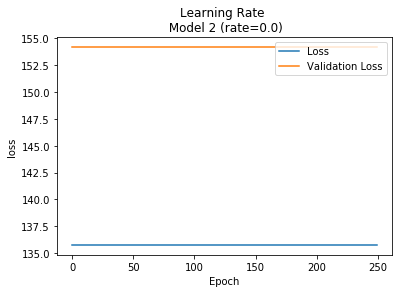

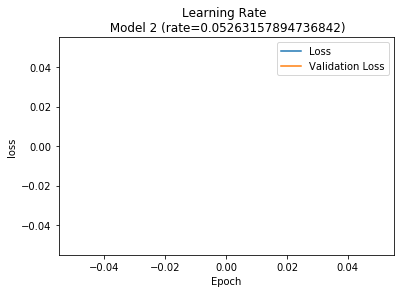

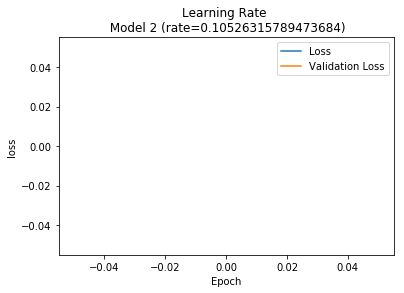

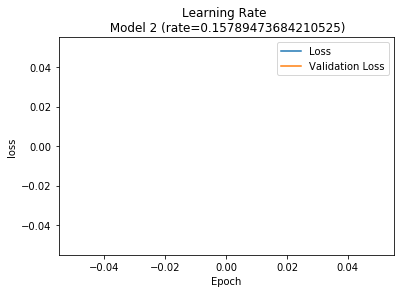

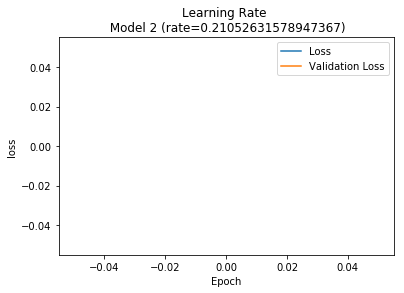

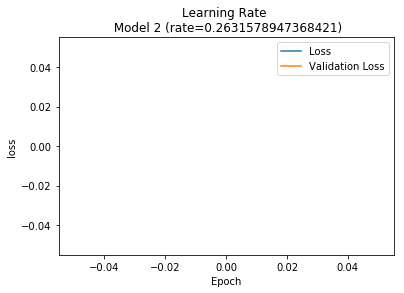

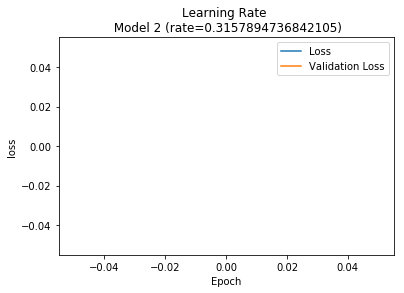

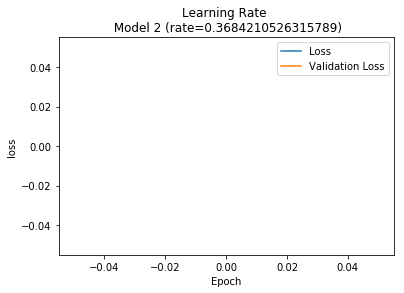

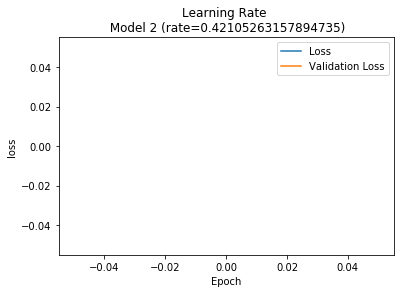

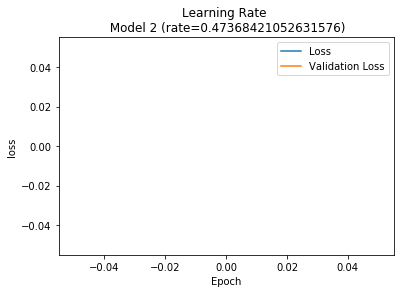

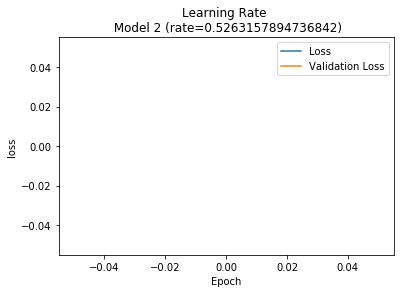

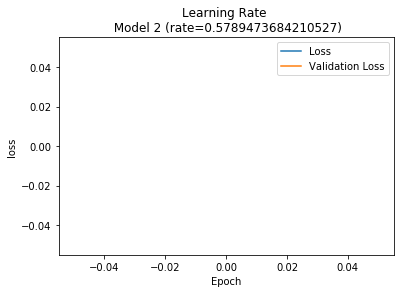

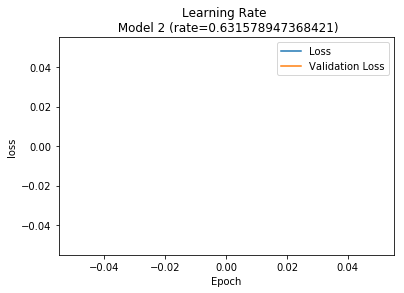

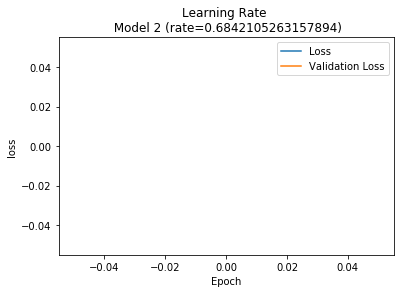

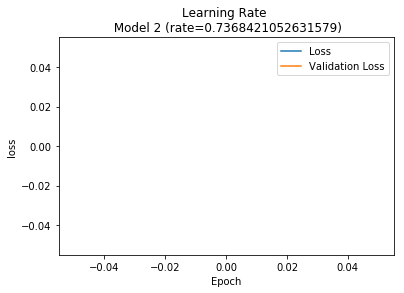

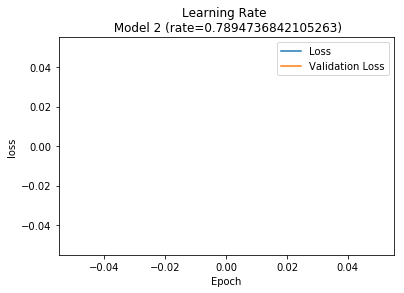

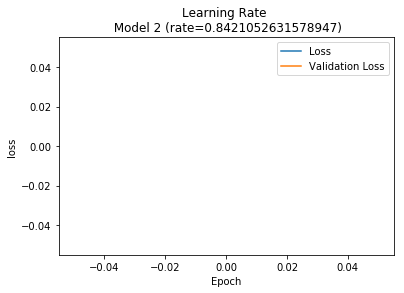

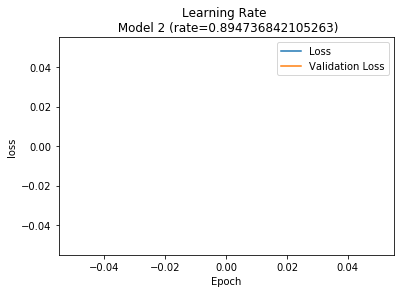

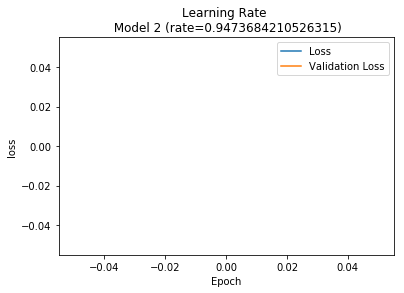

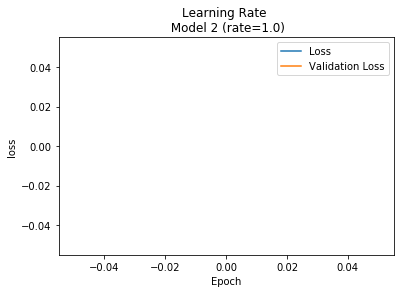

In [51]:
df_aux = pd.read_csv('1-D-2.csv')
df_aux.drop(['Unnamed: 0'],axis=1,inplace=True)

for c in np.split(df_aux.columns,len(df_aux.columns)/2):
    loss,v_loss = c
    rate = loss.strip(')').split('(')[1]
    ylab = loss.split('(')[0]
    # Ploting
    plt.plot(df_aux[loss])
    plt.plot(df_aux[v_loss])
    plt.title('Learning Rate \n Model 2 (rate='+rate+')')
    plt.xlabel('Epoch')
    plt.ylabel(ylab)
    plt.legend(['Loss', 'Validation Loss'], loc='upper right')
    plt.savefig('Learning Rate \n Model 2 (rate='+rate+')'+'.png')
    plt.show()

e) Progressive Decay

* (Sigmoid) Se puede ver que entre mayor sea o menor el valor de PD no afectará siempre de la misma manera, produciendose mejores casos por ejemplo para 1e-6 y 0.215, donde entre medio hay varios valores que entregan mayor diferencia.
* (relu) Se puede ver que entre mayor sea el PD empeora

In [15]:
n_decay = 10
histories = dict() 
histories2 = dict() 

for dec in np.logspace(-6,0,n_decay):
    sgd = SGD(lr=0.001, decay=dec)
    # model 1
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=sgd,loss='mean_squared_error')
    history = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))
    histories['loss('+str(dec)+')'] = history.history['loss']
    histories['val loss('+str(dec)+')'] = history.history['val_loss']
    # model 2
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=sgd,loss='mean_squared_error')
    history2 = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))
    histories2['loss('+str(dec)+')'] = history2.history['loss']
    histories2['val loss('+str(dec)+')'] = history2.history['val_loss']
    
df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-E-1.csv')
df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-E-2.csv')

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 3s 346us/step - loss: 3.7874 - val_loss: 1.1124
Epoch 2/250
9745/9745 [==============================] - 2s 200us/step - loss: 1.1400 - val_loss: 0.8770
Epoch 3/250
9745/9745 [==============================] - 2s 201us/step - loss: 0.9484 - val_loss: 0.7307
Epoch 4/250
9745/9745 [==============================] - 2s 208us/step - loss: 0.8409 - val_loss: 0.6640
Epoch 5/250
9745/9745 [==============================] - 2s 208us/step - loss: 0.7724 - val_loss: 0.6143
Epoch 6/250
9745/9745 [==============================] - 2s 209us/step - loss: 0.7251 - val_loss: 0.5882
Epoch 7/250
9745/9745 [==============================] - 2s 221us/step - loss: 0.6909 - val_loss: 0.5678
Epoch 8/250
9745/9745 [==============================] - 2s 205us/step - loss: 0.6631 - val_loss: 0.5399
Epoch 9/250
9745/9745 [==============================] - 2s 193us/step - loss: 0.6423 - val_loss: 0.5241
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.2086 - val_loss: 0.2026
Epoch 79/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.2062 - val_loss: 0.1987
Epoch 80/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.2031 - val_loss: 0.1967
Epoch 81/250
9745/9745 [==============================] - 2s 165us/step - loss: 0.2003 - val_loss: 0.1950
Epoch 82/250
9745/9745 [==============================] - 2s 163us/step - loss: 0.1977 - val_loss: 0.1934
Epoch 83/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1951 - val_loss: 0.1926
Epoch 84/250
9745/9745 [==============================] - 2s 166us/step - loss: 0.1923 - val_loss: 0.1883
Epoch 85/250
9745/9745 [==============================] - 2s 164us/step - loss: 0.1895 - val_loss: 0.1882
Epoch 86/250
9745/9745 [==============================] - 2s 165us/step - loss: 0.1868 - val_loss: 0.1853
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.0859 - val_loss: 0.1016
Epoch 156/250
9745/9745 [==============================] - 2s 168us/step - loss: 0.0850 - val_loss: 0.1015
Epoch 157/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.0842 - val_loss: 0.1007
Epoch 158/250
9745/9745 [==============================] - 2s 207us/step - loss: 0.0837 - val_loss: 0.0995
Epoch 159/250
9745/9745 [==============================] - 2s 188us/step - loss: 0.0832 - val_loss: 0.0990
Epoch 160/250
9745/9745 [==============================] - 2s 187us/step - loss: 0.0825 - val_loss: 0.0995
Epoch 161/250
9745/9745 [==============================] - 2s 180us/step - loss: 0.0821 - val_loss: 0.0975
Epoch 162/250
9745/9745 [==============================] - 2s 183us/step - loss: 0.0814 - val_loss: 0.0973
Epoch 163/250
9745/9745 [==============================] - 2s 196us/step - loss: 0.0807 - val_loss: 0.0973
Epoch 164/250
9745/9745 [============

Epoch 58/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.0777 - val_loss: 0.4176
Epoch 59/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.0770 - val_loss: 0.4462
Epoch 60/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.0786 - val_loss: 0.4526
Epoch 61/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.0693 - val_loss: 0.3877
Epoch 62/250
9745/9745 [==============================] - 2s 167us/step - loss: 0.0644 - val_loss: 0.4131
Epoch 63/250
9745/9745 [==============================] - 2s 167us/step - loss: 0.0625 - val_loss: 0.4179
Epoch 64/250
9745/9745 [==============================] - 2s 168us/step - loss: 0.0628 - val_loss: 0.4283
Epoch 65/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.0607 - val_loss: 0.4317
Epoch 66/250
9745/9745 [==============================] - 2s 166us/step - loss: 0.0621 - val_loss: 0.4267
Epoch 67/250
9745/9745 [======================

Epoch 135/250
9745/9745 [==============================] - 2s 175us/step - loss: 0.0378 - val_loss: 0.3815
Epoch 136/250
9745/9745 [==============================] - 2s 192us/step - loss: 0.0381 - val_loss: 0.3684
Epoch 137/250
9745/9745 [==============================] - 2s 191us/step - loss: 0.0329 - val_loss: 0.3797
Epoch 138/250
9745/9745 [==============================] - 2s 224us/step - loss: 0.0337 - val_loss: 0.3767
Epoch 139/250
9745/9745 [==============================] - 2s 196us/step - loss: 0.0324 - val_loss: 0.3904
Epoch 140/250
9745/9745 [==============================] - 2s 195us/step - loss: 0.0317 - val_loss: 0.3885
Epoch 141/250
9745/9745 [==============================] - 2s 185us/step - loss: 0.0329 - val_loss: 0.3820
Epoch 142/250
9745/9745 [==============================] - 2s 166us/step - loss: 0.0324 - val_loss: 0.3868
Epoch 143/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0344 - val_loss: 0.3877
Epoch 144/250
9745/9745 [============

9745/9745 [==============================] - 2s 184us/step - loss: 0.4052 - val_loss: 0.3474
Epoch 38/250
9745/9745 [==============================] - 2s 183us/step - loss: 0.3994 - val_loss: 0.3465
Epoch 39/250
9745/9745 [==============================] - 2s 178us/step - loss: 0.3938 - val_loss: 0.3432
Epoch 40/250
9745/9745 [==============================] - 2s 180us/step - loss: 0.3877 - val_loss: 0.3362
Epoch 41/250
9745/9745 [==============================] - 2s 175us/step - loss: 0.3821 - val_loss: 0.3346
Epoch 42/250
9745/9745 [==============================] - 2s 183us/step - loss: 0.3767 - val_loss: 0.3284
Epoch 43/250
9745/9745 [==============================] - 2s 183us/step - loss: 0.3712 - val_loss: 0.3232
Epoch 44/250
9745/9745 [==============================] - 2s 183us/step - loss: 0.3659 - val_loss: 0.3192
Epoch 45/250
9745/9745 [==============================] - 2s 178us/step - loss: 0.3605 - val_loss: 0.3146
Epoch 46/250
9745/9745 [==============================] - 2

9745/9745 [==============================] - 2s 175us/step - loss: 0.0840 - val_loss: 0.1010
Epoch 191/250
9745/9745 [==============================] - 2s 201us/step - loss: 0.0835 - val_loss: 0.1008
Epoch 192/250
9745/9745 [==============================] - 3s 269us/step - loss: 0.0831 - val_loss: 0.1009
Epoch 193/250
9745/9745 [==============================] - 2s 233us/step - loss: 0.0825 - val_loss: 0.0996
Epoch 194/250
9745/9745 [==============================] - 2s 216us/step - loss: 0.0821 - val_loss: 0.0994
Epoch 195/250
9745/9745 [==============================] - 2s 230us/step - loss: 0.0818 - val_loss: 0.0987
Epoch 196/250
9745/9745 [==============================] - 2s 186us/step - loss: 0.0813 - val_loss: 0.0986
Epoch 197/250
9745/9745 [==============================] - 2s 198us/step - loss: 0.0810 - val_loss: 0.0984
Epoch 198/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0804 - val_loss: 0.0975
Epoch 199/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 193us/step - loss: 0.0532 - val_loss: 0.5220
Epoch 94/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0513 - val_loss: 0.5313
Epoch 95/250
9745/9745 [==============================] - 2s 188us/step - loss: 0.0533 - val_loss: 0.5228
Epoch 96/250
9745/9745 [==============================] - 2s 247us/step - loss: 0.0542 - val_loss: 0.5560
Epoch 97/250
9745/9745 [==============================] - 2s 209us/step - loss: 0.0523 - val_loss: 0.5246
Epoch 98/250
9745/9745 [==============================] - 2s 230us/step - loss: 0.0506 - val_loss: 0.5138
Epoch 99/250
9745/9745 [==============================] - 2s 210us/step - loss: 0.0517 - val_loss: 0.5318
Epoch 100/250
9745/9745 [==============================] - 2s 188us/step - loss: 0.0515 - val_loss: 0.5258
Epoch 101/250
9745/9745 [==============================] - 2s 192us/step - loss: 0.0494 - val_loss: 0.5168
Epoch 102/250
9745/9745 [==============================] 

9745/9745 [==============================] - 2s 170us/step - loss: 0.0238 - val_loss: 0.4946
Epoch 246/250
9745/9745 [==============================] - 2s 169us/step - loss: 0.0238 - val_loss: 0.5150
Epoch 247/250
9745/9745 [==============================] - 2s 169us/step - loss: 0.0246 - val_loss: 0.4697
Epoch 248/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.0237 - val_loss: 0.4746
Epoch 249/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.0234 - val_loss: 0.4655
Epoch 250/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.0231 - val_loss: 0.4791
Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 3s 278us/step - loss: 3.7172 - val_loss: 1.1232
Epoch 2/250
9745/9745 [==============================] - 2s 179us/step - loss: 1.1424 - val_loss: 0.8832
Epoch 3/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.9608 - val_loss: 0.7802
Epoch 4/2

Epoch 72/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.2871 - val_loss: 0.2594
Epoch 73/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.2841 - val_loss: 0.2585
Epoch 74/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.2809 - val_loss: 0.2578
Epoch 75/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.2789 - val_loss: 0.2539
Epoch 76/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.2761 - val_loss: 0.2519
Epoch 77/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.2735 - val_loss: 0.2502
Epoch 78/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.2711 - val_loss: 0.2478
Epoch 79/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.2686 - val_loss: 0.2464
Epoch 80/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.2662 - val_loss: 0.2469
Epoch 81/250
9745/9745 [======================

Epoch 149/250
9745/9745 [==============================] - 2s 178us/step - loss: 0.1575 - val_loss: 0.1637
Epoch 150/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1566 - val_loss: 0.1635
Epoch 151/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1556 - val_loss: 0.1622
Epoch 152/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1545 - val_loss: 0.1615
Epoch 153/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1536 - val_loss: 0.1608
Epoch 154/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1525 - val_loss: 0.1605
Epoch 155/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1519 - val_loss: 0.1591
Epoch 156/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.1508 - val_loss: 0.1591
Epoch 157/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.1500 - val_loss: 0.1577
Epoch 158/250
9745/9745 [============

Epoch 52/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1367 - val_loss: 0.8045
Epoch 53/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.1542 - val_loss: 1.0008
Epoch 54/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1375 - val_loss: 0.8795
Epoch 55/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.1305 - val_loss: 0.8643
Epoch 56/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.1219 - val_loss: 0.7926
Epoch 57/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1230 - val_loss: 0.7812
Epoch 58/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.1188 - val_loss: 0.8568
Epoch 59/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1176 - val_loss: 0.7626
Epoch 60/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1164 - val_loss: 0.7802
Epoch 61/250
9745/9745 [======================

9745/9745 [==============================] - 2s 172us/step - loss: 0.0627 - val_loss: 0.5415
Epoch 130/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.0622 - val_loss: 0.5534
Epoch 131/250
9745/9745 [==============================] - 2s 182us/step - loss: 0.0626 - val_loss: 0.5492
Epoch 132/250
9745/9745 [==============================] - 2s 181us/step - loss: 0.0668 - val_loss: 0.5471
Epoch 133/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0707 - val_loss: 0.5564
Epoch 134/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0612 - val_loss: 0.5396
Epoch 135/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.0599 - val_loss: 0.5437
Epoch 136/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0616 - val_loss: 0.5733
Epoch 137/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.0597 - val_loss: 0.5351
Epoch 138/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 182us/step - loss: 0.4995 - val_loss: 0.4205
Epoch 32/250
9745/9745 [==============================] - 2s 179us/step - loss: 0.4957 - val_loss: 0.4178
Epoch 33/250
9745/9745 [==============================] - 2s 181us/step - loss: 0.4919 - val_loss: 0.4207
Epoch 34/250
9745/9745 [==============================] - 2s 179us/step - loss: 0.4881 - val_loss: 0.4132
Epoch 35/250
9745/9745 [==============================] - 2s 181us/step - loss: 0.4847 - val_loss: 0.4124
Epoch 36/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.4813 - val_loss: 0.4107
Epoch 37/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.4776 - val_loss: 0.4096
Epoch 38/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.4746 - val_loss: 0.4032
Epoch 39/250
9745/9745 [==============================] - 2s 180us/step - loss: 0.4708 - val_loss: 0.4005
Epoch 40/250
9745/9745 [==============================] - 2

9745/9745 [==============================] - 2s 183us/step - loss: 0.2777 - val_loss: 0.2573
Epoch 185/250
9745/9745 [==============================] - 2s 181us/step - loss: 0.2771 - val_loss: 0.2573
Epoch 186/250
9745/9745 [==============================] - 2s 184us/step - loss: 0.2767 - val_loss: 0.2567
Epoch 187/250
9745/9745 [==============================] - 2s 180us/step - loss: 0.2761 - val_loss: 0.2561
Epoch 188/250
9745/9745 [==============================] - 2s 184us/step - loss: 0.2755 - val_loss: 0.2559
Epoch 189/250
9745/9745 [==============================] - 2s 178us/step - loss: 0.2748 - val_loss: 0.2562
Epoch 190/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.2740 - val_loss: 0.2546
Epoch 191/250
9745/9745 [==============================] - 2s 175us/step - loss: 0.2738 - val_loss: 0.2549
Epoch 192/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.2733 - val_loss: 0.2544
Epoch 193/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 225us/step - loss: 0.1922 - val_loss: 1.0549
Epoch 88/250
9745/9745 [==============================] - 2s 198us/step - loss: 0.1906 - val_loss: 1.0295
Epoch 89/250
9745/9745 [==============================] - 2s 201us/step - loss: 0.1880 - val_loss: 1.0310
Epoch 90/250
9745/9745 [==============================] - 2s 201us/step - loss: 0.1860 - val_loss: 1.0314
Epoch 91/250
9745/9745 [==============================] - 2s 237us/step - loss: 0.1850 - val_loss: 1.0202
Epoch 92/250
9745/9745 [==============================] - 2s 214us/step - loss: 0.1828 - val_loss: 1.0235
Epoch 93/250
9745/9745 [==============================] - 2s 175us/step - loss: 0.1810 - val_loss: 1.0052
Epoch 94/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.1798 - val_loss: 1.0156
Epoch 95/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1780 - val_loss: 1.0239
Epoch 96/250
9745/9745 [==============================] - 2

Epoch 164/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.1166 - val_loss: 0.8250
Epoch 165/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1165 - val_loss: 0.8285
Epoch 166/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1158 - val_loss: 0.8141
Epoch 167/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.1152 - val_loss: 0.8142
Epoch 168/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.1153 - val_loss: 0.8111
Epoch 169/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1147 - val_loss: 0.8096
Epoch 170/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1144 - val_loss: 0.8156
Epoch 171/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1136 - val_loss: 0.8257
Epoch 172/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.1129 - val_loss: 0.8156
Epoch 173/250
9745/9745 [============

Epoch 67/250
9745/9745 [==============================] - 2s 182us/step - loss: 0.5508 - val_loss: 0.4603
Epoch 68/250
9745/9745 [==============================] - 2s 180us/step - loss: 0.5497 - val_loss: 0.4594
Epoch 69/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.5487 - val_loss: 0.4576
Epoch 70/250
9745/9745 [==============================] - 2s 185us/step - loss: 0.5481 - val_loss: 0.4582
Epoch 71/250
9745/9745 [==============================] - 2s 184us/step - loss: 0.5470 - val_loss: 0.4589
Epoch 72/250
9745/9745 [==============================] - 2s 181us/step - loss: 0.5463 - val_loss: 0.4573
Epoch 73/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.5454 - val_loss: 0.4566
Epoch 74/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.5446 - val_loss: 0.4552
Epoch 75/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.5438 - val_loss: 0.4561
Epoch 76/250
9745/9745 [======================

Epoch 144/250
9745/9745 [==============================] - 2s 183us/step - loss: 0.5079 - val_loss: 0.4292
Epoch 145/250
9745/9745 [==============================] - 2s 182us/step - loss: 0.5076 - val_loss: 0.4287
Epoch 146/250
9745/9745 [==============================] - 2s 183us/step - loss: 0.5072 - val_loss: 0.4288
Epoch 147/250
9745/9745 [==============================] - 2s 184us/step - loss: 0.5069 - val_loss: 0.4282
Epoch 148/250
9745/9745 [==============================] - 2s 182us/step - loss: 0.5065 - val_loss: 0.4281
Epoch 149/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.5062 - val_loss: 0.4280
Epoch 150/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.5058 - val_loss: 0.4277
Epoch 151/250
9745/9745 [==============================] - 2s 188us/step - loss: 0.5055 - val_loss: 0.4275
Epoch 152/250
9745/9745 [==============================] - 2s 187us/step - loss: 0.5052 - val_loss: 0.4272
Epoch 153/250
9745/9745 [============

9745/9745 [==============================] - 2s 183us/step - loss: 0.9565 - val_loss: 2.1093
Epoch 47/250
9745/9745 [==============================] - 2s 185us/step - loss: 0.9404 - val_loss: 2.1164
Epoch 48/250
9745/9745 [==============================] - 2s 184us/step - loss: 0.9257 - val_loss: 2.0856
Epoch 49/250
9745/9745 [==============================] - 2s 183us/step - loss: 0.9120 - val_loss: 2.0679
Epoch 50/250
9745/9745 [==============================] - 2s 185us/step - loss: 0.9003 - val_loss: 2.0499
Epoch 51/250
9745/9745 [==============================] - 2s 185us/step - loss: 0.8866 - val_loss: 2.0292
Epoch 52/250
9745/9745 [==============================] - 2s 185us/step - loss: 0.8749 - val_loss: 2.0103
Epoch 53/250
9745/9745 [==============================] - 2s 184us/step - loss: 0.8632 - val_loss: 1.9910
Epoch 54/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.8513 - val_loss: 2.0059
Epoch 55/250
9745/9745 [==============================] - 2

9745/9745 [==============================] - 2s 176us/step - loss: 0.3652 - val_loss: 1.3964
Epoch 200/250
9745/9745 [==============================] - 2s 187us/step - loss: 0.3650 - val_loss: 1.3880
Epoch 201/250
9745/9745 [==============================] - 2s 186us/step - loss: 0.3637 - val_loss: 1.3865
Epoch 202/250
9745/9745 [==============================] - 2s 185us/step - loss: 0.3624 - val_loss: 1.3840
Epoch 203/250
9745/9745 [==============================] - 2s 187us/step - loss: 0.3615 - val_loss: 1.3795
Epoch 204/250
9745/9745 [==============================] - 2s 184us/step - loss: 0.3600 - val_loss: 1.3924
Epoch 205/250
9745/9745 [==============================] - 2s 175us/step - loss: 0.3592 - val_loss: 1.3756
Epoch 206/250
9745/9745 [==============================] - 2s 178us/step - loss: 0.3584 - val_loss: 1.3866
Epoch 207/250
9745/9745 [==============================] - 2s 185us/step - loss: 0.3572 - val_loss: 1.3726
Epoch 208/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 173us/step - loss: 0.6972 - val_loss: 0.5706
Epoch 103/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.6968 - val_loss: 0.5701
Epoch 104/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.6963 - val_loss: 0.5696
Epoch 105/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.6958 - val_loss: 0.5692
Epoch 106/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.6954 - val_loss: 0.5690
Epoch 107/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.6950 - val_loss: 0.5686
Epoch 108/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.6945 - val_loss: 0.5683
Epoch 109/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.6941 - val_loss: 0.5678
Epoch 110/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.6937 - val_loss: 0.5675
Epoch 111/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 174us/step - loss: 58.5705 - val_loss: 59.1389
Epoch 5/250
9745/9745 [==============================] - 2s 173us/step - loss: 46.4832 - val_loss: 47.9949
Epoch 6/250
9745/9745 [==============================] - 2s 174us/step - loss: 36.9126 - val_loss: 39.3859
Epoch 7/250
9745/9745 [==============================] - 2s 173us/step - loss: 29.8586 - val_loss: 33.0994
Epoch 8/250
9745/9745 [==============================] - 2s 175us/step - loss: 24.9349 - val_loss: 28.5762
Epoch 9/250
9745/9745 [==============================] - 2s 175us/step - loss: 21.5211 - val_loss: 25.3352
Epoch 10/250
9745/9745 [==============================] - 2s 173us/step - loss: 19.0841 - val_loss: 22.9107
Epoch 11/250
9745/9745 [==============================] - 2s 174us/step - loss: 17.2705 - val_loss: 21.0382
Epoch 12/250
9745/9745 [==============================] - 2s 174us/step - loss: 15.8914 - val_loss: 19.5969
Epoch 13/250
9745/9745 [======================

9745/9745 [==============================] - 2s 174us/step - loss: 2.4732 - val_loss: 4.0741
Epoch 82/250
9745/9745 [==============================] - 2s 174us/step - loss: 2.4409 - val_loss: 4.0417
Epoch 83/250
9745/9745 [==============================] - 2s 174us/step - loss: 2.4092 - val_loss: 4.0062
Epoch 84/250
9745/9745 [==============================] - 2s 173us/step - loss: 2.3793 - val_loss: 3.9733
Epoch 85/250
9745/9745 [==============================] - 2s 174us/step - loss: 2.3495 - val_loss: 3.9319
Epoch 86/250
9745/9745 [==============================] - 2s 174us/step - loss: 2.3209 - val_loss: 3.8947
Epoch 87/250
9745/9745 [==============================] - 2s 174us/step - loss: 2.2937 - val_loss: 3.8591
Epoch 88/250
9745/9745 [==============================] - 2s 174us/step - loss: 2.2658 - val_loss: 3.8378
Epoch 89/250
9745/9745 [==============================] - 2s 174us/step - loss: 2.2406 - val_loss: 3.7963
Epoch 90/250
9745/9745 [==============================] - 2

Epoch 158/250
9745/9745 [==============================] - 2s 180us/step - loss: 1.3585 - val_loss: 2.7118
Epoch 159/250
9745/9745 [==============================] - 2s 184us/step - loss: 1.3521 - val_loss: 2.6998
Epoch 160/250
9745/9745 [==============================] - 2s 176us/step - loss: 1.3460 - val_loss: 2.6991
Epoch 161/250
9745/9745 [==============================] - 2s 180us/step - loss: 1.3403 - val_loss: 2.6868
Epoch 162/250
9745/9745 [==============================] - 2s 180us/step - loss: 1.3345 - val_loss: 2.6816
Epoch 163/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.3285 - val_loss: 2.6777
Epoch 164/250
9745/9745 [==============================] - 2s 177us/step - loss: 1.3229 - val_loss: 2.6696
Epoch 165/250
9745/9745 [==============================] - 2s 186us/step - loss: 1.3172 - val_loss: 2.6593
Epoch 166/250
9745/9745 [==============================] - 2s 187us/step - loss: 1.3115 - val_loss: 2.6579
Epoch 167/250
9745/9745 [============

Epoch 61/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.1029 - val_loss: 0.9382
Epoch 62/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.1017 - val_loss: 0.9371
Epoch 63/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.1006 - val_loss: 0.9360
Epoch 64/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0995 - val_loss: 0.9350
Epoch 65/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0984 - val_loss: 0.9339
Epoch 66/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0974 - val_loss: 0.9329
Epoch 67/250
9745/9745 [==============================] - 2s 172us/step - loss: 1.0963 - val_loss: 0.9319
Epoch 68/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0953 - val_loss: 0.9310
Epoch 69/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0943 - val_loss: 0.9300
Epoch 70/250
9745/9745 [======================

Epoch 138/250
9745/9745 [==============================] - 2s 172us/step - loss: 1.0500 - val_loss: 0.8873
Epoch 139/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0495 - val_loss: 0.8869
Epoch 140/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0491 - val_loss: 0.8865
Epoch 141/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0487 - val_loss: 0.8861
Epoch 142/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0483 - val_loss: 0.8857
Epoch 143/250
9745/9745 [==============================] - 2s 172us/step - loss: 1.0478 - val_loss: 0.8853
Epoch 144/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0474 - val_loss: 0.8849
Epoch 145/250
9745/9745 [==============================] - 2s 172us/step - loss: 1.0470 - val_loss: 0.8845
Epoch 146/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0466 - val_loss: 0.8841
Epoch 147/250
9745/9745 [============

Epoch 40/250
9745/9745 [==============================] - 2s 174us/step - loss: 22.3546 - val_loss: 27.7314
Epoch 41/250
9745/9745 [==============================] - 2s 171us/step - loss: 21.7768 - val_loss: 27.0953
Epoch 42/250
9745/9745 [==============================] - 2s 172us/step - loss: 21.2381 - val_loss: 26.5000
Epoch 43/250
9745/9745 [==============================] - 2s 171us/step - loss: 20.7352 - val_loss: 25.9397
Epoch 44/250
9745/9745 [==============================] - 2s 171us/step - loss: 20.2649 - val_loss: 25.4129
Epoch 45/250
9745/9745 [==============================] - 2s 171us/step - loss: 19.8250 - val_loss: 24.9138
Epoch 46/250
9745/9745 [==============================] - 2s 172us/step - loss: 19.4127 - val_loss: 24.4441
Epoch 47/250
9745/9745 [==============================] - 2s 171us/step - loss: 19.0237 - val_loss: 24.0012
Epoch 48/250
9745/9745 [==============================] - 2s 171us/step - loss: 18.6589 - val_loss: 23.5744
Epoch 49/250
9745/9745 [====

9745/9745 [==============================] - 2s 193us/step - loss: 6.5985 - val_loss: 9.1710
Epoch 192/250
9745/9745 [==============================] - 2s 230us/step - loss: 6.5685 - val_loss: 9.1346
Epoch 193/250
9745/9745 [==============================] - 2s 235us/step - loss: 6.5389 - val_loss: 9.0993
Epoch 194/250
9745/9745 [==============================] - 2s 176us/step - loss: 6.5095 - val_loss: 9.0642
Epoch 195/250
9745/9745 [==============================] - 2s 186us/step - loss: 6.4802 - val_loss: 9.0266
Epoch 196/250
9745/9745 [==============================] - 2s 199us/step - loss: 6.4511 - val_loss: 8.9926
Epoch 197/250
9745/9745 [==============================] - 2s 227us/step - loss: 6.4223 - val_loss: 8.9588
Epoch 198/250
9745/9745 [==============================] - 2s 183us/step - loss: 6.3939 - val_loss: 8.9248
Epoch 199/250
9745/9745 [==============================] - 2s 169us/step - loss: 6.3656 - val_loss: 8.8910
Epoch 200/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 188us/step - loss: 1.5614 - val_loss: 1.4038
Epoch 95/250
9745/9745 [==============================] - 2s 183us/step - loss: 1.5610 - val_loss: 1.4034
Epoch 96/250
9745/9745 [==============================] - 2s 181us/step - loss: 1.5605 - val_loss: 1.4029
Epoch 97/250
9745/9745 [==============================] - 2s 185us/step - loss: 1.5600 - val_loss: 1.4024
Epoch 98/250
9745/9745 [==============================] - 2s 186us/step - loss: 1.5596 - val_loss: 1.4019
Epoch 99/250
9745/9745 [==============================] - 2s 200us/step - loss: 1.5592 - val_loss: 1.4015
Epoch 100/250
9745/9745 [==============================] - 2s 187us/step - loss: 1.5587 - val_loss: 1.4010
Epoch 101/250
9745/9745 [==============================] - 2s 183us/step - loss: 1.5583 - val_loss: 1.4005
Epoch 102/250
9745/9745 [==============================] - 2s 186us/step - loss: 1.5579 - val_loss: 1.4001
Epoch 103/250
9745/9745 [==============================]

9745/9745 [==============================] - 2s 196us/step - loss: 1.5216 - val_loss: 1.3622
Epoch 247/250
9745/9745 [==============================] - 2s 196us/step - loss: 1.5214 - val_loss: 1.3620
Epoch 248/250
9745/9745 [==============================] - 2s 217us/step - loss: 1.5213 - val_loss: 1.3619
Epoch 249/250
9745/9745 [==============================] - 2s 188us/step - loss: 1.5211 - val_loss: 1.3617
Epoch 250/250
9745/9745 [==============================] - 2s 188us/step - loss: 1.5210 - val_loss: 1.3615
Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 3s 325us/step - loss: 132.1074 - val_loss: 149.0620
Epoch 2/250
9745/9745 [==============================] - 2s 175us/step - loss: 130.2286 - val_loss: 146.7331
Epoch 3/250
9745/9745 [==============================] - 2s 181us/step - loss: 128.4176 - val_loss: 144.4954
Epoch 4/250
9745/9745 [==============================] - 2s 180us/step - loss: 126.6697 - val_loss: 142.

9745/9745 [==============================] - 2s 187us/step - loss: 38.5566 - val_loss: 45.9709
Epoch 147/250
9745/9745 [==============================] - 2s 187us/step - loss: 38.3095 - val_loss: 45.7149
Epoch 148/250
9745/9745 [==============================] - 2s 187us/step - loss: 38.0654 - val_loss: 45.4617
Epoch 149/250
9745/9745 [==============================] - 2s 177us/step - loss: 37.8242 - val_loss: 45.2116
Epoch 150/250
9745/9745 [==============================] - 2s 175us/step - loss: 37.5861 - val_loss: 44.9642
Epoch 151/250
9745/9745 [==============================] - 2s 174us/step - loss: 37.3508 - val_loss: 44.7197
Epoch 152/250
9745/9745 [==============================] - 2s 175us/step - loss: 37.1182 - val_loss: 44.4781
Epoch 153/250
9745/9745 [==============================] - 2s 182us/step - loss: 36.8887 - val_loss: 44.2391
Epoch 154/250
9745/9745 [==============================] - 2s 187us/step - loss: 36.6619 - val_loss: 44.0031
Epoch 155/250
9745/9745 [========

9745/9745 [==============================] - 2s 176us/step - loss: 2.1740 - val_loss: 2.0285
Epoch 48/250
9745/9745 [==============================] - 2s 176us/step - loss: 2.1693 - val_loss: 2.0232
Epoch 49/250
9745/9745 [==============================] - 2s 176us/step - loss: 2.1648 - val_loss: 2.0181
Epoch 50/250
9745/9745 [==============================] - 2s 176us/step - loss: 2.1605 - val_loss: 2.0133
Epoch 51/250
9745/9745 [==============================] - 2s 176us/step - loss: 2.1563 - val_loss: 2.0085
Epoch 52/250
9745/9745 [==============================] - 2s 177us/step - loss: 2.1522 - val_loss: 2.0039
Epoch 53/250
9745/9745 [==============================] - 2s 175us/step - loss: 2.1482 - val_loss: 1.9994
Epoch 54/250
9745/9745 [==============================] - 2s 177us/step - loss: 2.1443 - val_loss: 1.9951
Epoch 55/250
9745/9745 [==============================] - 2s 176us/step - loss: 2.1406 - val_loss: 1.9909
Epoch 56/250
9745/9745 [==============================] - 2

9745/9745 [==============================] - 2s 205us/step - loss: 1.9569 - val_loss: 1.7899
Epoch 201/250
9745/9745 [==============================] - 2s 213us/step - loss: 1.9565 - val_loss: 1.7894
Epoch 202/250
9745/9745 [==============================] - 2s 176us/step - loss: 1.9560 - val_loss: 1.7890
Epoch 203/250
9745/9745 [==============================] - 2s 177us/step - loss: 1.9556 - val_loss: 1.7885
Epoch 204/250
9745/9745 [==============================] - 2s 177us/step - loss: 1.9552 - val_loss: 1.7880
Epoch 205/250
9745/9745 [==============================] - 2s 184us/step - loss: 1.9547 - val_loss: 1.7876
Epoch 206/250
9745/9745 [==============================] - 2s 184us/step - loss: 1.9543 - val_loss: 1.7871
Epoch 207/250
9745/9745 [==============================] - 2s 202us/step - loss: 1.9539 - val_loss: 1.7867
Epoch 208/250
9745/9745 [==============================] - 2s 181us/step - loss: 1.9535 - val_loss: 1.7862
Epoch 209/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 185us/step - loss: 106.9722 - val_loss: 118.3451
Epoch 100/250
9745/9745 [==============================] - 2s 212us/step - loss: 106.7666 - val_loss: 118.1012
Epoch 101/250
9745/9745 [==============================] - 2s 228us/step - loss: 106.5623 - val_loss: 117.8587
Epoch 102/250
9745/9745 [==============================] - 2s 222us/step - loss: 106.3590 - val_loss: 117.6180
Epoch 103/250
9745/9745 [==============================] - 2s 192us/step - loss: 106.1571 - val_loss: 117.3785
Epoch 104/250
9745/9745 [==============================] - 2s 206us/step - loss: 105.9562 - val_loss: 117.1410
Epoch 105/250
9745/9745 [==============================] - 2s 188us/step - loss: 105.7567 - val_loss: 116.9047
Epoch 106/250
9745/9745 [==============================] - 2s 197us/step - loss: 105.5583 - val_loss: 116.6702
Epoch 107/250
9745/9745 [==============================] - 2s 187us/step - loss: 105.3612 - val_loss: 116.4369
Epoch 108/250
9

9745/9745 [==============================] - 2s 187us/step - loss: 85.9002 - val_loss: 94.2335
Epoch 249/250
9745/9745 [==============================] - 2s 209us/step - loss: 85.8033 - val_loss: 94.1275
Epoch 250/250
9745/9745 [==============================] - 2s 188us/step - loss: 85.7067 - val_loss: 94.0220
Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 3s 321us/step - loss: 50.2803 - val_loss: 48.9332
Epoch 2/250
9745/9745 [==============================] - 2s 196us/step - loss: 37.1109 - val_loss: 43.0127
Epoch 3/250
9745/9745 [==============================] - 2s 186us/step - loss: 33.5258 - val_loss: 39.9323
Epoch 4/250
9745/9745 [==============================] - 2s 188us/step - loss: 31.4263 - val_loss: 37.9021
Epoch 5/250
9745/9745 [==============================] - 2s 191us/step - loss: 29.9690 - val_loss: 36.4093
Epoch 6/250
9745/9745 [==============================] - 2s 207us/step - loss: 28.8669 - val_loss: 35.24

9745/9745 [==============================] - 2s 251us/step - loss: 16.3590 - val_loss: 20.4536
Epoch 149/250
9745/9745 [==============================] - 2s 237us/step - loss: 16.3417 - val_loss: 20.4319
Epoch 150/250
9745/9745 [==============================] - 2s 228us/step - loss: 16.3245 - val_loss: 20.4103
Epoch 151/250
9745/9745 [==============================] - 2s 209us/step - loss: 16.3075 - val_loss: 20.3890
Epoch 152/250
9745/9745 [==============================] - 2s 197us/step - loss: 16.2906 - val_loss: 20.3678
Epoch 153/250
9745/9745 [==============================] - 2s 185us/step - loss: 16.2738 - val_loss: 20.3468
Epoch 154/250
9745/9745 [==============================] - 2s 189us/step - loss: 16.2572 - val_loss: 20.3260
Epoch 155/250
9745/9745 [==============================] - 2s 185us/step - loss: 16.2407 - val_loss: 20.3053
Epoch 156/250
9745/9745 [==============================] - 2s 184us/step - loss: 16.2244 - val_loss: 20.2848
Epoch 157/250
9745/9745 [========

9745/9745 [==============================] - 2s 244us/step - loss: 131.8803 - val_loss: 150.6394
Epoch 48/250
9745/9745 [==============================] - 2s 219us/step - loss: 131.8052 - val_loss: 150.5441
Epoch 49/250
9745/9745 [==============================] - 2s 248us/step - loss: 131.7306 - val_loss: 150.4492
Epoch 50/250
9745/9745 [==============================] - 2s 227us/step - loss: 131.6562 - val_loss: 150.3547
Epoch 51/250
9745/9745 [==============================] - 2s 218us/step - loss: 131.5822 - val_loss: 150.2608
Epoch 52/250
9745/9745 [==============================] - 2s 220us/step - loss: 131.5086 - val_loss: 150.1674
Epoch 53/250
9745/9745 [==============================] - 2s 228us/step - loss: 131.4354 - val_loss: 150.0744
Epoch 54/250
9745/9745 [==============================] - 2s 226us/step - loss: 131.3625 - val_loss: 149.9819
Epoch 55/250
9745/9745 [==============================] - 2s 201us/step - loss: 131.2899 - val_loss: 149.8897
Epoch 56/250
9745/9745 

Epoch 195/250
9745/9745 [==============================] - 2s 198us/step - loss: 123.5394 - val_loss: 140.1072
Epoch 196/250
9745/9745 [==============================] - 2s 190us/step - loss: 123.4966 - val_loss: 140.0536
Epoch 197/250
9745/9745 [==============================] - 2s 184us/step - loss: 123.4540 - val_loss: 140.0001
Epoch 198/250
9745/9745 [==============================] - 2s 188us/step - loss: 123.4115 - val_loss: 139.9468
Epoch 199/250
9745/9745 [==============================] - 2s 183us/step - loss: 123.3691 - val_loss: 139.8936
Epoch 200/250
9745/9745 [==============================] - 2s 188us/step - loss: 123.3268 - val_loss: 139.8406
Epoch 201/250
9745/9745 [==============================] - 2s 196us/step - loss: 123.2846 - val_loss: 139.7877
Epoch 202/250
9745/9745 [==============================] - 2s 187us/step - loss: 123.2426 - val_loss: 139.7350
Epoch 203/250
9745/9745 [==============================] - 2s 185us/step - loss: 123.2007 - val_loss: 139.6825
E

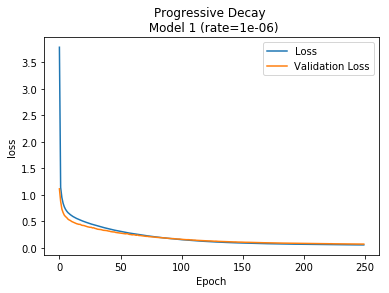

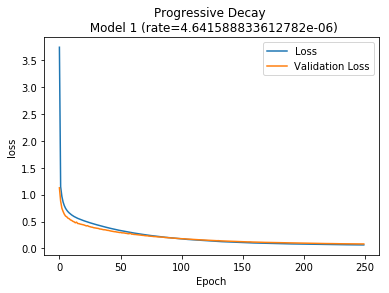

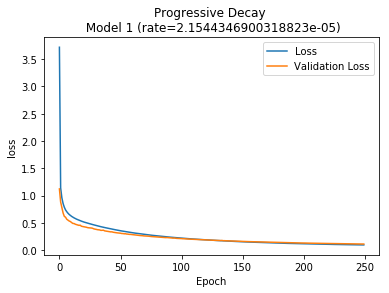

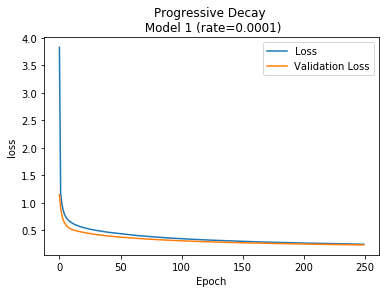

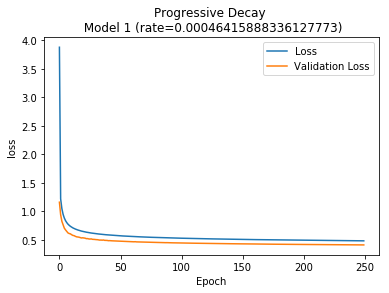

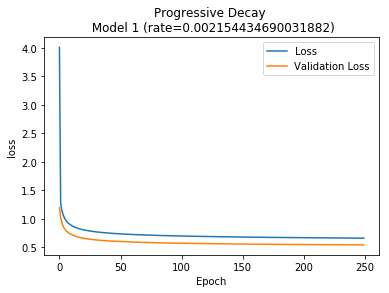

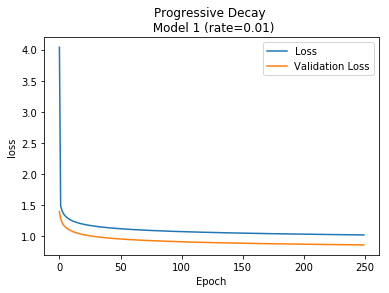

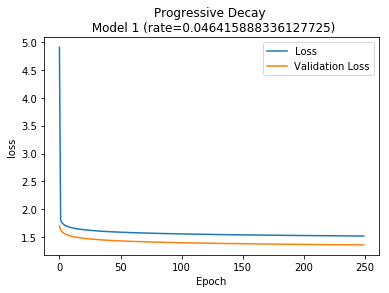

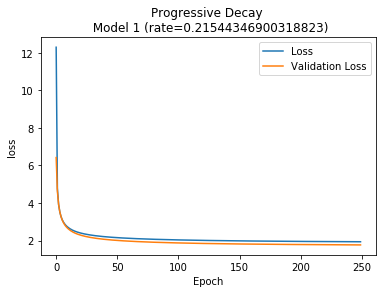

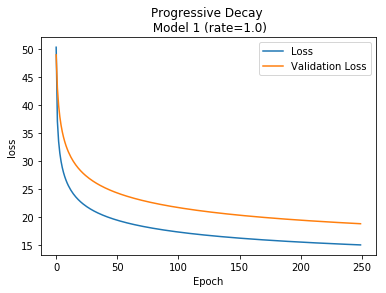

In [49]:
df_aux = pd.read_csv('1-E-1.csv')
df_aux.drop(['Unnamed: 0'],axis=1,inplace=True)

for c in np.split(df_aux.columns,len(df_aux.columns)/2):
    loss,v_loss = c
    rate = loss.strip(')').split('(')[1]
    ylab = loss.split('(')[0]
    # Ploting
    plt.plot(df_aux[loss])
    plt.plot(df_aux[v_loss])
    plt.title('Progressive Decay \n Model 1 (rate='+rate+')')
    plt.xlabel('Epoch')
    plt.ylabel(ylab)
    plt.legend(['Loss', 'Validation Loss'], loc='upper right')
    plt.savefig('Progressive Decay \n Model 1 (rate='+rate+')'+'.png')
    plt.show()

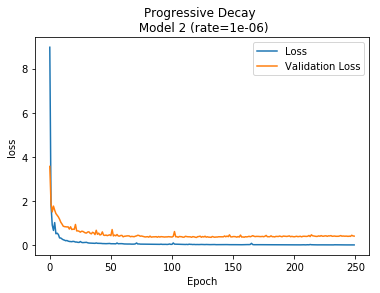

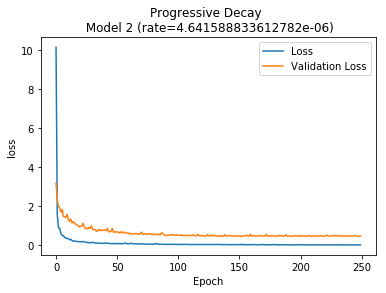

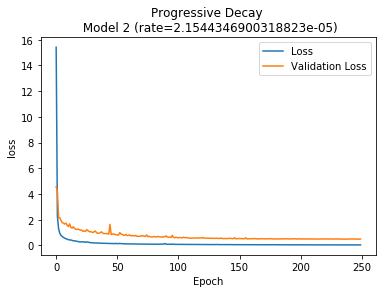

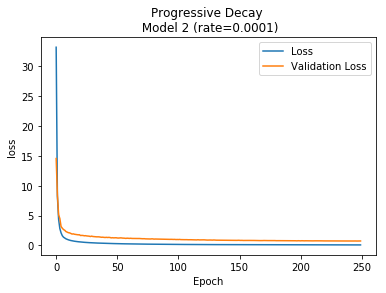

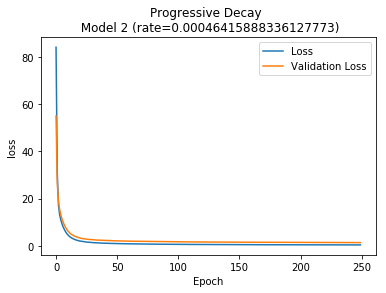

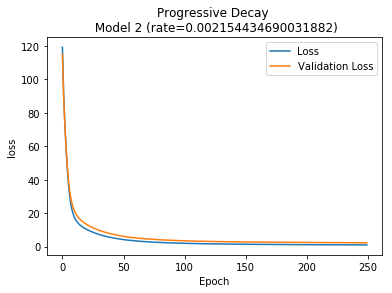

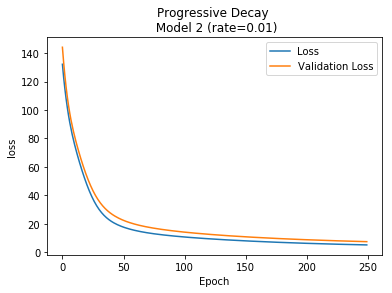

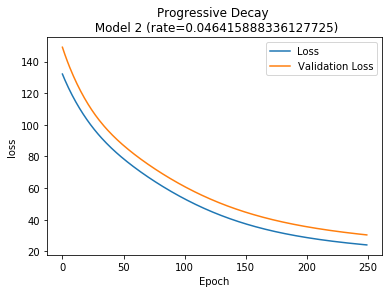

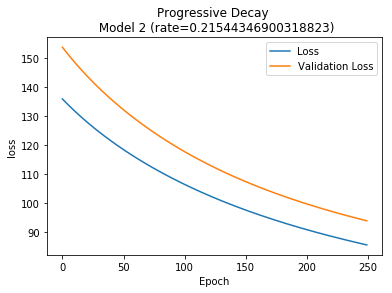

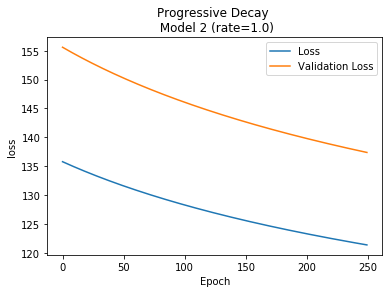

In [50]:
df_aux = pd.read_csv('1-E-2.csv')
df_aux.drop(['Unnamed: 0'],axis=1,inplace=True)

for c in np.split(df_aux.columns,len(df_aux.columns)/2):
    loss,v_loss = c
    rate = loss.strip(')').split('(')[1]
    ylab = loss.split('(')[0]
    # Ploting
    plt.plot(df_aux[loss])
    plt.plot(df_aux[v_loss])
    plt.title('Progressive Decay \n Model 2 (rate='+rate+')')
    plt.xlabel('Epoch')
    plt.ylabel(ylab)
    plt.legend(['Loss', 'Validation Loss'], loc='upper right')
    plt.savefig('Progressive Decay \n Model 2 (rate='+rate+')'+'.png')
    plt.show()

f) Sizes of batchs

In [155]:
from tqdm import tqdm

n_batches = 21
batch_sizes = (np.round(np.linspace(10,X_train_scaled.shape[0],n_batches)))

histories = dict()
histories2 = dict()

for sz in batch_sizes.astype(int):
    print('size:'+str(sz))
    sgd = SGD(lr=0.01)
    # model 1
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=sgd,loss='mean_squared_error')
    history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=0, validation_data=(X_val_scaled, y_val))
    histories['loss('+str(sz)+')'] = history.history['loss']
    histories['val loss('+str(sz)+')'] = history.history['val_loss']
    # model 2
    sgd = SGD(lr=0.001)
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=sgd,loss='mean_squared_error')
    history2 = model.fit(X_train_scaled, y_train, epochs=250,batch_size=sz, verbose=0, validation_data=(X_val_scaled, y_val))
    histories2['loss('+str(sz)+')'] = history2.history['loss']
    histories2['val loss('+str(sz)+')'] = history2.history['val_loss']
    
df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-F-1.csv')
df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-F-2.csv')

size:10
size:497
size:984
size:1470
size:1957
size:2444
size:2930
size:3417
size:3904
size:4391
size:4878
size:5364
size:5851
size:6338
size:6824
size:7311
size:7798
size:8285
size:8772
size:9258
size:9745


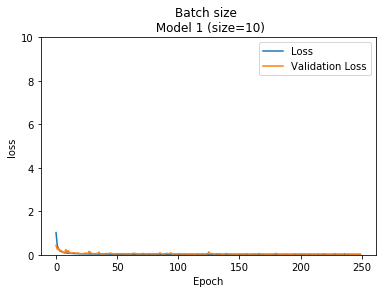

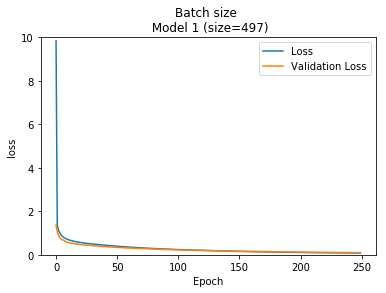

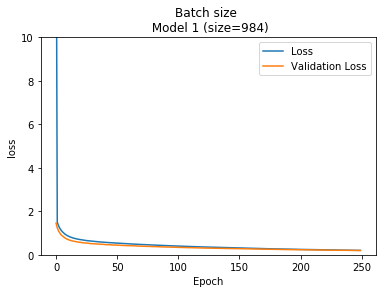

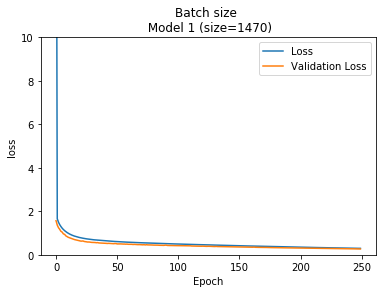

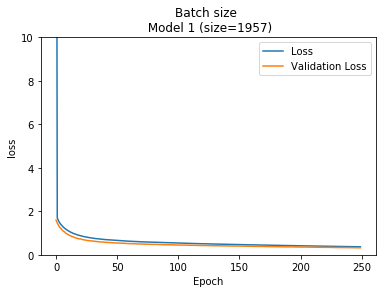

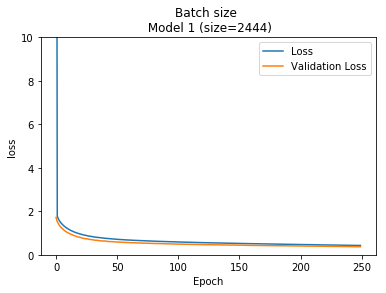

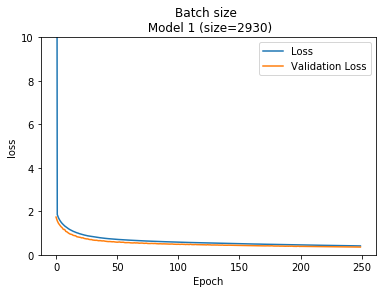

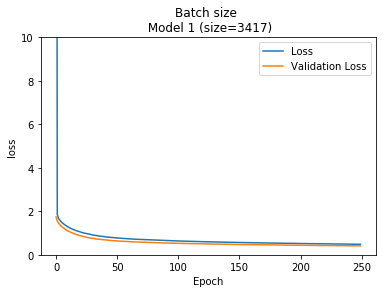

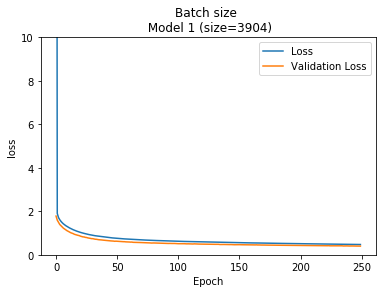

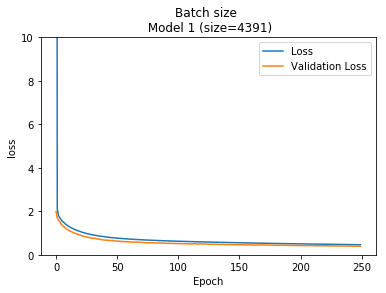

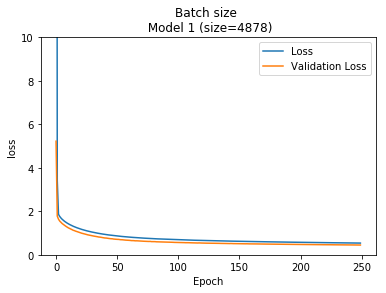

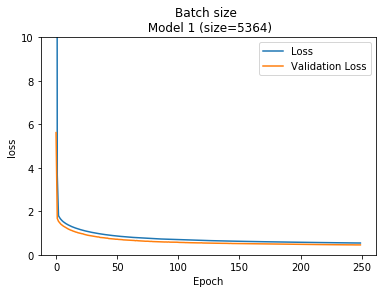

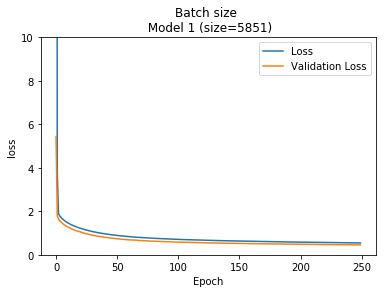

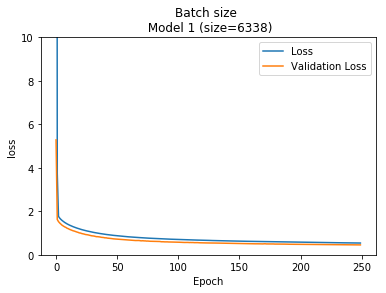

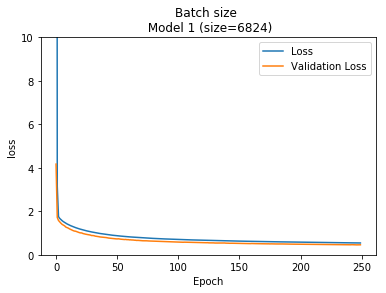

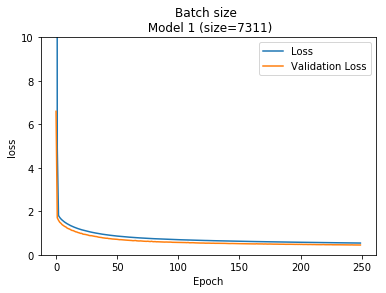

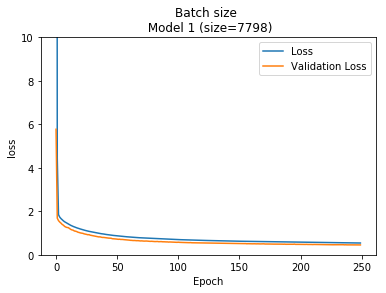

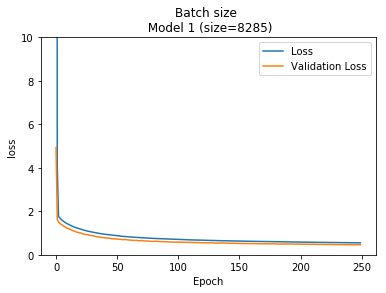

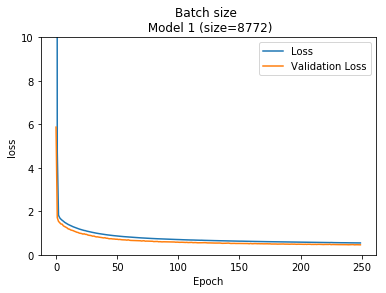

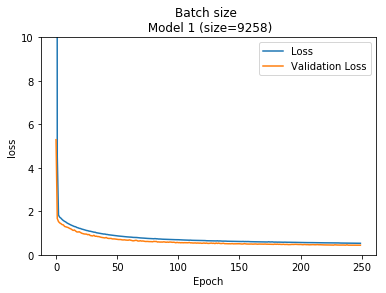

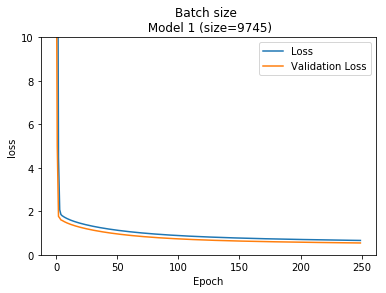

In [57]:
df_aux = pd.read_csv('1-F-1.csv')
df_aux.drop(['Unnamed: 0'],axis=1,inplace=True)

for c in np.split(df_aux.columns,len(df_aux.columns)/2):
    loss,v_loss = c
    rate = loss.strip(')').split('(')[1]
    ylab = loss.split('(')[0]
    # Ploting
    plt.plot(df_aux[loss])
    plt.plot(df_aux[v_loss])
    plt.title('Batch size \n Model 1 (size='+rate+')')
    plt.xlabel('Epoch')
    plt.ylabel(ylab)
    plt.ylim(0,10)
    plt.legend(['Loss', 'Validation Loss'], loc='upper right')
    plt.savefig('Batch Size \n Model 1 (size='+rate+')'+'.png')
    plt.show()

g) Differents Methods

In [150]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta

sz = 32

histories = dict()
histories2 = dict()

# model 1 (Adagrad)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    
moptimizer = Adagrad(lr=0.01)
model.compile(optimizer=moptimizer,loss='mse')
    
history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=1, validation_data=(X_val_scaled, y_val))
histories['loss'] = history.history['loss']
histories['val loss'] = history.history['val_loss']

# model 2 (Adagrad)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 

moptimizer = Adagrad(lr=0.01)
model.compile(optimizer=moptimizer,loss='mse')

history2 = model.fit(X_train_scaled, y_train, epochs=250,batch_size=sz, verbose=1, validation_data=(X_val_scaled, y_val))
histories2['loss'] = history2.history['loss']
histories2['val loss'] = history2.history['val_loss']
    
df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-G-1-Adagrad.csv')
df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-G-2-Adagrad.csv')

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 6s 654us/step - loss: 6.4353 - val_loss: 1.9745
Epoch 2/250
9745/9745 [==============================] - 3s 337us/step - loss: 0.9460 - val_loss: 0.7640
Epoch 3/250
9745/9745 [==============================] - 3s 317us/step - loss: 0.4517 - val_loss: 0.4422
Epoch 4/250
9745/9745 [==============================] - 4s 361us/step - loss: 0.2943 - val_loss: 0.3037
Epoch 5/250
9745/9745 [==============================] - 3s 322us/step - loss: 0.2209 - val_loss: 0.2264
Epoch 6/250
9745/9745 [==============================] - 3s 327us/step - loss: 0.1816 - val_loss: 0.1947
Epoch 7/250
9745/9745 [==============================] - 3s 302us/step - loss: 0.1576 - val_loss: 0.1718
Epoch 8/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.1380 - val_loss: 0.1560
Epoch 9/250
9745/9745 [==============================] - 3s 359us/step - loss: 0.1255 - val_loss: 0.1431
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 3s 280us/step - loss: 0.0318 - val_loss: 0.0586
Epoch 79/250
9745/9745 [==============================] - 3s 280us/step - loss: 0.0316 - val_loss: 0.0575
Epoch 80/250
9745/9745 [==============================] - 3s 291us/step - loss: 0.0314 - val_loss: 0.0581
Epoch 81/250
9745/9745 [==============================] - 3s 290us/step - loss: 0.0312 - val_loss: 0.0583
Epoch 82/250
9745/9745 [==============================] - 3s 278us/step - loss: 0.0309 - val_loss: 0.0580
Epoch 83/250
9745/9745 [==============================] - 3s 278us/step - loss: 0.0307 - val_loss: 0.0573
Epoch 84/250
9745/9745 [==============================] - 3s 279us/step - loss: 0.0306 - val_loss: 0.0566
Epoch 85/250
9745/9745 [==============================] - 3s 279us/step - loss: 0.0302 - val_loss: 0.0567
Epoch 86/250
9745/9745 [==============================] - 3s 281us/step - loss: 0.0302 - val_loss: 0.0569
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 3s 281us/step - loss: 0.0214 - val_loss: 0.0519
Epoch 156/250
9745/9745 [==============================] - 3s 279us/step - loss: 0.0214 - val_loss: 0.0519
Epoch 157/250
9745/9745 [==============================] - 3s 278us/step - loss: 0.0212 - val_loss: 0.0516
Epoch 158/250
9745/9745 [==============================] - 3s 279us/step - loss: 0.0212 - val_loss: 0.0518
Epoch 159/250
9745/9745 [==============================] - 3s 280us/step - loss: 0.0211 - val_loss: 0.0515
Epoch 160/250
9745/9745 [==============================] - 3s 280us/step - loss: 0.0211 - val_loss: 0.0509
Epoch 161/250
9745/9745 [==============================] - 3s 280us/step - loss: 0.0210 - val_loss: 0.0513
Epoch 162/250
9745/9745 [==============================] - 3s 280us/step - loss: 0.0210 - val_loss: 0.0511
Epoch 163/250
9745/9745 [==============================] - 3s 308us/step - loss: 0.0208 - val_loss: 0.0514
Epoch 164/250
9745/9745 [============

Epoch 58/250
9745/9745 [==============================] - 3s 280us/step - loss: 0.0618 - val_loss: 0.4269
Epoch 59/250
9745/9745 [==============================] - 3s 279us/step - loss: 0.0617 - val_loss: 0.4482
Epoch 60/250
9745/9745 [==============================] - 3s 280us/step - loss: 0.0624 - val_loss: 0.4336
Epoch 61/250
9745/9745 [==============================] - 3s 279us/step - loss: 0.0591 - val_loss: 0.4225
Epoch 62/250
9745/9745 [==============================] - 3s 280us/step - loss: 0.0610 - val_loss: 0.5177
Epoch 63/250
9745/9745 [==============================] - 3s 280us/step - loss: 0.0605 - val_loss: 0.4465
Epoch 64/250
9745/9745 [==============================] - 3s 279us/step - loss: 0.0594 - val_loss: 0.4501
Epoch 65/250
9745/9745 [==============================] - 3s 279us/step - loss: 0.0578 - val_loss: 0.4608
Epoch 66/250
9745/9745 [==============================] - 3s 280us/step - loss: 0.0573 - val_loss: 0.4455
Epoch 67/250
9745/9745 [======================

Epoch 135/250
9745/9745 [==============================] - 3s 291us/step - loss: 0.0342 - val_loss: 0.4582
Epoch 136/250
9745/9745 [==============================] - 3s 294us/step - loss: 0.0342 - val_loss: 0.4613
Epoch 137/250
9745/9745 [==============================] - 3s 283us/step - loss: 0.0341 - val_loss: 0.4504
Epoch 138/250
9745/9745 [==============================] - 3s 281us/step - loss: 0.0338 - val_loss: 0.4560
Epoch 139/250
9745/9745 [==============================] - 3s 287us/step - loss: 0.0333 - val_loss: 0.4440
Epoch 140/250
9745/9745 [==============================] - 3s 282us/step - loss: 0.0327 - val_loss: 0.4483
Epoch 141/250
9745/9745 [==============================] - 3s 282us/step - loss: 0.0332 - val_loss: 0.4528
Epoch 142/250
9745/9745 [==============================] - 3s 282us/step - loss: 0.0335 - val_loss: 0.4485
Epoch 143/250
9745/9745 [==============================] - 3s 290us/step - loss: 0.0346 - val_loss: 0.4537
Epoch 144/250
9745/9745 [============

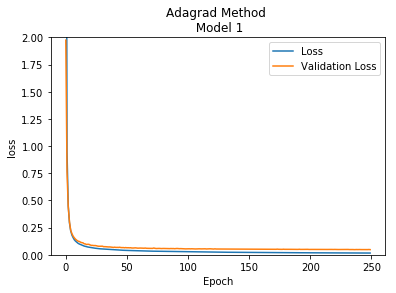

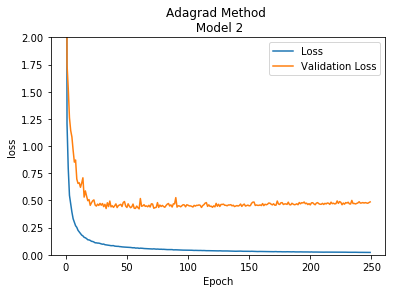

In [69]:
# Mode 1
df_aux = pd.read_csv('1-G-1-Adagrad.csv')
df_aux.drop(['Unnamed: 0'],axis=1,inplace=True)   
cols = df_aux.columns
plt.plot(df_aux[cols[0]])
plt.plot(df_aux[cols[1]])
plt.title('Adagrad Method \n Model 1')
plt.xlabel('Epoch')
plt.ylabel(ylab)
plt.ylim(0,2)
plt.legend(['Loss', 'Validation Loss'], loc='upper right')
plt.savefig('Adagrad \n Model 1')
plt.show()

# Model 2
df_aux = pd.read_csv('1-G-2-Adagrad.csv')
df_aux.drop(['Unnamed: 0'],axis=1,inplace=True)   
cols = df_aux.columns
plt.plot(df_aux[cols[0]])
plt.plot(df_aux[cols[1]])
plt.title('Adagrad Method \n Model 2')
plt.xlabel('Epoch')
plt.ylabel(ylab)
plt.ylim(0,2)
plt.legend(['Loss', 'Validation Loss'], loc='upper right')
plt.savefig('Adagrad \n Model 2')
plt.show()

In [151]:
# model 1 (Adam)

histories = dict()
histories2 = dict()

model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    
moptimizer = Adam(lr=0.01)
model.compile(optimizer=moptimizer,loss='mse')
    
history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=1, validation_data=(X_val_scaled, y_val))
histories['loss'] = history.history['loss']
histories['val loss'] = history.history['val_loss']

# model 2 (Adam)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 

moptimizer = Adam(lr=0.01)
model.compile(optimizer=moptimizer,loss='mse')

history2 = model.fit(X_train_scaled, y_train, epochs=250,batch_size=sz, verbose=1, validation_data=(X_val_scaled, y_val))
histories2['loss'] = history2.history['loss']
histories2['val loss'] = history2.history['val_loss']
    
df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-G-1-Adam.csv')
df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-G-2-Adam.csv')

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 6s 580us/step - loss: 2.6230 - val_loss: 0.2226
Epoch 2/250
9745/9745 [==============================] - 3s 298us/step - loss: 0.2079 - val_loss: 0.2343
Epoch 3/250
9745/9745 [==============================] - 3s 297us/step - loss: 0.1999 - val_loss: 0.2029
Epoch 4/250
9745/9745 [==============================] - 3s 299us/step - loss: 0.1956 - val_loss: 0.2074
Epoch 5/250
9745/9745 [==============================] - 3s 300us/step - loss: 0.1999 - val_loss: 0.2955
Epoch 6/250
9745/9745 [==============================] - 3s 299us/step - loss: 0.2021 - val_loss: 0.1879
Epoch 7/250
9745/9745 [==============================] - 3s 300us/step - loss: 0.2079 - val_loss: 0.3052
Epoch 8/250
9745/9745 [==============================] - 3s 298us/step - loss: 0.2331 - val_loss: 0.2830
Epoch 9/250
9745/9745 [==============================] - 3s 296us/step - loss: 0.2376 - val_loss: 0.2657
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 3s 294us/step - loss: 0.1596 - val_loss: 0.1580
Epoch 79/250
9745/9745 [==============================] - 3s 297us/step - loss: 0.1547 - val_loss: 0.2941
Epoch 80/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.1788 - val_loss: 0.1902
Epoch 81/250
9745/9745 [==============================] - 3s 296us/step - loss: 0.1614 - val_loss: 0.1693
Epoch 82/250
9745/9745 [==============================] - 3s 297us/step - loss: 0.1646 - val_loss: 0.1567
Epoch 83/250
9745/9745 [==============================] - 3s 296us/step - loss: 0.1771 - val_loss: 0.1728
Epoch 84/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.2004 - val_loss: 0.2582
Epoch 85/250
9745/9745 [==============================] - 3s 298us/step - loss: 0.2123 - val_loss: 0.2547
Epoch 86/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.1784 - val_loss: 0.2091
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 3s 298us/step - loss: 0.1379 - val_loss: 0.1308
Epoch 156/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.1343 - val_loss: 0.2247
Epoch 157/250
9745/9745 [==============================] - 3s 296us/step - loss: 0.1405 - val_loss: 0.1535
Epoch 158/250
9745/9745 [==============================] - 3s 296us/step - loss: 0.1483 - val_loss: 0.1939
Epoch 159/250
9745/9745 [==============================] - 3s 297us/step - loss: 0.1621 - val_loss: 0.2169
Epoch 160/250
9745/9745 [==============================] - 3s 298us/step - loss: 0.1535 - val_loss: 0.2440
Epoch 161/250
9745/9745 [==============================] - 3s 300us/step - loss: 0.1885 - val_loss: 0.2016
Epoch 162/250
9745/9745 [==============================] - 3s 296us/step - loss: 0.1584 - val_loss: 0.1384
Epoch 163/250
9745/9745 [==============================] - 3s 294us/step - loss: 0.1634 - val_loss: 0.1764
Epoch 164/250
9745/9745 [============

9745/9745 [==============================] - 3s 307us/step - loss: 0.7137 - val_loss: 1.1330
Epoch 58/250
9745/9745 [==============================] - 3s 309us/step - loss: 0.9488 - val_loss: 0.8129
Epoch 59/250
9745/9745 [==============================] - 3s 308us/step - loss: 0.3231 - val_loss: 0.8137
Epoch 60/250
9745/9745 [==============================] - 3s 312us/step - loss: 0.4991 - val_loss: 1.2439
Epoch 61/250
9745/9745 [==============================] - 3s 311us/step - loss: 3124.2340 - val_loss: 140.8398
Epoch 62/250
9745/9745 [==============================] - 3s 308us/step - loss: 31.1924 - val_loss: 8.2515
Epoch 63/250
9745/9745 [==============================] - 3s 304us/step - loss: 96.3768 - val_loss: 194.1510
Epoch 64/250
9745/9745 [==============================] - 3s 306us/step - loss: 115.6108 - val_loss: 8.9676
Epoch 65/250
9745/9745 [==============================] - 3s 304us/step - loss: 51.1971 - val_loss: 65.7126
Epoch 66/250
9745/9745 [======================

Epoch 209/250
9745/9745 [==============================] - 3s 311us/step - loss: 6.4350 - val_loss: 0.7545
Epoch 210/250
9745/9745 [==============================] - 3s 312us/step - loss: 4.7889 - val_loss: 3.3733
Epoch 211/250
9745/9745 [==============================] - 3s 312us/step - loss: 2.8826 - val_loss: 7.0835
Epoch 212/250
9745/9745 [==============================] - 3s 308us/step - loss: 4.3516 - val_loss: 0.7024
Epoch 213/250
9745/9745 [==============================] - 3s 314us/step - loss: 1.5318 - val_loss: 0.8289
Epoch 214/250
9745/9745 [==============================] - 3s 312us/step - loss: 1.8368 - val_loss: 20.1970
Epoch 215/250
9745/9745 [==============================] - 3s 310us/step - loss: 1239.6669 - val_loss: 44.7748
Epoch 216/250
9745/9745 [==============================] - 3s 311us/step - loss: 20.6439 - val_loss: 7.1787
Epoch 217/250
9745/9745 [==============================] - 3s 311us/step - loss: 22.0826 - val_loss: 13.0591
Epoch 218/250
9745/9745 [====

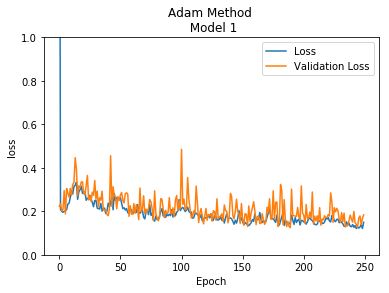

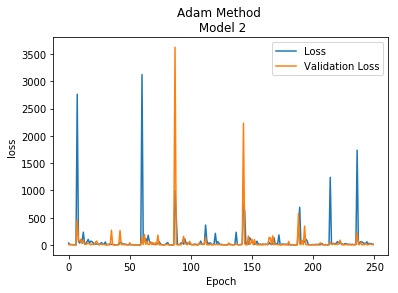

In [83]:
# Mode 1
df_aux = pd.read_csv('1-G-1-Adam.csv')
df_aux.drop(['Unnamed: 0'],axis=1,inplace=True)   
cols = df_aux.columns
plt.plot(df_aux[cols[0]])
plt.plot(df_aux[cols[1]])
plt.title('Adam Method \n Model 1')
plt.xlabel('Epoch')
plt.ylabel(ylab)
plt.ylim(0,1)
plt.legend(['Loss', 'Validation Loss'], loc='upper right')
plt.savefig('Adam \n Model 1')
plt.show()

# Model 2
df_aux = pd.read_csv('1-G-2-Adam.csv')
df_aux.drop(['Unnamed: 0'],axis=1,inplace=True)   
cols = df_aux.columns
plt.plot(df_aux[cols[0]])
plt.plot(df_aux[cols[1]])
plt.title('Adam Method \n Model 2')
plt.xlabel('Epoch')
plt.ylabel(ylab)
#plt.ylim(0,2)
plt.legend(['Loss', 'Validation Loss'], loc='upper right')
plt.savefig('Adam \n Model 2')
plt.show()

In [152]:
# model 1 (Adadelta)
histories = dict()
histories2 = dict()

model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    
moptimizer = Adadelta(lr=0.01)
model.compile(optimizer=moptimizer,loss='mse')
    
history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=1, validation_data=(X_val_scaled, y_val))
histories['loss'] = history.history['loss']
histories['val loss'] = history.history['val_loss']

# model 2 (Adadelta)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 

moptimizer = Adadelta(lr=0.001)
model.compile(optimizer=moptimizer,loss='mse')

history2 = model.fit(X_train_scaled, y_train, epochs=250,batch_size=sz, verbose=1, validation_data=(X_val_scaled, y_val))
histories2['loss'] = history2.history['loss']
histories2['val loss'] = history2.history['val_loss']
    
df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-G-1-Adadelta.csv')
df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-G-2-Adadelta.csv')

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 6s 618us/step - loss: 122.5937 - val_loss: 127.0978
Epoch 2/250
9745/9745 [==============================] - 3s 328us/step - loss: 102.7064 - val_loss: 105.8560
Epoch 3/250
9745/9745 [==============================] - 3s 329us/step - loss: 84.0563 - val_loss: 86.0336
Epoch 4/250
9745/9745 [==============================] - 3s 331us/step - loss: 66.6822 - val_loss: 67.6338
Epoch 5/250
9745/9745 [==============================] - 3s 333us/step - loss: 50.9249 - val_loss: 51.0915
Epoch 6/250
9745/9745 [==============================] - 3s 328us/step - loss: 37.3081 - val_loss: 37.0347
Epoch 7/250
9745/9745 [==============================] - 3s 332us/step - loss: 26.1870 - val_loss: 25.7425
Epoch 8/250
9745/9745 [==============================] - 3s 332us/step - loss: 17.6562 - val_loss: 17.3650
Epoch 9/250
9745/9745 [==============================] - 3s 336us/step - loss: 11.5792 - val

Epoch 154/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.1103 - val_loss: 0.1183
Epoch 155/250
9745/9745 [==============================] - 3s 330us/step - loss: 0.1097 - val_loss: 0.1177
Epoch 156/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.1090 - val_loss: 0.1165
Epoch 157/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.1085 - val_loss: 0.1166
Epoch 158/250
9745/9745 [==============================] - 3s 328us/step - loss: 0.1079 - val_loss: 0.1161
Epoch 159/250
9745/9745 [==============================] - 3s 324us/step - loss: 0.1072 - val_loss: 0.1157
Epoch 160/250
9745/9745 [==============================] - 3s 323us/step - loss: 0.1066 - val_loss: 0.1168
Epoch 161/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.1063 - val_loss: 0.1151
Epoch 162/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.1057 - val_loss: 0.1149
Epoch 163/250
9745/9745 [============

9745/9745 [==============================] - 3s 313us/step - loss: 5.8272 - val_loss: 8.3197
Epoch 57/250
9745/9745 [==============================] - 3s 315us/step - loss: 5.7314 - val_loss: 8.2035
Epoch 58/250
9745/9745 [==============================] - 3s 314us/step - loss: 5.6383 - val_loss: 8.0990
Epoch 59/250
9745/9745 [==============================] - 3s 314us/step - loss: 5.5568 - val_loss: 8.0004
Epoch 60/250
9745/9745 [==============================] - 3s 317us/step - loss: 5.4687 - val_loss: 7.9004
Epoch 61/250
9745/9745 [==============================] - 3s 316us/step - loss: 5.3904 - val_loss: 7.8102
Epoch 62/250
9745/9745 [==============================] - 3s 315us/step - loss: 5.3126 - val_loss: 7.7134
Epoch 63/250
9745/9745 [==============================] - 3s 313us/step - loss: 5.2316 - val_loss: 7.6225
Epoch 64/250
9745/9745 [==============================] - 3s 315us/step - loss: 5.1562 - val_loss: 7.5313
Epoch 65/250
9745/9745 [==============================] - 3

9745/9745 [==============================] - 3s 320us/step - loss: 2.5688 - val_loss: 4.3950
Epoch 134/250
9745/9745 [==============================] - 3s 315us/step - loss: 2.5555 - val_loss: 4.3680
Epoch 135/250
9745/9745 [==============================] - 3s 313us/step - loss: 2.5359 - val_loss: 4.3418
Epoch 136/250
9745/9745 [==============================] - 3s 313us/step - loss: 2.5181 - val_loss: 4.3160
Epoch 137/250
9745/9745 [==============================] - 3s 315us/step - loss: 2.5008 - val_loss: 4.3003
Epoch 138/250
9745/9745 [==============================] - 3s 313us/step - loss: 2.4902 - val_loss: 4.2805
Epoch 139/250
9745/9745 [==============================] - 3s 314us/step - loss: 2.4776 - val_loss: 4.2685
Epoch 140/250
9745/9745 [==============================] - 3s 314us/step - loss: 2.4622 - val_loss: 4.2442
Epoch 141/250
9745/9745 [==============================] - 3s 314us/step - loss: 2.4535 - val_loss: 4.2274
Epoch 142/250
9745/9745 [==========================

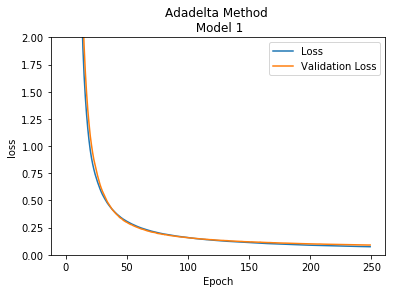

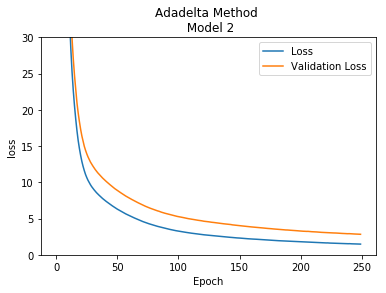

In [82]:
# Mode 1
df_aux = pd.read_csv('1-G-1-Adadelta.csv')
df_aux.drop(['Unnamed: 0'],axis=1,inplace=True)   
cols = df_aux.columns
plt.plot(df_aux[cols[0]])
plt.plot(df_aux[cols[1]])
plt.title('Adadelta Method \n Model 1')
plt.xlabel('Epoch')
plt.ylabel(ylab)
plt.ylim(0,2)
plt.legend(['Loss', 'Validation Loss'], loc='upper right')
plt.savefig('Adadelta \n Model 1')
plt.show()

# Model 2
df_aux = pd.read_csv('1-G-2-Adadelta.csv')
df_aux.drop(['Unnamed: 0'],axis=1,inplace=True)   
cols = df_aux.columns
plt.plot(df_aux[cols[0]])
plt.plot(df_aux[cols[1]])
plt.title('Adadelta Method \n Model 2')
plt.xlabel('Epoch')
plt.ylabel(ylab)
plt.ylim(0,30)
plt.legend(['Loss', 'Validation Loss'], loc='upper right')
plt.savefig('Adadelta \n Model 2')
plt.show()

In [153]:
# model 1 (RMSprop)
histories = dict()
histories2 = dict()

model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    
moptimizer = Adadelta(lr=0.01)
model.compile(optimizer=moptimizer,loss='mse')
    
history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=1, validation_data=(X_val_scaled, y_val))
histories['loss'] = history.history['loss']
histories['val loss'] = history.history['val_loss']

# model 2 (RMSprop)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 

moptimizer = RMSprop(lr=0.01)
model.compile(optimizer=moptimizer,loss='mse')

history2 = model.fit(X_train_scaled, y_train, epochs=250,batch_size=sz, verbose=1, validation_data=(X_val_scaled, y_val))
histories2['loss'] = history2.history['loss']
histories2['val loss'] = history2.history['val_loss']
    
print('hola')
df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-G-1-RMSprop.csv')
df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-G-2-RMSprop.csv')

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 6s 614us/step - loss: 131.2019 - val_loss: 136.8894
Epoch 2/250
9745/9745 [==============================] - 3s 318us/step - loss: 111.0224 - val_loss: 115.0703
Epoch 3/250
9745/9745 [==============================] - 3s 326us/step - loss: 91.4928 - val_loss: 94.2229
Epoch 4/250
9745/9745 [==============================] - 3s 318us/step - loss: 73.1094 - val_loss: 74.7694
Epoch 5/250
9745/9745 [==============================] - 3s 318us/step - loss: 56.4551 - val_loss: 57.2395
Epoch 6/250
9745/9745 [==============================] - 3s 318us/step - loss: 41.9289 - val_loss: 42.2011
Epoch 7/250
9745/9745 [==============================] - 3s 319us/step - loss: 29.9990 - val_loss: 29.9525
Epoch 8/250
9745/9745 [==============================] - 3s 319us/step - loss: 20.6477 - val_loss: 20.4348
Epoch 9/250
9745/9745 [==============================] - 3s 319us/step - loss: 13.7754 - val

Epoch 154/250
9745/9745 [==============================] - 3s 318us/step - loss: 0.1080 - val_loss: 0.1147
Epoch 155/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.1074 - val_loss: 0.1140
Epoch 156/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.1069 - val_loss: 0.1150
Epoch 157/250
9745/9745 [==============================] - 3s 321us/step - loss: 0.1064 - val_loss: 0.1134
Epoch 158/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.1058 - val_loss: 0.1133
Epoch 159/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.1052 - val_loss: 0.1136
Epoch 160/250
9745/9745 [==============================] - 3s 320us/step - loss: 0.1048 - val_loss: 0.1125
Epoch 161/250
9745/9745 [==============================] - 3s 319us/step - loss: 0.1043 - val_loss: 0.1121
Epoch 162/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.1037 - val_loss: 0.1111
Epoch 163/250
9745/9745 [============

9745/9745 [==============================] - 2s 256us/step - loss: 130.4291 - val_loss: 21.6502
Epoch 56/250
9745/9745 [==============================] - 3s 286us/step - loss: 304.7161 - val_loss: 168.3811
Epoch 57/250
9745/9745 [==============================] - 3s 258us/step - loss: 108.2498 - val_loss: 19.8364
Epoch 58/250
9745/9745 [==============================] - 2s 256us/step - loss: 81.7784 - val_loss: 73.1726
Epoch 59/250
9745/9745 [==============================] - 3s 257us/step - loss: 147.4183 - val_loss: 21.9791
Epoch 60/250
9745/9745 [==============================] - 2s 255us/step - loss: 146.1241 - val_loss: 59.0749
Epoch 61/250
9745/9745 [==============================] - 2s 254us/step - loss: 67.9283 - val_loss: 819.2692
Epoch 62/250
9745/9745 [==============================] - 3s 258us/step - loss: 89.8609 - val_loss: 338.6197
Epoch 63/250
9745/9745 [==============================] - 2s 256us/step - loss: 98.5570 - val_loss: 75.4018
Epoch 64/250
9745/9745 [=========

Epoch 130/250
9745/9745 [==============================] - 3s 257us/step - loss: 99.4107 - val_loss: 116.8920
Epoch 131/250
9745/9745 [==============================] - 2s 256us/step - loss: 196.2087 - val_loss: 22.4854
Epoch 132/250
9745/9745 [==============================] - 2s 257us/step - loss: 154.8123 - val_loss: 187.6785
Epoch 133/250
9745/9745 [==============================] - 2s 255us/step - loss: 255.1747 - val_loss: 449.4140
Epoch 134/250
9745/9745 [==============================] - 3s 258us/step - loss: 111.5932 - val_loss: 340.7269
Epoch 135/250
9745/9745 [==============================] - 3s 262us/step - loss: 90.3451 - val_loss: 74.3630
Epoch 136/250
9745/9745 [==============================] - 3s 259us/step - loss: 248.1092 - val_loss: 6969.2375
Epoch 137/250
9745/9745 [==============================] - 2s 255us/step - loss: 186.5089 - val_loss: 49.1679
Epoch 138/250
9745/9745 [==============================] - 3s 257us/step - loss: 168.7313 - val_loss: 237.1795
Epoch

9745/9745 [==============================] - 3s 257us/step - loss: 191.5473 - val_loss: 4029.5120
Epoch 205/250
9745/9745 [==============================] - 3s 258us/step - loss: 85.6197 - val_loss: 432.9340
Epoch 206/250
9745/9745 [==============================] - 2s 255us/step - loss: 301.0978 - val_loss: 1378.9416
Epoch 207/250
9745/9745 [==============================] - 2s 255us/step - loss: 124.2151 - val_loss: 411.5870
Epoch 208/250
9745/9745 [==============================] - 2s 256us/step - loss: 249.2819 - val_loss: 365.3505
Epoch 209/250
9745/9745 [==============================] - 3s 257us/step - loss: 137.0891 - val_loss: 717.9318
Epoch 210/250
9745/9745 [==============================] - 3s 259us/step - loss: 254.1812 - val_loss: 343.4717
Epoch 211/250
9745/9745 [==============================] - 2s 255us/step - loss: 229.9063 - val_loss: 796.9450
Epoch 212/250
9745/9745 [==============================] - 3s 266us/step - loss: 129.7461 - val_loss: 233.4904
Epoch 213/250


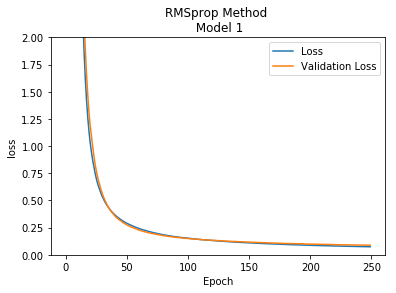

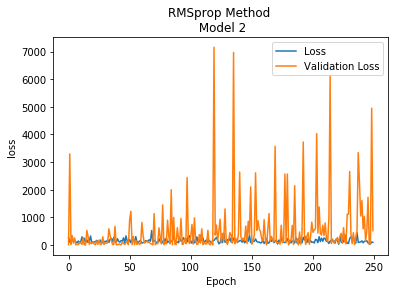

In [81]:
# Mode 1
df_aux = pd.read_csv('1-G-1-RMSprop.csv')
df_aux.drop(['Unnamed: 0'],axis=1,inplace=True)   
cols = df_aux.columns
plt.plot(df_aux[cols[0]])
plt.plot(df_aux[cols[1]])
plt.title('RMSprop Method \n Model 1')
plt.xlabel('Epoch')
plt.ylabel(ylab)
plt.ylim(0,2)
plt.legend(['Loss', 'Validation Loss'], loc='upper right')
plt.savefig('RMSprop \n Model 1')
plt.show()

# Model 2
df_aux = pd.read_csv('1-G-2-RMSprop.csv')
df_aux.drop(['Unnamed: 0'],axis=1,inplace=True)   
cols = df_aux.columns
plt.plot(df_aux[cols[0]])
plt.plot(df_aux[cols[1]])
plt.title('RMSprop Method \n Model 2')
plt.xlabel('Epoch')
plt.ylabel(ylab)
#plt.ylim(0,2)
plt.legend(['Loss', 'Validation Loss'], loc='upper right')
plt.savefig('RMSprop \n Model 2')
plt.show()

In [59]:
# model 1 (SGD)
histories = dict()
histories2 = dict()
sz = 32

model = Sequential()
print(X_val_scaled.size, y_val.size)
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    
moptimizer = SGD(lr=0.01)
model.compile(optimizer=moptimizer,loss='mse')
    
history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=1, validation_data=(X_val_scaled, y_val))
histories['loss'] = history.history['loss']
histories['val loss'] = history.history['val_loss']

# model 2 (SGD)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 

moptimizer = SGD(lr=0.001)
model.compile(optimizer=moptimizer,loss='mse')

history2 = model.fit(X_train_scaled, y_train, epochs=250,batch_size=sz, verbose=1, validation_data=(X_val_scaled, y_val))
histories2['loss'] = history2.history['loss']
histories2['val loss'] = history2.history['val_loss']
    
df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-G-1-SGD.csv')
df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-G-2-SGD.csv')

5176500 4060
Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 3s 332us/step - loss: 1.5813 - val_loss: 0.5682
Epoch 2/250
9745/9745 [==============================] - 2s 219us/step - loss: 0.6120 - val_loss: 0.5243
Epoch 3/250
9745/9745 [==============================] - 3s 292us/step - loss: 0.5135 - val_loss: 0.4701
Epoch 4/250
9745/9745 [==============================] - 3s 332us/step - loss: 0.4354 - val_loss: 0.3271
Epoch 5/250
9745/9745 [==============================] - 3s 346us/step - loss: 0.3765 - val_loss: 0.2982
Epoch 6/250
9745/9745 [==============================] - 2s 252us/step - loss: 0.3247 - val_loss: 0.2873
Epoch 7/250
9745/9745 [==============================] - 2s 256us/step - loss: 0.2859 - val_loss: 0.2798
Epoch 8/250
9745/9745 [==============================] - 2s 242us/step - loss: 0.2549 - val_loss: 0.2221
Epoch 9/250
9745/9745 [==============================] - 2s 207us/step - loss: 0.2229 - val_loss: 0

Epoch 78/250
9745/9745 [==============================] - 2s 196us/step - loss: 0.0320 - val_loss: 0.0427
Epoch 79/250
9745/9745 [==============================] - 2s 205us/step - loss: 0.0302 - val_loss: 0.0479
Epoch 80/250
9745/9745 [==============================] - 2s 194us/step - loss: 0.0308 - val_loss: 0.0422
Epoch 81/250
9745/9745 [==============================] - 2s 193us/step - loss: 0.0299 - val_loss: 0.0494
Epoch 82/250
9745/9745 [==============================] - 2s 215us/step - loss: 0.0292 - val_loss: 0.0464
Epoch 83/250
9745/9745 [==============================] - 2s 197us/step - loss: 0.0306 - val_loss: 0.0599
Epoch 84/250
9745/9745 [==============================] - 2s 199us/step - loss: 0.0306 - val_loss: 0.0476
Epoch 85/250
9745/9745 [==============================] - 2s 202us/step - loss: 0.0293 - val_loss: 0.0422
Epoch 86/250
9745/9745 [==============================] - 2s 187us/step - loss: 0.0289 - val_loss: 0.0651
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 2s 216us/step - loss: 0.0216 - val_loss: 0.0492
Epoch 156/250
9745/9745 [==============================] - 2s 220us/step - loss: 0.0213 - val_loss: 0.0357
Epoch 157/250
9745/9745 [==============================] - 3s 258us/step - loss: 0.0211 - val_loss: 0.0377
Epoch 158/250
9745/9745 [==============================] - 3s 261us/step - loss: 0.0209 - val_loss: 0.0600
Epoch 159/250
9745/9745 [==============================] - 2s 233us/step - loss: 0.0212 - val_loss: 0.0378
Epoch 160/250
9745/9745 [==============================] - 2s 229us/step - loss: 0.0209 - val_loss: 0.0386
Epoch 161/250
9745/9745 [==============================] - 2s 230us/step - loss: 0.0209 - val_loss: 0.0364
Epoch 162/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0206 - val_loss: 0.0373
Epoch 163/250
9745/9745 [==============================] - 2s 223us/step - loss: 0.0208 - val_loss: 0.0482
Epoch 164/250
9745/9745 [============

Epoch 58/250
9745/9745 [==============================] - 2s 192us/step - loss: 0.0831 - val_loss: 0.4093
Epoch 59/250
9745/9745 [==============================] - 2s 222us/step - loss: 0.0739 - val_loss: 0.3761
Epoch 60/250
9745/9745 [==============================] - 2s 225us/step - loss: 0.0743 - val_loss: 0.3912
Epoch 61/250
9745/9745 [==============================] - 2s 185us/step - loss: 0.0867 - val_loss: 0.3565
Epoch 62/250
9745/9745 [==============================] - 2s 181us/step - loss: 0.0745 - val_loss: 0.3507
Epoch 63/250
9745/9745 [==============================] - 2s 202us/step - loss: 0.0679 - val_loss: 0.4029
Epoch 64/250
9745/9745 [==============================] - 2s 192us/step - loss: 0.0674 - val_loss: 0.3664
Epoch 65/250
9745/9745 [==============================] - 2s 178us/step - loss: 0.0755 - val_loss: 0.4225
Epoch 66/250
9745/9745 [==============================] - 2s 222us/step - loss: 0.0654 - val_loss: 0.4317
Epoch 67/250
9745/9745 [======================

Epoch 135/250
9745/9745 [==============================] - 2s 222us/step - loss: 0.0379 - val_loss: 0.3777
Epoch 136/250
9745/9745 [==============================] - 2s 226us/step - loss: 0.0371 - val_loss: 0.4039
Epoch 137/250
9745/9745 [==============================] - 2s 194us/step - loss: 0.0364 - val_loss: 0.3772
Epoch 138/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0437 - val_loss: 0.3485
Epoch 139/250
9745/9745 [==============================] - 2s 200us/step - loss: 0.0418 - val_loss: 0.3693
Epoch 140/250
9745/9745 [==============================] - 2s 213us/step - loss: 0.0370 - val_loss: 0.3529
Epoch 141/250
9745/9745 [==============================] - 2s 239us/step - loss: 0.0356 - val_loss: 0.3493
Epoch 142/250
9745/9745 [==============================] - 2s 231us/step - loss: 0.0346 - val_loss: 0.3703
Epoch 143/250
9745/9745 [==============================] - 2s 202us/step - loss: 0.0345 - val_loss: 0.3750
Epoch 144/250
9745/9745 [============

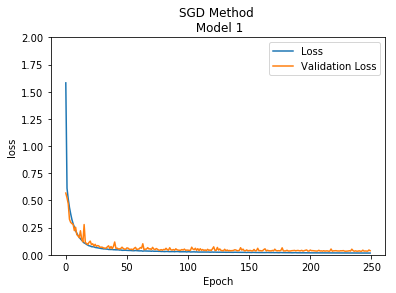

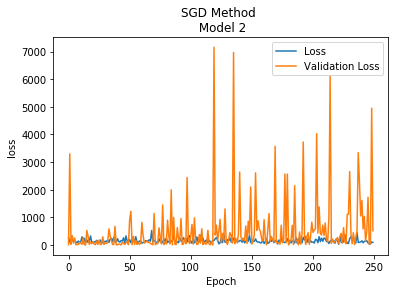

In [84]:
# Mode 1
df_aux = pd.read_csv('1-G-1-SGD.csv')
df_aux.drop(['Unnamed: 0'],axis=1,inplace=True)   
cols = df_aux.columns
plt.plot(df_aux[cols[0]])
plt.plot(df_aux[cols[1]])
plt.title('SGD Method \n Model 1')
plt.xlabel('Epoch')
plt.ylabel(ylab)
plt.ylim(0,2)
plt.legend(['Loss', 'Validation Loss'], loc='upper right')
plt.savefig('SGD \n Model 1')
plt.show()

# Model 2
df_aux = pd.read_csv('1-G-2-RMSprop.csv')
df_aux.drop(['Unnamed: 0'],axis=1,inplace=True)   
cols = df_aux.columns
plt.plot(df_aux[cols[0]])
plt.plot(df_aux[cols[1]])
plt.title('SGD Method \n Model 2')
plt.xlabel('Epoch')
plt.ylabel(ylab)
#plt.ylim(0,2)
plt.legend(['Loss', 'Validation Loss'], loc='upper right')
plt.savefig('SGD \n Model 2')
plt.show()

h) Regularizadores

* Para el primer modelo se ve como una buena medida pero para el segundo se ven bastantes movimientos erráticos

In [36]:
from keras import regularizers
model = Sequential()
#la regularization se debe incorporar a cada capa separadamente
idim = X_train_scaled.shape[1]
sz = 64
histories = dict()

# Model 1 L1
model = Sequential()
model.add(Dense(256,input_dim=idim,kernel_initializer='uniform',kernel_regularizer=regularizers.l1(0.01)))
model.add(Activation('sigmoid'))
model.add(Dense(1,kernel_initializer='uniform',kernel_regularizer=regularizers.l1(0.01)))
model.add(Activation('linear'))
model.compile(optimizer=SGD(lr=0.01),loss='mse')
history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=0, validation_data=(X_val_scaled, y_val))
histories['loss'] = history.history['loss']
histories['val loss'] = history.history['val_loss']

model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 

df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-H-1-L1.csv')

# Model 1 L2
model = Sequential()
#la regularization se debe incorporar a cada capa separadamente
idim = X_train_scaled.shape[1]
sz = 64
histories = dict()

# Model 1
model = Sequential()
model.add(Dense(256,input_dim=idim,kernel_initializer='uniform',kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('sigmoid'))
model.add(Dense(1,kernel_initializer='uniform',kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('linear'))
model.compile(optimizer=SGD(lr=0.01),loss='mse')
history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=0, validation_data=(X_val_scaled, y_val))
histories['loss'] = history.history['loss']
histories['val loss'] = history.history['val_loss']

model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 

df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-H-1-L2.csv')

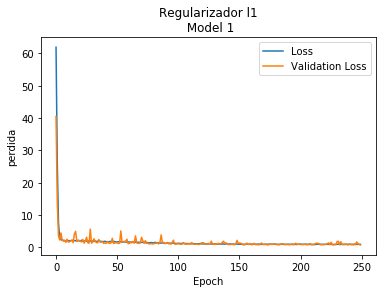

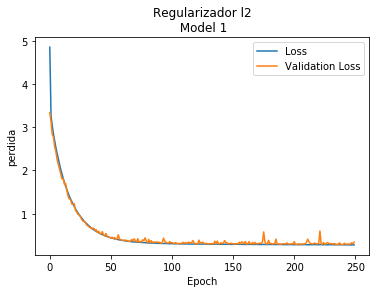

In [46]:
view('1-H-1-L1.csv',1,'Regularizador l1','perdida')
view('1-H-1-L2.csv',1,'Regularizador l2','perdida')

In [37]:
# Model 2 L1
model = Sequential()
model.add(Dense(256,input_dim=idim,kernel_initializer='uniform',kernel_regularizer=regularizers.l1(0.01)))
model.add(Activation('relu'))
model.add(Dense(1, kernel_initializer='uniform',kernel_regularizer=regularizers.l1(0.01)))
model.add(Activation('linear'))
moptimizer = SGD(lr=0.001)
model.compile(optimizer=moptimizer,loss='mse')
history2 = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=0, validation_data=(X_val_scaled, y_val))
histories2['loss'] = history2.history['loss']
histories2['val loss'] = history2.history['val_loss']

df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-H-2-L1.csv')

# Model 2 L2
model = Sequential()
model.add(Dense(256,input_dim=idim,kernel_initializer='uniform',kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dense(1, kernel_initializer='uniform',kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('linear'))
moptimizer = SGD(lr=0.001)
model.compile(optimizer=moptimizer,loss='mse')
history2 = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=0, validation_data=(X_val_scaled, y_val))
histories2['loss'] = history2.history['loss']
histories2['val loss'] = history2.history['val_loss']

df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-H-2-L2.csv')

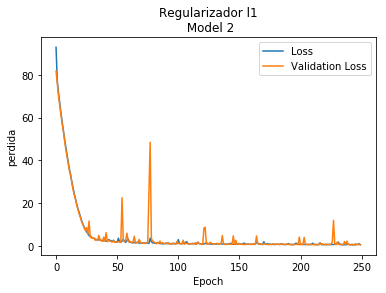

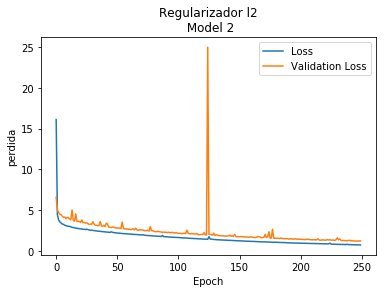

In [47]:
view('1-H-2-L1.csv',2,'Regularizador l1','perdida')
view('1-H-2-L2.csv',2,'Regularizador l2','perdida')

i) Dropout

* Para ambos casos muestra un buen desempeño pero es mucho mayor para el primer modelo (Sigmoidal)

In [30]:
from keras.layers import Dropout

DropOuts = [0.2,0.3,0.5,0.75]

for dp in DropOuts:
    # model 1 (SGD)
    histories = dict()
    histories2 = dict()

    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 

    moptimizer = SGD(lr=0.01)
    model.compile(optimizer=moptimizer,loss='mse')

    history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=0, validation_data=(X_val_scaled, y_val))
    histories['loss'] = history.history['loss']
    histories['val loss'] = history.history['val_loss']

    # model 2 (SGD)
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 

    moptimizer = SGD(lr=0.001)
    model.compile(optimizer=moptimizer,loss='mse')

    history2 = model.fit(X_train_scaled, y_train, epochs=250,batch_size=sz, verbose=0, validation_data=(X_val_scaled, y_val))
    histories2['loss'] = history2.history['loss']
    histories2['val loss'] = history2.history['val_loss']

    df_aux = pd.DataFrame(histories)
    df_aux.to_csv('1-I-1-D'+str(dp)+'.csv')
    df_aux = pd.DataFrame(histories2)
    df_aux.to_csv('1-I-2-D'+str(dp)+'.csv')
    print('Listo DP de '+str(dp))

Listo DP de 0.2
Listo DP de 0.3
Listo DP de 0.5
Listo DP de 0.75


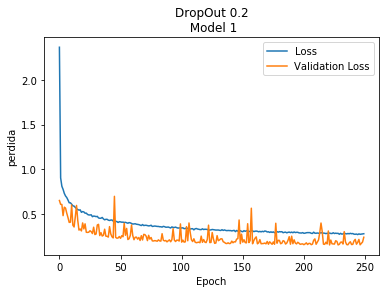

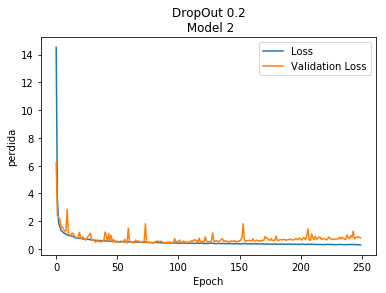

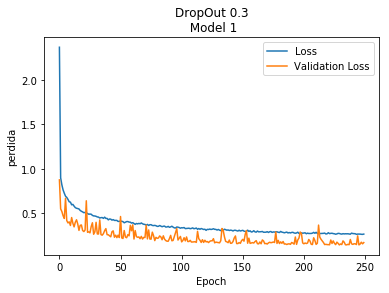

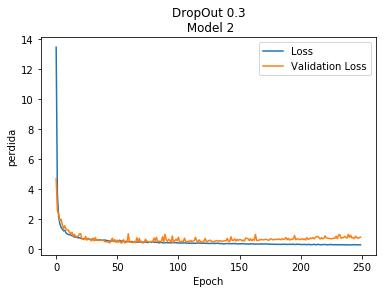

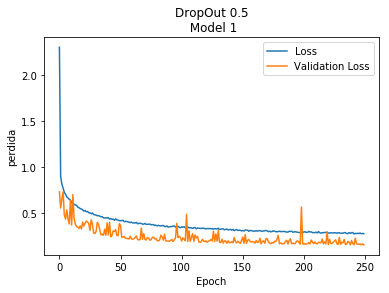

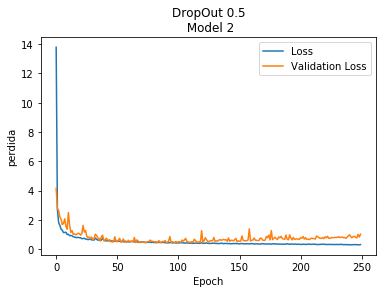

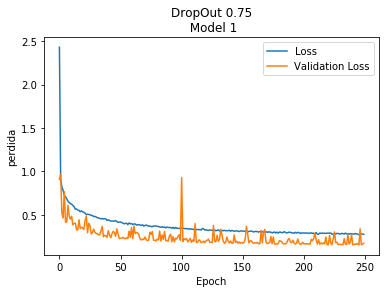

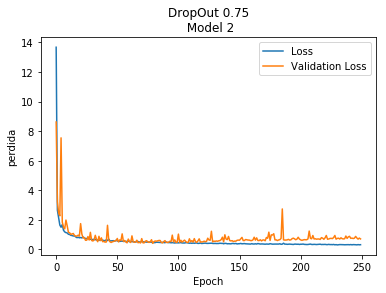

In [48]:
for dp in DropOuts:
    view('1-I-1-D'+str(dp)+'.csv',1,'DropOut '+str(dp),'perdida')
    view('1-I-2-D'+str(dp)+'.csv',2,'DropOut '+str(dp),'perdida')

j) Cross Validation

In [ ]:
from sklearn import cross_validation
Xm = X_train_scaled.values
ym = y_train

n_decay = 10
lear_decay = np.logspace(-8,0,n_decay)

modelOnePar = dict()

for dc in lear_decay:
    kfold = cross_validation.KFold(len(Xm), 10)
    cvscores = []
    for i, (train, val) in enumerate(kfold):
        # model 1 (SGD)
        # create model
        model = Sequential()#model with hiperparam
        model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
        model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
        # Compile model
        model.compile(optimizer=SGD(lr=0.01,decay=dc),loss='mean_squared_error')
        # Fit the model
        model.fit(Xm[train], ym[train], epochs=250,verbose=1)
        # evaluate the model
        scores = model.evaluate(Xm[val], ym[val])
        cvscores.append(scores)
    mse_cv = np.mean(cvscores)
    # Dictionary with key=learn decay and value=inf. about model
    modelOnePar[dc] = mse_cv
    print('Termino dc='+str(dc))
print(modelOnePar)

Epoch 1/250
8770/8770 [==============================] - 2s 277us/step - loss: 1.5036
Epoch 2/250
8770/8770 [==============================] - 1s 169us/step - loss: 0.6328
Epoch 3/250
8770/8770 [==============================] - 1s 153us/step - loss: 0.5476
Epoch 4/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.4638
Epoch 5/250
8770/8770 [==============================] - 1s 154us/step - loss: 0.4010
Epoch 6/250
8770/8770 [==============================] - 1s 139us/step - loss: 0.3509
Epoch 7/250
8770/8770 [==============================] - 1s 167us/step - loss: 0.3166
Epoch 8/250
8770/8770 [==============================] - 1s 131us/step - loss: 0.2816
Epoch 9/250
8770/8770 [==============================] - 1s 135us/step - loss: 0.2484
Epoch 10/250
8770/8770 [==============================] - 1s 142us/step - loss: 0.2274
Epoch 11/250
8770/8770 [==============================] - 1s 135us/step - loss: 0.2195
Epoch 12/250
8770/8770 [============================

8770/8770 [==============================] - 1s 126us/step - loss: 0.0194
Epoch 189/250
8770/8770 [==============================] - 1s 125us/step - loss: 0.0200
Epoch 190/250
8770/8770 [==============================] - 1s 124us/step - loss: 0.0179
Epoch 191/250
8770/8770 [==============================] - 1s 125us/step - loss: 0.0178
Epoch 192/250
8770/8770 [==============================] - 1s 125us/step - loss: 0.0180
Epoch 193/250
8770/8770 [==============================] - 1s 124us/step - loss: 0.0183
Epoch 194/250
8770/8770 [==============================] - 1s 125us/step - loss: 0.0188
Epoch 195/250
8770/8770 [==============================] - 1s 125us/step - loss: 0.0180
Epoch 196/250
8770/8770 [==============================] - 1s 126us/step - loss: 0.0178
Epoch 197/250
8770/8770 [==============================] - 1s 125us/step - loss: 0.0179
Epoch 198/250
8770/8770 [==============================] - 1s 125us/step - loss: 0.0177
Epoch 199/250
8770/8770 [=====================

8770/8770 [==============================] - 1s 133us/step - loss: 0.0591
Epoch 32/250
8770/8770 [==============================] - 1s 138us/step - loss: 0.0588
Epoch 33/250
8770/8770 [==============================] - 1s 136us/step - loss: 0.0575
Epoch 34/250
8770/8770 [==============================] - 1s 135us/step - loss: 0.0580
Epoch 35/250
8770/8770 [==============================] - 1s 134us/step - loss: 0.0549
Epoch 36/250
8770/8770 [==============================] - 1s 134us/step - loss: 0.0525
Epoch 37/250
8770/8770 [==============================] - 1s 133us/step - loss: 0.0525
Epoch 38/250
8770/8770 [==============================] - 1s 134us/step - loss: 0.0593
Epoch 39/250
8770/8770 [==============================] - 1s 133us/step - loss: 0.0498
Epoch 40/250
8770/8770 [==============================] - 1s 134us/step - loss: 0.0485
Epoch 41/250
8770/8770 [==============================] - 1s 135us/step - loss: 0.0474
Epoch 42/250
8770/8770 [==============================] 

8770/8770 [==============================] - 1s 134us/step - loss: 0.0229
Epoch 126/250
8770/8770 [==============================] - 1s 134us/step - loss: 0.0235
Epoch 127/250
8770/8770 [==============================] - 1s 133us/step - loss: 0.0231
Epoch 128/250
8770/8770 [==============================] - 1s 133us/step - loss: 0.0240
Epoch 129/250
8770/8770 [==============================] - 1s 134us/step - loss: 0.0240
Epoch 130/250
8770/8770 [==============================] - 1s 133us/step - loss: 0.0228
Epoch 131/250
8770/8770 [==============================] - 1s 134us/step - loss: 0.0223
Epoch 132/250
8770/8770 [==============================] - 1s 134us/step - loss: 0.0223
Epoch 133/250
8770/8770 [==============================] - 1s 133us/step - loss: 0.0227
Epoch 134/250
8770/8770 [==============================] - 1s 134us/step - loss: 0.0224
Epoch 135/250
8770/8770 [==============================] - 1s 133us/step - loss: 0.0227
Epoch 136/250
8770/8770 [=====================

8770/8770 [==============================] - 1s 137us/step - loss: 0.0348
Epoch 62/250
8770/8770 [==============================] - 1s 138us/step - loss: 0.0361
Epoch 63/250
8770/8770 [==============================] - 1s 137us/step - loss: 0.0358
Epoch 64/250
8770/8770 [==============================] - 1s 137us/step - loss: 0.0361
Epoch 65/250
8770/8770 [==============================] - 1s 137us/step - loss: 0.0358
Epoch 66/250
8770/8770 [==============================] - 1s 137us/step - loss: 0.0356
Epoch 67/250
8770/8770 [==============================] - 1s 137us/step - loss: 0.0343
Epoch 68/250
8770/8770 [==============================] - 1s 137us/step - loss: 0.0333
Epoch 69/250
8770/8770 [==============================] - 1s 138us/step - loss: 0.0337
Epoch 70/250
8770/8770 [==============================] - 1s 137us/step - loss: 0.0328
Epoch 71/250
8770/8770 [==============================] - 1s 138us/step - loss: 0.0326
Epoch 72/250
8770/8770 [==============================] 

8770/8770 [==============================] - 1s 137us/step - loss: 0.0158
Epoch 248/250
8770/8770 [==============================] - 1s 136us/step - loss: 0.0151
Epoch 249/250
8770/8770 [==============================] - 1s 137us/step - loss: 0.0151
Epoch 250/250
975/975 [==============================] - 0s 455us/step
Epoch 1/250
8770/8770 [==============================] - 2s 243us/step - loss: 1.5981
Epoch 2/250
8770/8770 [==============================] - 1s 134us/step - loss: 0.6604
Epoch 3/250
8770/8770 [==============================] - 1s 133us/step - loss: 0.5510
Epoch 4/250
8770/8770 [==============================] - 1s 141us/step - loss: 0.4640
Epoch 5/250
8770/8770 [==============================] - 1s 127us/step - loss: 0.3940
Epoch 6/250
8770/8770 [==============================] - 1s 126us/step - loss: 0.3493
Epoch 7/250
8770/8770 [==============================] - 1s 126us/step - loss: 0.3080
Epoch 8/250
8770/8770 [==============================] - 1s 127us/step - loss

8770/8770 [==============================] - 1s 148us/step - loss: 0.0186
Epoch 184/250
8770/8770 [==============================] - 1s 143us/step - loss: 0.0186
Epoch 185/250
8770/8770 [==============================] - 1s 130us/step - loss: 0.0185
Epoch 186/250
8770/8770 [==============================] - 1s 136us/step - loss: 0.0186
Epoch 187/250
8770/8770 [==============================] - 1s 127us/step - loss: 0.0183
Epoch 188/250
8770/8770 [==============================] - 1s 128us/step - loss: 0.0182
Epoch 189/250
8770/8770 [==============================] - 1s 128us/step - loss: 0.0197
Epoch 190/250
8770/8770 [==============================] - 1s 127us/step - loss: 0.0175
Epoch 191/250
8770/8770 [==============================] - 1s 127us/step - loss: 0.0183
Epoch 192/250
8770/8770 [==============================] - 1s 128us/step - loss: 0.0177
Epoch 193/250
8770/8770 [==============================] - 1s 133us/step - loss: 0.0188
Epoch 194/250
8770/8770 [=====================

8770/8770 [==============================] - 1s 166us/step - loss: 0.0240
Epoch 120/250
8770/8770 [==============================] - 1s 161us/step - loss: 0.0243
Epoch 121/250
8770/8770 [==============================] - 1s 155us/step - loss: 0.0235
Epoch 122/250
8770/8770 [==============================] - 1s 159us/step - loss: 0.0238
Epoch 123/250
8770/8770 [==============================] - 1s 166us/step - loss: 0.0234
Epoch 124/250
8770/8770 [==============================] - 1s 166us/step - loss: 0.0231
Epoch 125/250
8770/8770 [==============================] - 1s 157us/step - loss: 0.0237
Epoch 126/250
8770/8770 [==============================] - 1s 142us/step - loss: 0.0238
Epoch 127/250
8770/8770 [==============================] - 1s 137us/step - loss: 0.0233
Epoch 128/250
8770/8770 [==============================] - 1s 139us/step - loss: 0.0249
Epoch 129/250
8770/8770 [==============================] - 1s 135us/step - loss: 0.0239
Epoch 130/250
8770/8770 [=====================

8771/8771 [==============================] - 1s 137us/step - loss: 0.0428
Epoch 56/250
8771/8771 [==============================] - 1s 138us/step - loss: 0.0420
Epoch 57/250
8771/8771 [==============================] - 1s 139us/step - loss: 0.0412
Epoch 58/250
8771/8771 [==============================] - 1s 144us/step - loss: 0.0398
Epoch 59/250
8771/8771 [==============================] - 1s 146us/step - loss: 0.0391
Epoch 60/250
8771/8771 [==============================] - 1s 138us/step - loss: 0.0380
Epoch 61/250
8771/8771 [==============================] - 1s 141us/step - loss: 0.0412
Epoch 62/250
8771/8771 [==============================] - 1s 153us/step - loss: 0.0383
Epoch 63/250
8771/8771 [==============================] - 1s 143us/step - loss: 0.0365
Epoch 64/250
8771/8771 [==============================] - 2s 186us/step - loss: 0.0369
Epoch 65/250
8771/8771 [==============================] - 2s 175us/step - loss: 0.0357
Epoch 66/250
8771/8771 [==============================] 

8771/8771 [==============================] - 1s 129us/step - loss: 0.0150
Epoch 242/250
8771/8771 [==============================] - 1s 129us/step - loss: 0.0175
Epoch 243/250
8771/8771 [==============================] - 1s 128us/step - loss: 0.0159
Epoch 244/250
8771/8771 [==============================] - 1s 128us/step - loss: 0.0157
Epoch 245/250
8771/8771 [==============================] - 1s 129us/step - loss: 0.0153
Epoch 246/250
8771/8771 [==============================] - 1s 129us/step - loss: 0.0151
Epoch 247/250
8771/8771 [==============================] - 1s 129us/step - loss: 0.0149
Epoch 248/250
8771/8771 [==============================] - 1s 135us/step - loss: 0.0153
Epoch 249/250
8771/8771 [==============================] - 1s 145us/step - loss: 0.0150
Epoch 250/250
974/974 [==============================] - 1s 536us/step
Epoch 1/250
8771/8771 [==============================] - 3s 310us/step - loss: 1.6128
Epoch 2/250
8771/8771 [==============================] - 1s 142us

8771/8771 [==============================] - 1s 150us/step - loss: 0.0193
Epoch 178/250
8771/8771 [==============================] - 1s 148us/step - loss: 0.0190
Epoch 179/250
8771/8771 [==============================] - 1s 143us/step - loss: 0.0186
Epoch 180/250
8771/8771 [==============================] - 1s 143us/step - loss: 0.0192
Epoch 181/250
8771/8771 [==============================] - 1s 140us/step - loss: 0.0195
Epoch 182/250
8771/8771 [==============================] - 1s 140us/step - loss: 0.0189
Epoch 183/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.0182
Epoch 184/250
8771/8771 [==============================] - 1s 136us/step - loss: 0.0190
Epoch 185/250
8771/8771 [==============================] - 1s 133us/step - loss: 0.0185
Epoch 186/250
8771/8771 [==============================] - 1s 131us/step - loss: 0.0189
Epoch 187/250
8771/8771 [==============================] - 1s 130us/step - loss: 0.0186
Epoch 188/250
8771/8771 [=====================

Epoch 20/250
8771/8771 [==============================] - 1s 133us/step - loss: 0.0987
Epoch 21/250
8771/8771 [==============================] - 1s 141us/step - loss: 0.0945
Epoch 22/250
8771/8771 [==============================] - 1s 144us/step - loss: 0.0889
Epoch 23/250
8771/8771 [==============================] - 1s 135us/step - loss: 0.0838
Epoch 24/250
8771/8771 [==============================] - 1s 154us/step - loss: 0.0798
Epoch 25/250
8771/8771 [==============================] - 1s 141us/step - loss: 0.0761
Epoch 26/250
8771/8771 [==============================] - 1s 139us/step - loss: 0.0738
Epoch 27/250
8771/8771 [==============================] - 1s 133us/step - loss: 0.0704
Epoch 28/250
8771/8771 [==============================] - 1s 134us/step - loss: 0.0692
Epoch 29/250
8771/8771 [==============================] - 1s 133us/step - loss: 0.0663
Epoch 30/250
8771/8771 [==============================] - 1s 134us/step - loss: 0.0632
Epoch 31/250
8771/8771 [===================

8771/8771 [==============================] - 1s 133us/step - loss: 0.0238
Epoch 115/250
8771/8771 [==============================] - 1s 135us/step - loss: 0.0254
Epoch 116/250
8771/8771 [==============================] - 1s 141us/step - loss: 0.0245
Epoch 117/250
8771/8771 [==============================] - 1s 140us/step - loss: 0.0243
Epoch 118/250
8771/8771 [==============================] - 1s 151us/step - loss: 0.0252
Epoch 119/250
8771/8771 [==============================] - 1s 146us/step - loss: 0.0241
Epoch 120/250
8771/8771 [==============================] - 1s 148us/step - loss: 0.0234
Epoch 121/250
8771/8771 [==============================] - 1s 145us/step - loss: 0.0235
Epoch 122/250
8771/8771 [==============================] - 1s 145us/step - loss: 0.0239
Epoch 123/250
8771/8771 [==============================] - 1s 146us/step - loss: 0.0233
Epoch 124/250
8771/8771 [==============================] - 1s 151us/step - loss: 0.0231
Epoch 125/250
8771/8771 [=====================

8771/8771 [==============================] - 1s 153us/step - loss: 0.0450
Epoch 50/250
8771/8771 [==============================] - 1s 151us/step - loss: 0.0433
Epoch 51/250
8771/8771 [==============================] - 1s 147us/step - loss: 0.0424
Epoch 52/250
8771/8771 [==============================] - 1s 147us/step - loss: 0.0435
Epoch 53/250
8771/8771 [==============================] - 1s 134us/step - loss: 0.0509
Epoch 54/250
8771/8771 [==============================] - 1s 136us/step - loss: 0.0402
Epoch 55/250
8771/8771 [==============================] - 1s 135us/step - loss: 0.0411
Epoch 56/250
8771/8771 [==============================] - 1s 152us/step - loss: 0.0408
Epoch 57/250
8771/8771 [==============================] - 1s 144us/step - loss: 0.0394
Epoch 58/250
8771/8771 [==============================] - 1s 140us/step - loss: 0.0389
Epoch 59/250
8771/8771 [==============================] - 1s 136us/step - loss: 0.0374
Epoch 60/250
8771/8771 [==============================] 

8771/8771 [==============================] - 1s 135us/step - loss: 0.0157
Epoch 236/250
8771/8771 [==============================] - 1s 134us/step - loss: 0.0156
Epoch 237/250
8771/8771 [==============================] - 1s 135us/step - loss: 0.0155
Epoch 238/250
8771/8771 [==============================] - 1s 135us/step - loss: 0.0156
Epoch 239/250
8771/8771 [==============================] - 1s 136us/step - loss: 0.0155
Epoch 240/250
8771/8771 [==============================] - 1s 135us/step - loss: 0.0154
Epoch 241/250
8771/8771 [==============================] - 1s 134us/step - loss: 0.0151
Epoch 242/250
8771/8771 [==============================] - 1s 135us/step - loss: 0.0151
Epoch 243/250
8771/8771 [==============================] - 1s 136us/step - loss: 0.0154
Epoch 244/250
8771/8771 [==============================] - 1s 134us/step - loss: 0.0155
Epoch 245/250
8771/8771 [==============================] - 1s 135us/step - loss: 0.0155
Epoch 246/250
8771/8771 [=====================

8771/8771 [==============================] - 1s 145us/step - loss: 0.0200
Epoch 172/250
8771/8771 [==============================] - 1s 142us/step - loss: 0.0192
Epoch 173/250
8771/8771 [==============================] - 1s 145us/step - loss: 0.0192
Epoch 174/250
8771/8771 [==============================] - 1s 142us/step - loss: 0.0190
Epoch 175/250
8771/8771 [==============================] - 1s 145us/step - loss: 0.0190
Epoch 176/250
8771/8771 [==============================] - 1s 146us/step - loss: 0.0193
Epoch 177/250
8771/8771 [==============================] - 1s 144us/step - loss: 0.0189
Epoch 178/250
8771/8771 [==============================] - 1s 146us/step - loss: 0.0190
Epoch 179/250
8771/8771 [==============================] - 1s 142us/step - loss: 0.0192
Epoch 180/250
8771/8771 [==============================] - 1s 144us/step - loss: 0.0200
Epoch 181/250
8771/8771 [==============================] - 1s 146us/step - loss: 0.0179
Epoch 182/250
8771/8771 [=====================

8770/8770 [==============================] - 1s 145us/step - loss: 0.0265
Epoch 108/250
8770/8770 [==============================] - 1s 147us/step - loss: 0.0253
Epoch 109/250
8770/8770 [==============================] - 1s 157us/step - loss: 0.0254
Epoch 110/250
8770/8770 [==============================] - 1s 155us/step - loss: 0.0255
Epoch 111/250
8770/8770 [==============================] - 1s 160us/step - loss: 0.0247
Epoch 112/250
8770/8770 [==============================] - 1s 150us/step - loss: 0.0234
Epoch 113/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0244
Epoch 114/250
8770/8770 [==============================] - 1s 155us/step - loss: 0.0246
Epoch 115/250
8770/8770 [==============================] - 1s 147us/step - loss: 0.0238
Epoch 116/250
8770/8770 [==============================] - 1s 146us/step - loss: 0.0247
Epoch 117/250
8770/8770 [==============================] - 1s 159us/step - loss: 0.0239
Epoch 118/250
8770/8770 [=====================

8770/8770 [==============================] - 1s 147us/step - loss: 0.0475
Epoch 44/250
8770/8770 [==============================] - 1s 167us/step - loss: 0.0470
Epoch 45/250
8770/8770 [==============================] - 1s 162us/step - loss: 0.0465
Epoch 46/250
8770/8770 [==============================] - 1s 154us/step - loss: 0.0461
Epoch 47/250
8770/8770 [==============================] - 1s 145us/step - loss: 0.0469
Epoch 48/250
8770/8770 [==============================] - 1s 147us/step - loss: 0.0451
Epoch 49/250
8770/8770 [==============================] - 1s 143us/step - loss: 0.0430
Epoch 50/250
8770/8770 [==============================] - 1s 145us/step - loss: 0.0433
Epoch 51/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0421
Epoch 52/250
8770/8770 [==============================] - 1s 147us/step - loss: 0.0417
Epoch 53/250
8770/8770 [==============================] - 1s 143us/step - loss: 0.0409
Epoch 54/250
8770/8770 [==============================] 

8770/8770 [==============================] - 1s 164us/step - loss: 0.0162
Epoch 230/250
8770/8770 [==============================] - 1s 150us/step - loss: 0.0171
Epoch 231/250
8770/8770 [==============================] - 1s 163us/step - loss: 0.0165
Epoch 232/250
8770/8770 [==============================] - 2s 180us/step - loss: 0.0165
Epoch 233/250
8770/8770 [==============================] - 1s 153us/step - loss: 0.0166
Epoch 234/250
8770/8770 [==============================] - 1s 151us/step - loss: 0.0166
Epoch 235/250
8770/8770 [==============================] - 1s 160us/step - loss: 0.0167
Epoch 236/250
8770/8770 [==============================] - 1s 153us/step - loss: 0.0164
Epoch 237/250
8770/8770 [==============================] - 1s 160us/step - loss: 0.0158
Epoch 238/250
8770/8770 [==============================] - 1s 152us/step - loss: 0.0157
Epoch 239/250
8770/8770 [==============================] - 1s 154us/step - loss: 0.0167
Epoch 240/250
8770/8770 [=====================

8770/8770 [==============================] - 1s 145us/step - loss: 0.0199
Epoch 166/250
8770/8770 [==============================] - 1s 147us/step - loss: 0.0195
Epoch 167/250
8770/8770 [==============================] - 1s 149us/step - loss: 0.0199
Epoch 168/250
8770/8770 [==============================] - 1s 146us/step - loss: 0.0194
Epoch 169/250
8770/8770 [==============================] - 1s 145us/step - loss: 0.0204
Epoch 170/250
8770/8770 [==============================] - 1s 144us/step - loss: 0.0198
Epoch 171/250
8770/8770 [==============================] - 1s 150us/step - loss: 0.0202
Epoch 172/250
8770/8770 [==============================] - 1s 160us/step - loss: 0.0198
Epoch 173/250
8770/8770 [==============================] - 1s 154us/step - loss: 0.0188
Epoch 174/250
8770/8770 [==============================] - 1s 167us/step - loss: 0.0189
Epoch 175/250
8770/8770 [==============================] - 1s 157us/step - loss: 0.0197
Epoch 176/250
8770/8770 [=====================

8770/8770 [==============================] - 1s 135us/step - loss: 0.0278
Epoch 102/250
8770/8770 [==============================] - 1s 135us/step - loss: 0.0263
Epoch 103/250
8770/8770 [==============================] - 1s 134us/step - loss: 0.0272
Epoch 104/250
8770/8770 [==============================] - 1s 136us/step - loss: 0.0266
Epoch 105/250
8770/8770 [==============================] - 1s 135us/step - loss: 0.0257
Epoch 106/250
8770/8770 [==============================] - 1s 135us/step - loss: 0.0269
Epoch 107/250
8770/8770 [==============================] - 1s 136us/step - loss: 0.0250
Epoch 108/250
8770/8770 [==============================] - 1s 135us/step - loss: 0.0260
Epoch 109/250
8770/8770 [==============================] - 1s 135us/step - loss: 0.0248
Epoch 110/250
8770/8770 [==============================] - 1s 136us/step - loss: 0.0261
Epoch 111/250
8770/8770 [==============================] - 1s 135us/step - loss: 0.0256
Epoch 112/250
8770/8770 [=====================

8770/8770 [==============================] - 1s 152us/step - loss: 0.0534
Epoch 38/250
8770/8770 [==============================] - 1s 154us/step - loss: 0.0532
Epoch 39/250
8770/8770 [==============================] - 1s 165us/step - loss: 0.0511
Epoch 40/250
8770/8770 [==============================] - 2s 174us/step - loss: 0.0484
Epoch 41/250
8770/8770 [==============================] - 1s 139us/step - loss: 0.0479
Epoch 42/250
8770/8770 [==============================] - 1s 169us/step - loss: 0.0469
Epoch 43/250
8770/8770 [==============================] - 1s 152us/step - loss: 0.0472
Epoch 44/250
8770/8770 [==============================] - 1s 167us/step - loss: 0.0459
Epoch 45/250
8770/8770 [==============================] - 1s 156us/step - loss: 0.0467
Epoch 46/250
8770/8770 [==============================] - 1s 154us/step - loss: 0.0479
Epoch 47/250
8770/8770 [==============================] - 1s 168us/step - loss: 0.0448
Epoch 48/250
8770/8770 [==============================] 

8770/8770 [==============================] - 2s 179us/step - loss: 0.0164
Epoch 224/250
8770/8770 [==============================] - 2s 174us/step - loss: 0.0166
Epoch 225/250
8770/8770 [==============================] - 2s 192us/step - loss: 0.0171
Epoch 226/250
8770/8770 [==============================] - 2s 177us/step - loss: 0.0163
Epoch 227/250
8770/8770 [==============================] - 2s 238us/step - loss: 0.0165
Epoch 228/250
8770/8770 [==============================] - 1s 162us/step - loss: 0.0174
Epoch 229/250
8770/8770 [==============================] - 1s 149us/step - loss: 0.0163
Epoch 230/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.0165
Epoch 231/250
8770/8770 [==============================] - 2s 182us/step - loss: 0.0165
Epoch 232/250
8770/8770 [==============================] - 1s 171us/step - loss: 0.0168
Epoch 233/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0164
Epoch 234/250
8770/8770 [=====================

8771/8771 [==============================] - 1s 163us/step - loss: 0.0186
Epoch 160/250
8771/8771 [==============================] - 1s 169us/step - loss: 0.0187
Epoch 161/250
8771/8771 [==============================] - 2s 171us/step - loss: 0.0181
Epoch 162/250
8771/8771 [==============================] - 1s 168us/step - loss: 0.0188
Epoch 163/250
8771/8771 [==============================] - 2s 203us/step - loss: 0.0189
Epoch 164/250
8771/8771 [==============================] - 1s 164us/step - loss: 0.0178
Epoch 165/250
8771/8771 [==============================] - 1s 149us/step - loss: 0.0179
Epoch 166/250
8771/8771 [==============================] - 1s 149us/step - loss: 0.0181
Epoch 167/250
8771/8771 [==============================] - 1s 170us/step - loss: 0.0181
Epoch 168/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.0179
Epoch 169/250
8771/8771 [==============================] - 1s 159us/step - loss: 0.0181
Epoch 170/250
8771/8771 [=====================

8771/8771 [==============================] - 1s 143us/step - loss: 0.0284
Epoch 96/250
8771/8771 [==============================] - 1s 143us/step - loss: 0.0290
Epoch 97/250
8771/8771 [==============================] - 1s 142us/step - loss: 0.0288
Epoch 98/250
8771/8771 [==============================] - 1s 142us/step - loss: 0.0279
Epoch 99/250
8771/8771 [==============================] - 1s 143us/step - loss: 0.0275
Epoch 100/250
8771/8771 [==============================] - 1s 145us/step - loss: 0.0280
Epoch 101/250
8771/8771 [==============================] - 1s 144us/step - loss: 0.0271
Epoch 102/250
8771/8771 [==============================] - 1s 142us/step - loss: 0.0273
Epoch 103/250
8771/8771 [==============================] - 1s 142us/step - loss: 0.0266
Epoch 104/250
8771/8771 [==============================] - 1s 144us/step - loss: 0.0276
Epoch 105/250
8771/8771 [==============================] - 1s 142us/step - loss: 0.0269
Epoch 106/250
8771/8771 [=========================

8771/8771 [==============================] - 1s 136us/step - loss: 0.0672
Epoch 32/250
8771/8771 [==============================] - 1s 132us/step - loss: 0.0644
Epoch 33/250
8771/8771 [==============================] - 1s 137us/step - loss: 0.0613
Epoch 34/250
8771/8771 [==============================] - 1s 149us/step - loss: 0.0603
Epoch 35/250
8771/8771 [==============================] - 2s 178us/step - loss: 0.0597
Epoch 36/250
8771/8771 [==============================] - 1s 147us/step - loss: 0.0581
Epoch 37/250
8771/8771 [==============================] - 1s 157us/step - loss: 0.0559
Epoch 38/250
8771/8771 [==============================] - 1s 143us/step - loss: 0.0560
Epoch 39/250
8771/8771 [==============================] - 1s 167us/step - loss: 0.0547
Epoch 40/250
8771/8771 [==============================] - 1s 157us/step - loss: 0.0540
Epoch 41/250
8771/8771 [==============================] - 1s 139us/step - loss: 0.0533
Epoch 42/250
8771/8771 [==============================] 

8771/8771 [==============================] - 1s 130us/step - loss: 0.0241
Epoch 126/250
8771/8771 [==============================] - 1s 151us/step - loss: 0.0243
Epoch 127/250
8771/8771 [==============================] - 1s 138us/step - loss: 0.0246
Epoch 128/250
8771/8771 [==============================] - 1s 157us/step - loss: 0.0241
Epoch 129/250
8771/8771 [==============================] - 1s 143us/step - loss: 0.0243
Epoch 130/250
8771/8771 [==============================] - 1s 137us/step - loss: 0.0252
Epoch 131/250
8771/8771 [==============================] - 1s 141us/step - loss: 0.0247
Epoch 132/250
8771/8771 [==============================] - 1s 142us/step - loss: 0.0239
Epoch 133/250
8771/8771 [==============================] - 1s 134us/step - loss: 0.0235
Epoch 134/250
8771/8771 [==============================] - 1s 132us/step - loss: 0.0234
Epoch 135/250
8771/8771 [==============================] - 1s 141us/step - loss: 0.0237
Epoch 136/250
8771/8771 [=====================

8771/8771 [==============================] - 2s 184us/step - loss: 0.0388
Epoch 62/250
8771/8771 [==============================] - 1s 150us/step - loss: 0.0384
Epoch 63/250
8771/8771 [==============================] - 1s 155us/step - loss: 0.0375
Epoch 64/250
8771/8771 [==============================] - 1s 154us/step - loss: 0.0373
Epoch 65/250
8771/8771 [==============================] - 1s 147us/step - loss: 0.0372
Epoch 66/250
8771/8771 [==============================] - 1s 144us/step - loss: 0.0359
Epoch 67/250
8771/8771 [==============================] - 1s 133us/step - loss: 0.0356
Epoch 68/250
8771/8771 [==============================] - 1s 131us/step - loss: 0.0363
Epoch 69/250
8771/8771 [==============================] - 1s 131us/step - loss: 0.0353
Epoch 70/250
8771/8771 [==============================] - 1s 132us/step - loss: 0.0358
Epoch 71/250
8771/8771 [==============================] - 1s 132us/step - loss: 0.0342
Epoch 72/250
8771/8771 [==============================] 

8771/8771 [==============================] - 1s 147us/step - loss: 0.0162
Epoch 248/250
8771/8771 [==============================] - 1s 157us/step - loss: 0.0161
Epoch 249/250
8771/8771 [==============================] - 1s 155us/step - loss: 0.0162
Epoch 250/250
974/974 [==============================] - 1s 598us/step
Epoch 1/250
8771/8771 [==============================] - 3s 304us/step - loss: 1.6127
Epoch 2/250
8771/8771 [==============================] - 1s 142us/step - loss: 0.6180
Epoch 3/250
8771/8771 [==============================] - 1s 142us/step - loss: 0.5239
Epoch 4/250
8771/8771 [==============================] - 1s 140us/step - loss: 0.4597
Epoch 5/250
8771/8771 [==============================] - 1s 142us/step - loss: 0.4071
Epoch 6/250
8771/8771 [==============================] - 1s 142us/step - loss: 0.3637
Epoch 7/250
8771/8771 [==============================] - 1s 142us/step - loss: 0.3161
Epoch 8/250
8771/8771 [==============================] - 1s 140us/step - loss

8771/8771 [==============================] - 1s 135us/step - loss: 0.0199
Epoch 184/250
8771/8771 [==============================] - 1s 136us/step - loss: 0.0201
Epoch 185/250
8771/8771 [==============================] - 1s 136us/step - loss: 0.0193
Epoch 186/250
8771/8771 [==============================] - 1s 136us/step - loss: 0.0189
Epoch 187/250
8771/8771 [==============================] - 1s 136us/step - loss: 0.0204
Epoch 188/250
8771/8771 [==============================] - 1s 156us/step - loss: 0.0196
Epoch 189/250
8771/8771 [==============================] - 1s 150us/step - loss: 0.0193
Epoch 190/250
8771/8771 [==============================] - 1s 135us/step - loss: 0.0196
Epoch 191/250
8771/8771 [==============================] - 1s 135us/step - loss: 0.0189
Epoch 192/250
8771/8771 [==============================] - 1s 136us/step - loss: 0.0198
Epoch 193/250
8771/8771 [==============================] - 1s 136us/step - loss: 0.0187
Epoch 194/250
8771/8771 [=====================

8770/8770 [==============================] - 1s 152us/step - loss: 0.0256
Epoch 120/250
8770/8770 [==============================] - 1s 142us/step - loss: 0.0239
Epoch 121/250
8770/8770 [==============================] - 1s 153us/step - loss: 0.0251
Epoch 122/250
8770/8770 [==============================] - 1s 168us/step - loss: 0.0231
Epoch 123/250
8770/8770 [==============================] - 1s 163us/step - loss: 0.0244
Epoch 124/250
8770/8770 [==============================] - 1s 165us/step - loss: 0.0235
Epoch 125/250
8770/8770 [==============================] - 1s 157us/step - loss: 0.0241
Epoch 126/250
8770/8770 [==============================] - 1s 140us/step - loss: 0.0245
Epoch 127/250
8770/8770 [==============================] - 1s 140us/step - loss: 0.0228
Epoch 128/250
8770/8770 [==============================] - 1s 141us/step - loss: 0.0235
Epoch 129/250
8770/8770 [==============================] - 1s 143us/step - loss: 0.0233
Epoch 130/250
8770/8770 [=====================

8770/8770 [==============================] - 1s 155us/step - loss: 0.0416
Epoch 56/250
8770/8770 [==============================] - 1s 165us/step - loss: 0.0405
Epoch 57/250
8770/8770 [==============================] - 1s 166us/step - loss: 0.0392
Epoch 58/250
8770/8770 [==============================] - 1s 146us/step - loss: 0.0386
Epoch 59/250
8770/8770 [==============================] - 1s 142us/step - loss: 0.0389
Epoch 60/250
8770/8770 [==============================] - 1s 143us/step - loss: 0.0373
Epoch 61/250
8770/8770 [==============================] - 1s 143us/step - loss: 0.0367
Epoch 62/250
8770/8770 [==============================] - 1s 143us/step - loss: 0.0364
Epoch 63/250
8770/8770 [==============================] - 1s 142us/step - loss: 0.0372
Epoch 64/250
8770/8770 [==============================] - 1s 142us/step - loss: 0.0365
Epoch 65/250
8770/8770 [==============================] - 1s 142us/step - loss: 0.0358
Epoch 66/250
8770/8770 [==============================] 

8770/8770 [==============================] - 1s 163us/step - loss: 0.0153
Epoch 242/250
8770/8770 [==============================] - 1s 157us/step - loss: 0.0156
Epoch 243/250
8770/8770 [==============================] - 1s 161us/step - loss: 0.0155
Epoch 244/250
8770/8770 [==============================] - 1s 167us/step - loss: 0.0151
Epoch 245/250
8770/8770 [==============================] - 1s 167us/step - loss: 0.0153
Epoch 246/250
8770/8770 [==============================] - 1s 152us/step - loss: 0.0150
Epoch 247/250
8770/8770 [==============================] - 2s 196us/step - loss: 0.0161
Epoch 248/250
8770/8770 [==============================] - 2s 188us/step - loss: 0.0151
Epoch 249/250
8770/8770 [==============================] - 1s 165us/step - loss: 0.0155
Epoch 250/250
975/975 [==============================] - 1s 733us/step
Epoch 1/250
8770/8770 [==============================] - 3s 320us/step - loss: 1.6979
Epoch 2/250
8770/8770 [==============================] - 1s 147us

8770/8770 [==============================] - 1s 139us/step - loss: 0.0195
Epoch 178/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.0203
Epoch 179/250
8770/8770 [==============================] - 2s 204us/step - loss: 0.0201
Epoch 180/250
8770/8770 [==============================] - 1s 143us/step - loss: 0.0193
Epoch 181/250
8770/8770 [==============================] - 1s 160us/step - loss: 0.0193
Epoch 182/250
8770/8770 [==============================] - 1s 145us/step - loss: 0.0196
Epoch 183/250
8770/8770 [==============================] - 1s 163us/step - loss: 0.0215
Epoch 184/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0188
Epoch 185/250
8770/8770 [==============================] - 1s 150us/step - loss: 0.0192
Epoch 186/250
8770/8770 [==============================] - 1s 157us/step - loss: 0.0197
Epoch 187/250
8770/8770 [==============================] - 1s 149us/step - loss: 0.0199
Epoch 188/250
8770/8770 [=====================

Epoch 20/250
8770/8770 [==============================] - 1s 142us/step - loss: 0.1017
Epoch 21/250
8770/8770 [==============================] - 1s 143us/step - loss: 0.0954
Epoch 22/250
8770/8770 [==============================] - 1s 157us/step - loss: 0.0884
Epoch 23/250
8770/8770 [==============================] - 1s 167us/step - loss: 0.0871
Epoch 24/250
8770/8770 [==============================] - 1s 165us/step - loss: 0.0819
Epoch 25/250
8770/8770 [==============================] - 1s 160us/step - loss: 0.0779
Epoch 26/250
8770/8770 [==============================] - 1s 155us/step - loss: 0.0738
Epoch 27/250
8770/8770 [==============================] - 1s 143us/step - loss: 0.0721
Epoch 28/250
8770/8770 [==============================] - 1s 158us/step - loss: 0.0693
Epoch 29/250
8770/8770 [==============================] - 1s 151us/step - loss: 0.0662
Epoch 30/250
8770/8770 [==============================] - 1s 160us/step - loss: 0.0670
Epoch 31/250
8770/8770 [===================

Epoch 206/250
8770/8770 [==============================] - 1s 149us/step - loss: 0.0166
Epoch 207/250
8770/8770 [==============================] - 1s 154us/step - loss: 0.0169
Epoch 208/250
8770/8770 [==============================] - 1s 147us/step - loss: 0.0170
Epoch 209/250
8770/8770 [==============================] - 1s 142us/step - loss: 0.0169
Epoch 210/250
8770/8770 [==============================] - 1s 154us/step - loss: 0.0167
Epoch 211/250
8770/8770 [==============================] - 1s 167us/step - loss: 0.0167
Epoch 212/250
8770/8770 [==============================] - 1s 164us/step - loss: 0.0167
Epoch 213/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0164
Epoch 214/250
8770/8770 [==============================] - 1s 146us/step - loss: 0.0178
Epoch 215/250
8770/8770 [==============================] - 1s 143us/step - loss: 0.0167
Epoch 216/250
8770/8770 [==============================] - 1s 149us/step - loss: 0.0173
Epoch 217/250
8770/8770 [=======

8770/8770 [==============================] - 1s 153us/step - loss: 0.0440
Epoch 50/250
8770/8770 [==============================] - 1s 153us/step - loss: 0.0439
Epoch 51/250
8770/8770 [==============================] - 1s 149us/step - loss: 0.0427
Epoch 52/250
8770/8770 [==============================] - 1s 151us/step - loss: 0.0430
Epoch 53/250
8770/8770 [==============================] - 1s 167us/step - loss: 0.0407
Epoch 54/250
8770/8770 [==============================] - 1s 162us/step - loss: 0.0415
Epoch 55/250
8770/8770 [==============================] - 1s 149us/step - loss: 0.0410
Epoch 56/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0403
Epoch 57/250
8770/8770 [==============================] - 1s 149us/step - loss: 0.0393
Epoch 58/250
8770/8770 [==============================] - 1s 161us/step - loss: 0.0385
Epoch 59/250
8770/8770 [==============================] - 1s 154us/step - loss: 0.0398
Epoch 60/250
8770/8770 [==============================] 

8770/8770 [==============================] - 1s 165us/step - loss: 0.0156
Epoch 236/250
8770/8770 [==============================] - 1s 154us/step - loss: 0.0154
Epoch 237/250
8770/8770 [==============================] - ETA: 0s - loss: 0.016 - 1s 156us/step - loss: 0.0163
Epoch 238/250
8770/8770 [==============================] - 2s 193us/step - loss: 0.0158
Epoch 239/250
8770/8770 [==============================] - 2s 177us/step - loss: 0.0159
Epoch 240/250
8770/8770 [==============================] - 1s 167us/step - loss: 0.0168
Epoch 241/250
8770/8770 [==============================] - 1s 144us/step - loss: 0.0168
Epoch 242/250
8770/8770 [==============================] - 1s 168us/step - loss: 0.0152
Epoch 243/250
8770/8770 [==============================] - 2s 226us/step - loss: 0.0154
Epoch 244/250
8770/8770 [==============================] - 2s 184us/step - loss: 0.0157
Epoch 245/250
8770/8770 [==============================] - 1s 163us/step - loss: 0.0154
Epoch 246/250
8770/877

8771/8771 [==============================] - 1s 155us/step - loss: 0.0191
Epoch 172/250
8771/8771 [==============================] - 1s 153us/step - loss: 0.0195
Epoch 173/250
8771/8771 [==============================] - 1s 147us/step - loss: 0.0193
Epoch 174/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.0193
Epoch 175/250
8771/8771 [==============================] - 1s 144us/step - loss: 0.0197
Epoch 176/250
8771/8771 [==============================] - 1s 142us/step - loss: 0.0190
Epoch 177/250
8771/8771 [==============================] - 1s 152us/step - loss: 0.0192
Epoch 178/250
8771/8771 [==============================] - 1s 166us/step - loss: 0.0185
Epoch 179/250
8771/8771 [==============================] - 1s 151us/step - loss: 0.0191
Epoch 180/250
8771/8771 [==============================] - 1s 149us/step - loss: 0.0188
Epoch 181/250
8771/8771 [==============================] - 1s 160us/step - loss: 0.0188
Epoch 182/250
8771/8771 [=====================

8771/8771 [==============================] - 1s 149us/step - loss: 0.0266
Epoch 108/250
8771/8771 [==============================] - 1s 148us/step - loss: 0.0278
Epoch 109/250
8771/8771 [==============================] - 1s 146us/step - loss: 0.0255
Epoch 110/250
8771/8771 [==============================] - 1s 148us/step - loss: 0.0260
Epoch 111/250
8771/8771 [==============================] - 1s 147us/step - loss: 0.0256
Epoch 112/250
8771/8771 [==============================] - 1s 147us/step - loss: 0.0255
Epoch 113/250
8771/8771 [==============================] - 1s 147us/step - loss: 0.0246
Epoch 114/250
8771/8771 [==============================] - 1s 146us/step - loss: 0.0246
Epoch 115/250
8771/8771 [==============================] - 1s 147us/step - loss: 0.0262
Epoch 116/250
8771/8771 [==============================] - 1s 149us/step - loss: 0.0245
Epoch 117/250
8771/8771 [==============================] - 1s 148us/step - loss: 0.0244
Epoch 118/250
8771/8771 [=====================

8771/8771 [==============================] - 2s 236us/step - loss: 0.0470
Epoch 44/250
8771/8771 [==============================] - 2s 188us/step - loss: 0.0467
Epoch 45/250
8771/8771 [==============================] - 3s 291us/step - loss: 0.0457
Epoch 46/250
8771/8771 [==============================] - 2s 247us/step - loss: 0.0444
Epoch 47/250
8771/8771 [==============================] - 2s 225us/step - loss: 0.0441
Epoch 48/250
8771/8771 [==============================] - 2s 264us/step - loss: 0.0440
Epoch 49/250
8771/8771 [==============================] - 2s 216us/step - loss: 0.0439
Epoch 50/250
8771/8771 [==============================] - 2s 193us/step - loss: 0.0410
Epoch 51/250
8771/8771 [==============================] - 2s 175us/step - loss: 0.0404
Epoch 52/250
8771/8771 [==============================] - 2s 172us/step - loss: 0.0396
Epoch 53/250
8771/8771 [==============================] - 1s 167us/step - loss: 0.0402
Epoch 54/250
8771/8771 [==============================] 

8771/8771 [==============================] - 1s 156us/step - loss: 0.0157
Epoch 230/250
8771/8771 [==============================] - 1s 163us/step - loss: 0.0167
Epoch 231/250
8771/8771 [==============================] - 1s 160us/step - loss: 0.0165
Epoch 232/250
8771/8771 [==============================] - 1s 153us/step - loss: 0.0162
Epoch 233/250
8771/8771 [==============================] - 1s 153us/step - loss: 0.0156
Epoch 234/250
8771/8771 [==============================] - 1s 154us/step - loss: 0.0162
Epoch 235/250
8771/8771 [==============================] - 1s 152us/step - loss: 0.0162
Epoch 236/250
8771/8771 [==============================] - 1s 154us/step - loss: 0.0157
Epoch 237/250
8771/8771 [==============================] - 1s 151us/step - loss: 0.0166
Epoch 238/250
8771/8771 [==============================] - 1s 152us/step - loss: 0.0155
Epoch 239/250
8771/8771 [==============================] - 1s 151us/step - loss: 0.0163
Epoch 240/250
8771/8771 [=====================

8771/8771 [==============================] - 2s 248us/step - loss: 0.0200
Epoch 166/250
8771/8771 [==============================] - 2s 244us/step - loss: 0.0199
Epoch 167/250
8771/8771 [==============================] - 2s 198us/step - loss: 0.0199
Epoch 168/250
8771/8771 [==============================] - 2s 186us/step - loss: 0.0200
Epoch 169/250
8771/8771 [==============================] - 2s 191us/step - loss: 0.0201
Epoch 170/250
8771/8771 [==============================] - 2s 172us/step - loss: 0.0193
Epoch 171/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.0194
Epoch 172/250
8771/8771 [==============================] - 2s 177us/step - loss: 0.0197
Epoch 173/250
8771/8771 [==============================] - 1s 166us/step - loss: 0.0196
Epoch 174/250
8771/8771 [==============================] - 1s 167us/step - loss: 0.0199
Epoch 175/250
8771/8771 [==============================] - 1s 169us/step - loss: 0.0195
Epoch 176/250
8771/8771 [=====================

8771/8771 [==============================] - 2s 172us/step - loss: 0.0268
Epoch 102/250
8771/8771 [==============================] - 2s 172us/step - loss: 0.0256
Epoch 103/250
8771/8771 [==============================] - 1s 164us/step - loss: 0.0259
Epoch 104/250
8771/8771 [==============================] - 2s 181us/step - loss: 0.0262
Epoch 105/250
8771/8771 [==============================] - 1s 167us/step - loss: 0.0268
Epoch 106/250
8771/8771 [==============================] - 2s 171us/step - loss: 0.0281
Epoch 107/250
8771/8771 [==============================] - 1s 169us/step - loss: 0.0260
Epoch 108/250
8771/8771 [==============================] - 1s 169us/step - loss: 0.0276
Epoch 109/250
8771/8771 [==============================] - 1s 157us/step - loss: 0.0248
Epoch 110/250
8771/8771 [==============================] - 1s 160us/step - loss: 0.0253
Epoch 111/250
8771/8771 [==============================] - 1s 166us/step - loss: 0.0244
Epoch 112/250
8771/8771 [=====================

8771/8771 [==============================] - 1s 157us/step - loss: 0.0170
Epoch 195/250
8771/8771 [==============================] - 1s 163us/step - loss: 0.0175
Epoch 196/250
8771/8771 [==============================] - 1s 159us/step - loss: 0.0168
Epoch 197/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.0165
Epoch 198/250
8771/8771 [==============================] - 2s 172us/step - loss: 0.0169
Epoch 199/250
8771/8771 [==============================] - 1s 163us/step - loss: 0.0172
Epoch 200/250
8771/8771 [==============================] - 1s 164us/step - loss: 0.0167
Epoch 201/250
8771/8771 [==============================] - 1s 169us/step - loss: 0.0164
Epoch 202/250
8771/8771 [==============================] - 1s 160us/step - loss: 0.0164
Epoch 203/250
8771/8771 [==============================] - 1s 164us/step - loss: 0.0161
Epoch 204/250
8771/8771 [==============================] - 2s 173us/step - loss: 0.0164
Epoch 205/250
8771/8771 [=====================

Epoch 130/250
8770/8770 [==============================] - 2s 231us/step - loss: 0.0229
Epoch 131/250
8770/8770 [==============================] - 2s 195us/step - loss: 0.0233
Epoch 132/250
8770/8770 [==============================] - 2s 175us/step - loss: 0.0231
Epoch 133/250
8770/8770 [==============================] - 2s 171us/step - loss: 0.0235
Epoch 134/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.0232
Epoch 135/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.0232
Epoch 136/250
8770/8770 [==============================] - 1s 154us/step - loss: 0.0220
Epoch 137/250
8770/8770 [==============================] - 1s 154us/step - loss: 0.0227
Epoch 138/250
8770/8770 [==============================] - 2s 175us/step - loss: 0.0227
Epoch 139/250
8770/8770 [==============================] - 1s 162us/step - loss: 0.0231
Epoch 140/250
8770/8770 [==============================] - 1s 162us/step - loss: 0.0223
Epoch 141/250
8770/8770 [=======

8770/8770 [==============================] - 1s 162us/step - loss: 0.0167
Epoch 224/250
8770/8770 [==============================] - 1s 155us/step - loss: 0.0168
Epoch 225/250
8770/8770 [==============================] - 1s 154us/step - loss: 0.0175
Epoch 226/250
8770/8770 [==============================] - 1s 155us/step - loss: 0.0171
Epoch 227/250
8770/8770 [==============================] - 1s 156us/step - loss: 0.0165
Epoch 228/250
8770/8770 [==============================] - 1s 155us/step - loss: 0.0168
Epoch 229/250
8770/8770 [==============================] - 1s 155us/step - loss: 0.0165
Epoch 230/250
8770/8770 [==============================] - 1s 155us/step - loss: 0.0167
Epoch 231/250
8770/8770 [==============================] - 1s 155us/step - loss: 0.0162
Epoch 232/250
8770/8770 [==============================] - 1s 157us/step - loss: 0.0164
Epoch 233/250
8770/8770 [==============================] - 1s 156us/step - loss: 0.0165
Epoch 234/250
8770/8770 [=====================

8770/8770 [==============================] - 1s 156us/step - loss: 0.0203
Epoch 160/250
8770/8770 [==============================] - 1s 160us/step - loss: 0.0206
Epoch 161/250
8770/8770 [==============================] - 1s 168us/step - loss: 0.0206
Epoch 162/250
8770/8770 [==============================] - 1s 160us/step - loss: 0.0207
Epoch 163/250
8770/8770 [==============================] - 1s 159us/step - loss: 0.0199
Epoch 164/250
8770/8770 [==============================] - 1s 156us/step - loss: 0.0204
Epoch 165/250
8770/8770 [==============================] - 1s 158us/step - loss: 0.0210
Epoch 166/250
8770/8770 [==============================] - 1s 157us/step - loss: 0.0198
Epoch 167/250
8770/8770 [==============================] - 1s 157us/step - loss: 0.0206
Epoch 168/250
8770/8770 [==============================] - 1s 156us/step - loss: 0.0200
Epoch 169/250
8770/8770 [==============================] - 1s 158us/step - loss: 0.0201
Epoch 170/250
8770/8770 [=====================

8770/8770 [==============================] - 2s 214us/step - loss: 0.0262
Epoch 96/250
8770/8770 [==============================] - 2s 180us/step - loss: 0.0264
Epoch 97/250
8770/8770 [==============================] - 2s 198us/step - loss: 0.0264
Epoch 98/250
8770/8770 [==============================] - 1s 156us/step - loss: 0.0266
Epoch 99/250
8770/8770 [==============================] - 1s 151us/step - loss: 0.0258
Epoch 100/250
8770/8770 [==============================] - 1s 164us/step - loss: 0.0260
Epoch 101/250
8770/8770 [==============================] - 1s 152us/step - loss: 0.0259
Epoch 102/250
8770/8770 [==============================] - 1s 154us/step - loss: 0.0253
Epoch 103/250
8770/8770 [==============================] - 1s 152us/step - loss: 0.0262
Epoch 104/250
8770/8770 [==============================] - 1s 154us/step - loss: 0.0252
Epoch 105/250
8770/8770 [==============================] - 1s 166us/step - loss: 0.0257
Epoch 106/250
8770/8770 [=========================

8770/8770 [==============================] - 1s 148us/step - loss: 0.0176
Epoch 189/250
8770/8770 [==============================] - 1s 152us/step - loss: 0.0180
Epoch 190/250
8770/8770 [==============================] - 1s 165us/step - loss: 0.0178
Epoch 191/250
8770/8770 [==============================] - 1s 159us/step - loss: 0.0182
Epoch 192/250
8770/8770 [==============================] - 1s 156us/step - loss: 0.0175
Epoch 193/250
8770/8770 [==============================] - 1s 149us/step - loss: 0.0175
Epoch 194/250
8770/8770 [==============================] - 1s 147us/step - loss: 0.0174
Epoch 195/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0177
Epoch 196/250
8770/8770 [==============================] - 1s 160us/step - loss: 0.0173
Epoch 197/250
8770/8770 [==============================] - 2s 196us/step - loss: 0.0173
Epoch 198/250
8770/8770 [==============================] - 2s 184us/step - loss: 0.0173
Epoch 199/250
8770/8770 [=====================

8770/8770 [==============================] - 2s 212us/step - loss: 0.0632
Epoch 32/250
8770/8770 [==============================] - 2s 198us/step - loss: 0.0614
Epoch 33/250
8770/8770 [==============================] - 2s 203us/step - loss: 0.0616
Epoch 34/250
8770/8770 [==============================] - 2s 183us/step - loss: 0.0588
Epoch 35/250
8770/8770 [==============================] - 2s 214us/step - loss: 0.0588
Epoch 36/250
8770/8770 [==============================] - 2s 194us/step - loss: 0.0580
Epoch 37/250
8770/8770 [==============================] - 2s 201us/step - loss: 0.0561
Epoch 38/250
8770/8770 [==============================] - 2s 177us/step - loss: 0.0563
Epoch 39/250
8770/8770 [==============================] - 2s 200us/step - loss: 0.0549
Epoch 40/250
8770/8770 [==============================] - 2s 187us/step - loss: 0.0539
Epoch 41/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.0518
Epoch 42/250
8770/8770 [==============================] 

8770/8770 [==============================] - 2s 199us/step - loss: 0.0250
Epoch 126/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.0242
Epoch 127/250
8770/8770 [==============================] - 1s 170us/step - loss: 0.0247
Epoch 128/250
8770/8770 [==============================] - 2s 174us/step - loss: 0.0244
Epoch 129/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.0252
Epoch 130/250
8770/8770 [==============================] - 1s 170us/step - loss: 0.0236
Epoch 131/250
8770/8770 [==============================] - 1s 170us/step - loss: 0.0243
Epoch 132/250
8770/8770 [==============================] - 2s 176us/step - loss: 0.0237
Epoch 133/250
8770/8770 [==============================] - 2s 187us/step - loss: 0.0235
Epoch 134/250
8770/8770 [==============================] - 2s 206us/step - loss: 0.0242
Epoch 135/250
8770/8770 [==============================] - 2s 175us/step - loss: 0.0241
Epoch 136/250
8770/8770 [=====================

Epoch 218/250
8770/8770 [==============================] - 2s 185us/step - loss: 0.0175
Epoch 219/250
8770/8770 [==============================] - 2s 191us/step - loss: 0.0175
Epoch 220/250
8770/8770 [==============================] - 2s 188us/step - loss: 0.0171
Epoch 221/250
8770/8770 [==============================] - 2s 187us/step - loss: 0.0175
Epoch 222/250
8770/8770 [==============================] - 2s 247us/step - loss: 0.0175
Epoch 223/250
8770/8770 [==============================] - 2s 227us/step - loss: 0.0184
Epoch 224/250
8770/8770 [==============================] - 2s 241us/step - loss: 0.0170
Epoch 225/250
8770/8770 [==============================] - 2s 246us/step - loss: 0.0173
Epoch 226/250
8770/8770 [==============================] - 2s 245us/step - loss: 0.0170
Epoch 227/250
8770/8770 [==============================] - 2s 228us/step - loss: 0.0170
Epoch 228/250
8770/8770 [==============================] - 2s 195us/step - loss: 0.0170
Epoch 229/250
8770/8770 [=======

8770/8770 [==============================] - 1s 151us/step - loss: 0.0202
Epoch 155/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0202
Epoch 156/250
8770/8770 [==============================] - 1s 147us/step - loss: 0.0208
Epoch 157/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0207
Epoch 158/250
8770/8770 [==============================] - 1s 149us/step - loss: 0.0203
Epoch 159/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0203
Epoch 160/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0199
Epoch 161/250
8770/8770 [==============================] - 1s 149us/step - loss: 0.0198
Epoch 162/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0199
Epoch 163/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0194
Epoch 164/250
8770/8770 [==============================] - 1s 147us/step - loss: 0.0198
Epoch 165/250
8770/8770 [=====================

8771/8771 [==============================] - 1s 145us/step - loss: 0.0287
Epoch 91/250
8771/8771 [==============================] - 1s 145us/step - loss: 0.0284
Epoch 92/250
8771/8771 [==============================] - 1s 146us/step - loss: 0.0283
Epoch 93/250
8771/8771 [==============================] - 1s 145us/step - loss: 0.0281
Epoch 94/250
8771/8771 [==============================] - 1s 146us/step - loss: 0.0277
Epoch 95/250
8771/8771 [==============================] - 1s 143us/step - loss: 0.0268
Epoch 96/250
8771/8771 [==============================] - 1s 145us/step - loss: 0.0271
Epoch 97/250
8771/8771 [==============================] - 1s 145us/step - loss: 0.0268
Epoch 98/250
8771/8771 [==============================] - 1s 144us/step - loss: 0.0273
Epoch 99/250
8771/8771 [==============================] - 1s 144us/step - loss: 0.0260
Epoch 100/250
8771/8771 [==============================] - 1s 146us/step - loss: 0.0262
Epoch 101/250
8771/8771 [==============================

8771/8771 [==============================] - 1s 145us/step - loss: 0.0799
Epoch 26/250
8771/8771 [==============================] - 1s 152us/step - loss: 0.0762
Epoch 27/250
8771/8771 [==============================] - 1s 145us/step - loss: 0.0718
Epoch 28/250
8771/8771 [==============================] - 1s 144us/step - loss: 0.0705
Epoch 29/250
8771/8771 [==============================] - 1s 142us/step - loss: 0.0666
Epoch 30/250
8771/8771 [==============================] - 1s 143us/step - loss: 0.0647
Epoch 31/250
8771/8771 [==============================] - 1s 142us/step - loss: 0.0647
Epoch 32/250
8771/8771 [==============================] - 1s 142us/step - loss: 0.0625
Epoch 33/250
8771/8771 [==============================] - 1s 142us/step - loss: 0.0613
Epoch 34/250
8771/8771 [==============================] - 1s 143us/step - loss: 0.0587
Epoch 35/250
8771/8771 [==============================] - 1s 144us/step - loss: 0.0569
Epoch 36/250
8771/8771 [==============================] 

8771/8771 [==============================] - 1s 160us/step - loss: 0.0168
Epoch 212/250
8771/8771 [==============================] - 1s 167us/step - loss: 0.0218
Epoch 213/250
8771/8771 [==============================] - 1s 154us/step - loss: 0.0170
Epoch 214/250
8771/8771 [==============================] - 1s 146us/step - loss: 0.0173
Epoch 215/250
8771/8771 [==============================] - 1s 144us/step - loss: 0.0173
Epoch 216/250
8771/8771 [==============================] - 1s 156us/step - loss: 0.0166
Epoch 217/250
8771/8771 [==============================] - 2s 253us/step - loss: 0.0176
Epoch 218/250
8771/8771 [==============================] - 2s 252us/step - loss: 0.0172
Epoch 219/250
8771/8771 [==============================] - 2s 208us/step - loss: 0.0164
Epoch 220/250
8771/8771 [==============================] - 1s 147us/step - loss: 0.0166
Epoch 221/250
8771/8771 [==============================] - 1s 150us/step - loss: 0.0165
Epoch 222/250
8771/8771 [=====================

8771/8771 [==============================] - 1s 150us/step - loss: 0.0217
Epoch 148/250
8771/8771 [==============================] - 1s 146us/step - loss: 0.0211
Epoch 149/250
8771/8771 [==============================] - 1s 145us/step - loss: 0.0209
Epoch 150/250
8771/8771 [==============================] - 1s 144us/step - loss: 0.0211
Epoch 151/250
8771/8771 [==============================] - 1s 145us/step - loss: 0.0211
Epoch 152/250
8771/8771 [==============================] - 1s 144us/step - loss: 0.0212
Epoch 153/250
8771/8771 [==============================] - 1s 145us/step - loss: 0.0213
Epoch 154/250
8771/8771 [==============================] - 1s 146us/step - loss: 0.0212
Epoch 155/250
8771/8771 [==============================] - 1s 147us/step - loss: 0.0213
Epoch 156/250
8771/8771 [==============================] - 1s 145us/step - loss: 0.0204
Epoch 157/250
8771/8771 [==============================] - 1s 143us/step - loss: 0.0203
Epoch 158/250
8771/8771 [=====================

8771/8771 [==============================] - 1s 156us/step - loss: 0.0298
Epoch 84/250
8771/8771 [==============================] - 1s 159us/step - loss: 0.0295
Epoch 85/250
8771/8771 [==============================] - 1s 153us/step - loss: 0.0302
Epoch 86/250
8771/8771 [==============================] - 2s 178us/step - loss: 0.0290
Epoch 87/250
8771/8771 [==============================] - 1s 144us/step - loss: 0.0292
Epoch 88/250
8771/8771 [==============================] - 1s 141us/step - loss: 0.0286
Epoch 89/250
8771/8771 [==============================] - 1s 148us/step - loss: 0.0292
Epoch 90/250
8771/8771 [==============================] - 1s 146us/step - loss: 0.0291
Epoch 91/250
8771/8771 [==============================] - 1s 162us/step - loss: 0.0282
Epoch 92/250
8771/8771 [==============================] - 2s 212us/step - loss: 0.0292
Epoch 93/250
8771/8771 [==============================] - 1s 169us/step - loss: 0.0285
Epoch 94/250
8771/8771 [==============================] 

8771/8771 [==============================] - 2s 177us/step - loss: 0.1147
Epoch 19/250
8771/8771 [==============================] - 2s 191us/step - loss: 0.1075
Epoch 20/250
8771/8771 [==============================] - 1s 165us/step - loss: 0.1031
Epoch 21/250
8771/8771 [==============================] - 2s 183us/step - loss: 0.0952
Epoch 22/250
8771/8771 [==============================] - 1s 170us/step - loss: 0.0912
Epoch 23/250
8771/8771 [==============================] - 2s 173us/step - loss: 0.0880
Epoch 24/250
8771/8771 [==============================] - 2s 185us/step - loss: 0.0831
Epoch 25/250
8771/8771 [==============================] - 2s 186us/step - loss: 0.0779
Epoch 26/250
8771/8771 [==============================] - 2s 193us/step - loss: 0.0757
Epoch 27/250
8771/8771 [==============================] - 1s 166us/step - loss: 0.0738 0s - loss: 0.
Epoch 28/250
8771/8771 [==============================] - 2s 177us/step - loss: 0.0724
Epoch 29/250
8771/8771 [==================

8771/8771 [==============================] - 1s 165us/step - loss: 0.0255
Epoch 113/250
8771/8771 [==============================] - 2s 173us/step - loss: 0.0261
Epoch 114/250
8771/8771 [==============================] - 1s 159us/step - loss: 0.0259
Epoch 115/250
8771/8771 [==============================] - 1s 164us/step - loss: 0.0248
Epoch 116/250
8771/8771 [==============================] - 2s 175us/step - loss: 0.0257
Epoch 117/250
8771/8771 [==============================] - 2s 178us/step - loss: 0.0247
Epoch 118/250
8771/8771 [==============================] - 1s 164us/step - loss: 0.0248
Epoch 119/250
8771/8771 [==============================] - 3s 318us/step - loss: 0.0251
Epoch 120/250
8771/8771 [==============================] - 2s 261us/step - loss: 0.0245
Epoch 121/250
8771/8771 [==============================] - 2s 265us/step - loss: 0.0243
Epoch 122/250
8771/8771 [==============================] - 2s 265us/step - loss: 0.0244
Epoch 123/250
8771/8771 [=====================

8770/8770 [==============================] - 2s 219us/step - loss: 0.0485
Epoch 47/250
8770/8770 [==============================] - 2s 196us/step - loss: 0.0479
Epoch 48/250
8770/8770 [==============================] - 2s 242us/step - loss: 0.0463
Epoch 49/250
8770/8770 [==============================] - 2s 213us/step - loss: 0.0462
Epoch 50/250
8770/8770 [==============================] - 2s 188us/step - loss: 0.0455
Epoch 51/250
8770/8770 [==============================] - 2s 171us/step - loss: 0.0450
Epoch 52/250
8770/8770 [==============================] - 1s 165us/step - loss: 0.0442
Epoch 53/250
8770/8770 [==============================] - 1s 170us/step - loss: 0.0433
Epoch 54/250
8770/8770 [==============================] - 2s 181us/step - loss: 0.0430
Epoch 55/250
8770/8770 [==============================] - 2s 246us/step - loss: 0.0426
Epoch 56/250
8770/8770 [==============================] - 2s 219us/step - loss: 0.0418
Epoch 57/250
8770/8770 [==============================] 

8770/8770 [==============================] - 2s 190us/step - loss: 0.0199
Epoch 233/250
8770/8770 [==============================] - 2s 176us/step - loss: 0.0198
Epoch 234/250
8770/8770 [==============================] - 2s 191us/step - loss: 0.0198
Epoch 235/250
8770/8770 [==============================] - 2s 184us/step - loss: 0.0198
Epoch 236/250
8770/8770 [==============================] - 1s 161us/step - loss: 0.0196
Epoch 237/250
8770/8770 [==============================] - 1s 159us/step - loss: 0.0198
Epoch 238/250
8770/8770 [==============================] - 1s 160us/step - loss: 0.0197
Epoch 239/250
8770/8770 [==============================] - 2s 180us/step - loss: 0.0196
Epoch 240/250
8770/8770 [==============================] - 2s 242us/step - loss: 0.0196
Epoch 241/250
8770/8770 [==============================] - 2s 193us/step - loss: 0.0195
Epoch 242/250
8770/8770 [==============================] - 1s 165us/step - loss: 0.0194
Epoch 243/250
8770/8770 [=====================

8770/8770 [==============================] - 1s 147us/step - loss: 0.0224
Epoch 169/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0223
Epoch 170/250
8770/8770 [==============================] - 1s 146us/step - loss: 0.0224
Epoch 171/250
8770/8770 [==============================] - 1s 146us/step - loss: 0.0224
Epoch 172/250
8770/8770 [==============================] - 1s 146us/step - loss: 0.0222
Epoch 173/250
8770/8770 [==============================] - 1s 150us/step - loss: 0.0222
Epoch 174/250
8770/8770 [==============================] - 1s 146us/step - loss: 0.0221
Epoch 175/250
8770/8770 [==============================] - 1s 146us/step - loss: 0.0221
Epoch 176/250
8770/8770 [==============================] - 1s 146us/step - loss: 0.0221
Epoch 177/250
8770/8770 [==============================] - 1s 161us/step - loss: 0.0221
Epoch 178/250
8770/8770 [==============================] - 1s 168us/step - loss: 0.0218
Epoch 179/250
8770/8770 [=====================

8770/8770 [==============================] - 2s 177us/step - loss: 0.0276
Epoch 105/250
8770/8770 [==============================] - 1s 170us/step - loss: 0.0285
Epoch 106/250
8770/8770 [==============================] - 2s 178us/step - loss: 0.0274
Epoch 107/250
8770/8770 [==============================] - 2s 175us/step - loss: 0.0274
Epoch 108/250
8770/8770 [==============================] - 1s 166us/step - loss: 0.0272
Epoch 109/250
8770/8770 [==============================] - 1s 153us/step - loss: 0.0270
Epoch 110/250
8770/8770 [==============================] - 1s 162us/step - loss: 0.0269
Epoch 111/250
8770/8770 [==============================] - 2s 224us/step - loss: 0.0267
Epoch 112/250
8770/8770 [==============================] - 2s 184us/step - loss: 0.0267
Epoch 113/250
8770/8770 [==============================] - 2s 223us/step - loss: 0.0267
Epoch 114/250
8770/8770 [==============================] - 2s 266us/step - loss: 0.0266
Epoch 115/250
8770/8770 [=====================

8770/8770 [==============================] - 2s 213us/step - loss: 0.0535
Epoch 41/250
8770/8770 [==============================] - 2s 222us/step - loss: 0.0525
Epoch 42/250
8770/8770 [==============================] - 2s 197us/step - loss: 0.0514
Epoch 43/250
8770/8770 [==============================] - 2s 183us/step - loss: 0.0508
Epoch 44/250
8770/8770 [==============================] - 2s 194us/step - loss: 0.0490
Epoch 45/250
8770/8770 [==============================] - 1s 162us/step - loss: 0.0524
Epoch 46/250
8770/8770 [==============================] - 1s 168us/step - loss: 0.0487
Epoch 47/250
8770/8770 [==============================] - 1s 154us/step - loss: 0.0471
Epoch 48/250
8770/8770 [==============================] - 1s 151us/step - loss: 0.0470
Epoch 49/250
8770/8770 [==============================] - 1s 160us/step - loss: 0.0451
Epoch 50/250
8770/8770 [==============================] - 1s 154us/step - loss: 0.0444
Epoch 51/250
8770/8770 [==============================] 

Epoch 134/250
8770/8770 [==============================] - 2s 222us/step - loss: 0.0245
Epoch 135/250
8770/8770 [==============================] - 2s 204us/step - loss: 0.0246
Epoch 136/250
8770/8770 [==============================] - 2s 241us/step - loss: 0.0244
Epoch 137/250
8770/8770 [==============================] - 2s 219us/step - loss: 0.0242
Epoch 138/250
8770/8770 [==============================] - 2s 223us/step - loss: 0.0243
Epoch 139/250
8770/8770 [==============================] - 2s 222us/step - loss: 0.0241
Epoch 140/250
8770/8770 [==============================] - 2s 200us/step - loss: 0.0242
Epoch 141/250
8770/8770 [==============================] - 2s 221us/step - loss: 0.0241
Epoch 142/250
8770/8770 [==============================] - 2s 200us/step - loss: 0.0237
Epoch 143/250
8770/8770 [==============================] - 2s 187us/step - loss: 0.0238
Epoch 144/250
8770/8770 [==============================] - 2s 171us/step - loss: 0.0238
Epoch 145/250
8770/8770 [=======

8770/8770 [==============================] - 1s 166us/step - loss: 0.0356
Epoch 70/250
8770/8770 [==============================] - 2s 176us/step - loss: 0.0350
Epoch 71/250
8770/8770 [==============================] - 1s 167us/step - loss: 0.0347
Epoch 72/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.0341
Epoch 73/250
8770/8770 [==============================] - 1s 168us/step - loss: 0.0345
Epoch 74/250
8770/8770 [==============================] - 1s 168us/step - loss: 0.0339
Epoch 75/250
8770/8770 [==============================] - 1s 159us/step - loss: 0.0337
Epoch 76/250
8770/8770 [==============================] - 2s 174us/step - loss: 0.0333
Epoch 77/250
8770/8770 [==============================] - 2s 176us/step - loss: 0.0335
Epoch 78/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.0327
Epoch 79/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.0325
Epoch 80/250
8770/8770 [==============================] 

8771/8771 [==============================] - 2s 177us/step - loss: 0.4600
Epoch 5/250
8771/8771 [==============================] - 2s 172us/step - loss: 0.4048
Epoch 6/250
8771/8771 [==============================] - 2s 180us/step - loss: 0.3639
Epoch 7/250
8771/8771 [==============================] - 2s 191us/step - loss: 0.3264
Epoch 8/250
8771/8771 [==============================] - 2s 203us/step - loss: 0.2923
Epoch 9/250
8771/8771 [==============================] - 2s 188us/step - loss: 0.2679
Epoch 10/250
8771/8771 [==============================] - 2s 177us/step - loss: 0.2410
Epoch 11/250
8771/8771 [==============================] - 2s 171us/step - loss: 0.2203
Epoch 12/250
8771/8771 [==============================] - 2s 175us/step - loss: 0.2050
Epoch 13/250
8771/8771 [==============================] - 1s 161us/step - loss: 0.1853
Epoch 14/250
8771/8771 [==============================] - 2s 180us/step - loss: 0.1742
Epoch 15/250
8771/8771 [==============================] - 2s 

8771/8771 [==============================] - 1s 170us/step - loss: 0.0221
Epoch 192/250
8771/8771 [==============================] - 2s 239us/step - loss: 0.0219
Epoch 193/250
8771/8771 [==============================] - 2s 200us/step - loss: 0.0222
Epoch 194/250
8771/8771 [==============================] - 1s 155us/step - loss: 0.0219
Epoch 195/250
8771/8771 [==============================] - 2s 174us/step - loss: 0.0218
Epoch 196/250
8771/8771 [==============================] - 1s 170us/step - loss: 0.0218
Epoch 197/250
8771/8771 [==============================] - 1s 166us/step - loss: 0.0217
Epoch 198/250
8771/8771 [==============================] - 1s 169us/step - loss: 0.0216
Epoch 199/250
8771/8771 [==============================] - 2s 180us/step - loss: 0.0217
Epoch 200/250
8771/8771 [==============================] - 1s 168us/step - loss: 0.0216
Epoch 201/250
8771/8771 [==============================] - 2s 184us/step - loss: 0.0218
Epoch 202/250
8771/8771 [=====================

8771/8771 [==============================] - 2s 178us/step - loss: 0.0605
Epoch 35/250
8771/8771 [==============================] - 1s 164us/step - loss: 0.0593
Epoch 36/250
8771/8771 [==============================] - 1s 162us/step - loss: 0.0588
Epoch 37/250
8771/8771 [==============================] - 1s 164us/step - loss: 0.0567
Epoch 38/250
8771/8771 [==============================] - 2s 191us/step - loss: 0.0558
Epoch 39/250
8771/8771 [==============================] - 2s 174us/step - loss: 0.0549
Epoch 40/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.0536
Epoch 41/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.0521
Epoch 42/250
8771/8771 [==============================] - 1s 163us/step - loss: 0.0515
Epoch 43/250
8771/8771 [==============================] - 2s 185us/step - loss: 0.0512
Epoch 44/250
8771/8771 [==============================] - 2s 183us/step - loss: 0.0500
Epoch 45/250
8771/8771 [==============================] 

8771/8771 [==============================] - 2s 179us/step - loss: 0.0200
Epoch 221/250
8771/8771 [==============================] - 2s 179us/step - loss: 0.0200
Epoch 222/250
8771/8771 [==============================] - 1s 168us/step - loss: 0.0200
Epoch 223/250
8771/8771 [==============================] - 1s 162us/step - loss: 0.0199
Epoch 224/250
8771/8771 [==============================] - 1s 161us/step - loss: 0.0201
Epoch 225/250
8771/8771 [==============================] - 2s 173us/step - loss: 0.0198
Epoch 226/250
8771/8771 [==============================] - 2s 178us/step - loss: 0.0199
Epoch 227/250
8771/8771 [==============================] - 2s 175us/step - loss: 0.0199
Epoch 228/250
8771/8771 [==============================] - 1s 166us/step - loss: 0.0198
Epoch 229/250
8771/8771 [==============================] - 2s 203us/step - loss: 0.0197
Epoch 230/250
8771/8771 [==============================] - 2s 196us/step - loss: 0.0196
Epoch 231/250
8771/8771 [=====================

8771/8771 [==============================] - 2s 218us/step - loss: 0.0234
Epoch 157/250
8771/8771 [==============================] - 2s 215us/step - loss: 0.0233
Epoch 158/250
8771/8771 [==============================] - 2s 231us/step - loss: 0.0235
Epoch 159/250
8771/8771 [==============================] - 2s 229us/step - loss: 0.0232
Epoch 160/250
8771/8771 [==============================] - 2s 223us/step - loss: 0.0231
Epoch 161/250
8771/8771 [==============================] - 2s 212us/step - loss: 0.0230
Epoch 162/250
8771/8771 [==============================] - 2s 245us/step - loss: 0.0229
Epoch 163/250
8771/8771 [==============================] - 2s 206us/step - loss: 0.0228
Epoch 164/250
8771/8771 [==============================] - 2s 205us/step - loss: 0.0229
Epoch 165/250
8771/8771 [==============================] - 2s 260us/step - loss: 0.0228
Epoch 166/250
8771/8771 [==============================] - 2s 234us/step - loss: 0.0227
Epoch 167/250
8771/8771 [=====================

8771/8771 [==============================] - 2s 209us/step - loss: 0.0311
Epoch 93/250
8771/8771 [==============================] - 2s 192us/step - loss: 0.0307
Epoch 94/250
8771/8771 [==============================] - 2s 171us/step - loss: 0.0309
Epoch 95/250
8771/8771 [==============================] - 1s 170us/step - loss: 0.0305
Epoch 96/250
8771/8771 [==============================] - 2s 191us/step - loss: 0.0307
Epoch 97/250
8771/8771 [==============================] - 2s 184us/step - loss: 0.0303
Epoch 98/250
8771/8771 [==============================] - 2s 195us/step - loss: 0.0300
Epoch 99/250
8771/8771 [==============================] - 2s 179us/step - loss: 0.0297
Epoch 100/250
8771/8771 [==============================] - 2s 174us/step - loss: 0.0297
Epoch 101/250
8771/8771 [==============================] - 2s 178us/step - loss: 0.0294
Epoch 102/250
8771/8771 [==============================] - 2s 195us/step - loss: 0.0297
Epoch 103/250
8771/8771 [============================

8771/8771 [==============================] - 2s 191us/step - loss: 0.0711
Epoch 29/250
8771/8771 [==============================] - 1s 167us/step - loss: 0.0694
Epoch 30/250
8771/8771 [==============================] - 2s 171us/step - loss: 0.0670
Epoch 31/250
8771/8771 [==============================] - 2s 193us/step - loss: 0.0643
Epoch 32/250
8771/8771 [==============================] - 2s 185us/step - loss: 0.0630
Epoch 33/250
8771/8771 [==============================] - 2s 174us/step - loss: 0.0615
Epoch 34/250
8771/8771 [==============================] - 2s 190us/step - loss: 0.0595
Epoch 35/250
8771/8771 [==============================] - 2s 174us/step - loss: 0.0590
Epoch 36/250
8771/8771 [==============================] - 2s 187us/step - loss: 0.0563
Epoch 37/250
8771/8771 [==============================] - 1s 168us/step - loss: 0.0557
Epoch 38/250
8771/8771 [==============================] - 1s 166us/step - loss: 0.0544
Epoch 39/250
8771/8771 [==============================] 

8771/8771 [==============================] - 2s 221us/step - loss: 0.0268
Epoch 123/250
8771/8771 [==============================] - 2s 260us/step - loss: 0.0266
Epoch 124/250
8771/8771 [==============================] - 2s 185us/step - loss: 0.0267
Epoch 125/250
8771/8771 [==============================] - 1s 167us/step - loss: 0.0266
Epoch 126/250
8771/8771 [==============================] - 2s 210us/step - loss: 0.0264
Epoch 127/250
8771/8771 [==============================] - 2s 194us/step - loss: 0.0263
Epoch 128/250
8771/8771 [==============================] - 2s 186us/step - loss: 0.0261
Epoch 129/250
8771/8771 [==============================] - 2s 197us/step - loss: 0.0260
Epoch 130/250
8771/8771 [==============================] - 2s 184us/step - loss: 0.0260
Epoch 131/250
8771/8771 [==============================] - 2s 184us/step - loss: 0.0261
Epoch 132/250
8771/8771 [==============================] - 1s 170us/step - loss: 0.0259
Epoch 133/250
8771/8771 [=====================

Epoch 58/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.0715
Epoch 59/250
8770/8770 [==============================] - 1s 164us/step - loss: 0.0707
Epoch 60/250
8770/8770 [==============================] - 2s 178us/step - loss: 0.0699
Epoch 61/250
8770/8770 [==============================] - 1s 165us/step - loss: 0.0698
Epoch 62/250
8770/8770 [==============================] - 2s 179us/step - loss: 0.0686
Epoch 63/250
8770/8770 [==============================] - 2s 176us/step - loss: 0.0681
Epoch 64/250
8770/8770 [==============================] - 1s 164us/step - loss: 0.0676
Epoch 65/250
8770/8770 [==============================] - 1s 164us/step - loss: 0.0669
Epoch 66/250
8770/8770 [==============================] - 1s 161us/step - loss: 0.0663
Epoch 67/250
8770/8770 [==============================] - 2s 182us/step - loss: 0.0657
Epoch 68/250
8770/8770 [==============================] - 1s 168us/step - loss: 0.0652
Epoch 69/250
8770/8770 [===================

Epoch 244/250
8770/8770 [==============================] - 2s 176us/step - loss: 0.0402
Epoch 245/250
8770/8770 [==============================] - 2s 175us/step - loss: 0.0402
Epoch 246/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.0401
Epoch 247/250
8770/8770 [==============================] - 2s 183us/step - loss: 0.0401
Epoch 248/250
8770/8770 [==============================] - 2s 176us/step - loss: 0.0402
Epoch 249/250
8770/8770 [==============================] - 2s 188us/step - loss: 0.0401
Epoch 250/250
975/975 [==============================] - 1s 1ms/step
Epoch 1/250
8770/8770 [==============================] - 4s 436us/step - loss: 1.4561
Epoch 2/250
8770/8770 [==============================] - 2s 185us/step - loss: 0.6528
Epoch 3/250
8770/8770 [==============================] - 2s 186us/step - loss: 0.5611
Epoch 4/250
8770/8770 [==============================] - 2s 183us/step - loss: 0.4932
Epoch 5/250
8770/8770 [==============================] - 2s

8770/8770 [==============================] - 2s 267us/step - loss: 0.0453
Epoch 181/250
8770/8770 [==============================] - 2s 239us/step - loss: 0.0452
Epoch 182/250
8770/8770 [==============================] - 2s 206us/step - loss: 0.0451
Epoch 183/250
8770/8770 [==============================] - 2s 228us/step - loss: 0.0451
Epoch 184/250
8770/8770 [==============================] - 2s 250us/step - loss: 0.0450
Epoch 185/250
8770/8770 [==============================] - 2s 238us/step - loss: 0.0449
Epoch 186/250
8770/8770 [==============================] - 2s 218us/step - loss: 0.0448
Epoch 187/250
8770/8770 [==============================] - 2s 233us/step - loss: 0.0447
Epoch 188/250
8770/8770 [==============================] - 2s 212us/step - loss: 0.0447
Epoch 189/250
8770/8770 [==============================] - 2s 224us/step - loss: 0.0447
Epoch 190/250
8770/8770 [==============================] - 2s 218us/step - loss: 0.0446
Epoch 191/250
8770/8770 [=====================

Epoch 23/250
8770/8770 [==============================] - 2s 246us/step - loss: 0.1330
Epoch 24/250
8770/8770 [==============================] - 2s 270us/step - loss: 0.1282
Epoch 25/250
8770/8770 [==============================] - 2s 226us/step - loss: 0.1241
Epoch 26/250
8770/8770 [==============================] - 2s 244us/step - loss: 0.1195
Epoch 27/250
8770/8770 [==============================] - 2s 202us/step - loss: 0.1159
Epoch 28/250
8770/8770 [==============================] - 1s 168us/step - loss: 0.1124
Epoch 29/250
8770/8770 [==============================] - 2s 175us/step - loss: 0.1089
Epoch 30/250
8770/8770 [==============================] - 2s 184us/step - loss: 0.1061
Epoch 31/250
8770/8770 [==============================] - 2s 201us/step - loss: 0.1028
Epoch 32/250
8770/8770 [==============================] - 2s 197us/step - loss: 0.1004
Epoch 33/250
8770/8770 [==============================] - 2s 189us/step - loss: 0.0986
Epoch 34/250
8770/8770 [===================

Epoch 117/250
8770/8770 [==============================] - 2s 211us/step - loss: 0.0501
Epoch 118/250
8770/8770 [==============================] - 2s 177us/step - loss: 0.0500
Epoch 119/250
8770/8770 [==============================] - 2s 187us/step - loss: 0.0498
Epoch 120/250
8770/8770 [==============================] - 2s 186us/step - loss: 0.0497
Epoch 121/250
8770/8770 [==============================] - 2s 201us/step - loss: 0.0495
Epoch 122/250
8770/8770 [==============================] - 1s 165us/step - loss: 0.0493
Epoch 123/250
8770/8770 [==============================] - 1s 158us/step - loss: 0.0492
Epoch 124/250
8770/8770 [==============================] - 1s 156us/step - loss: 0.0490
Epoch 125/250
8770/8770 [==============================] - 1s 155us/step - loss: 0.0490
Epoch 126/250
8770/8770 [==============================] - 1s 151us/step - loss: 0.0489
Epoch 127/250
8770/8770 [==============================] - 1s 147us/step - loss: 0.0486
Epoch 128/250
8770/8770 [=======

8770/8770 [==============================] - 1s 161us/step - loss: 0.0415
Epoch 211/250
8770/8770 [==============================] - 1s 169us/step - loss: 0.0414
Epoch 212/250
8770/8770 [==============================] - 1s 150us/step - loss: 0.0414
Epoch 213/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0413
Epoch 214/250
8770/8770 [==============================] - 1s 149us/step - loss: 0.0413
Epoch 215/250
8770/8770 [==============================] - 1s 151us/step - loss: 0.0412
Epoch 216/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0412
Epoch 217/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0411
Epoch 218/250
8770/8770 [==============================] - 1s 147us/step - loss: 0.0411
Epoch 219/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0411
Epoch 220/250
8770/8770 [==============================] - 1s 147us/step - loss: 0.0410
Epoch 221/250
8770/8770 [=====================

8770/8770 [==============================] - 1s 151us/step - loss: 0.0487
Epoch 147/250
8770/8770 [==============================] - 1s 151us/step - loss: 0.0485
Epoch 148/250
8770/8770 [==============================] - 1s 152us/step - loss: 0.0484
Epoch 149/250
8770/8770 [==============================] - 1s 152us/step - loss: 0.0483
Epoch 150/250
8770/8770 [==============================] - 1s 151us/step - loss: 0.0483
Epoch 151/250
8770/8770 [==============================] - 1s 151us/step - loss: 0.0481
Epoch 152/250
8770/8770 [==============================] - 1s 153us/step - loss: 0.0479
Epoch 153/250
8770/8770 [==============================] - 1s 150us/step - loss: 0.0479
Epoch 154/250
8770/8770 [==============================] - 1s 153us/step - loss: 0.0477
Epoch 155/250
8770/8770 [==============================] - 1s 152us/step - loss: 0.0476
Epoch 156/250
8770/8770 [==============================] - 1s 152us/step - loss: 0.0476
Epoch 157/250
8770/8770 [=====================

8770/8770 [==============================] - 1s 149us/step - loss: 0.0618
Epoch 83/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0618
Epoch 84/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0612
Epoch 85/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0610
Epoch 86/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0604
Epoch 87/250
8770/8770 [==============================] - 1s 147us/step - loss: 0.0601
Epoch 88/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0596
Epoch 89/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0595
Epoch 90/250
8770/8770 [==============================] - 1s 148us/step - loss: 0.0594
Epoch 91/250
8770/8770 [==============================] - 1s 147us/step - loss: 0.0587
Epoch 92/250
8770/8770 [==============================] - 1s 149us/step - loss: 0.0585
Epoch 93/250
8770/8770 [==============================] 

8771/8771 [==============================] - 1s 164us/step - loss: 0.1988
Epoch 18/250
8771/8771 [==============================] - 1s 165us/step - loss: 0.1900
Epoch 19/250
8771/8771 [==============================] - 1s 165us/step - loss: 0.1819
Epoch 20/250
8771/8771 [==============================] - 1s 166us/step - loss: 0.1754
Epoch 21/250
8771/8771 [==============================] - 1s 165us/step - loss: 0.1666
Epoch 22/250
8771/8771 [==============================] - 1s 166us/step - loss: 0.1609
Epoch 23/250
8771/8771 [==============================] - 1s 165us/step - loss: 0.1546
Epoch 24/250
8771/8771 [==============================] - 1s 166us/step - loss: 0.1499
Epoch 25/250
8771/8771 [==============================] - 1s 164us/step - loss: 0.1440
Epoch 26/250
8771/8771 [==============================] - 1s 165us/step - loss: 0.1399
Epoch 27/250
8771/8771 [==============================] - 1s 165us/step - loss: 0.1355
Epoch 28/250
8771/8771 [==============================] 

8771/8771 [==============================] - 1s 165us/step - loss: 0.0456
Epoch 205/250
8771/8771 [==============================] - 1s 164us/step - loss: 0.0455
Epoch 206/250
8771/8771 [==============================] - 1s 165us/step - loss: 0.0455
Epoch 207/250
8771/8771 [==============================] - 1s 165us/step - loss: 0.0454
Epoch 208/250
8771/8771 [==============================] - 1s 165us/step - loss: 0.0454
Epoch 209/250
8771/8771 [==============================] - 1s 164us/step - loss: 0.0453
Epoch 210/250
8771/8771 [==============================] - 1s 166us/step - loss: 0.0452
Epoch 211/250
8771/8771 [==============================] - 1s 165us/step - loss: 0.0451
Epoch 212/250
8771/8771 [==============================] - 1s 165us/step - loss: 0.0451
Epoch 213/250
8771/8771 [==============================] - 1s 164us/step - loss: 0.0451
Epoch 214/250
8771/8771 [==============================] - 1s 165us/step - loss: 0.0450
Epoch 215/250
8771/8771 [=====================

8771/8771 [==============================] - 1s 152us/step - loss: 0.0495
Epoch 141/250
8771/8771 [==============================] - 1s 153us/step - loss: 0.0493
Epoch 142/250
8771/8771 [==============================] - 1s 151us/step - loss: 0.0491
Epoch 143/250
8771/8771 [==============================] - 1s 153us/step - loss: 0.0492
Epoch 144/250
8771/8771 [==============================] - 1s 151us/step - loss: 0.0489
Epoch 145/250
8771/8771 [==============================] - 1s 152us/step - loss: 0.0488
Epoch 146/250
8771/8771 [==============================] - 1s 152us/step - loss: 0.0486
Epoch 147/250
8771/8771 [==============================] - 1s 152us/step - loss: 0.0487
Epoch 148/250
8771/8771 [==============================] - 1s 152us/step - loss: 0.0484
Epoch 149/250
8771/8771 [==============================] - 1s 150us/step - loss: 0.0485
Epoch 150/250
8771/8771 [==============================] - 1s 153us/step - loss: 0.0482
Epoch 151/250
8771/8771 [=====================

8771/8771 [==============================] - 1s 153us/step - loss: 0.0601
Epoch 77/250
8771/8771 [==============================] - 1s 153us/step - loss: 0.0599
Epoch 78/250
8771/8771 [==============================] - 1s 152us/step - loss: 0.0594
Epoch 79/250
8771/8771 [==============================] - 1s 153us/step - loss: 0.0590
Epoch 80/250
8771/8771 [==============================] - 1s 154us/step - loss: 0.0588
Epoch 81/250
8771/8771 [==============================] - 1s 152us/step - loss: 0.0584
Epoch 82/250
8771/8771 [==============================] - 1s 153us/step - loss: 0.0582
Epoch 83/250
8771/8771 [==============================] - 1s 152us/step - loss: 0.0578
Epoch 84/250
8771/8771 [==============================] - 1s 153us/step - loss: 0.0575
Epoch 85/250
8771/8771 [==============================] - 1s 153us/step - loss: 0.0573
Epoch 86/250
8771/8771 [==============================] - 1s 152us/step - loss: 0.0568
Epoch 87/250
8771/8771 [==============================] 

8771/8771 [==============================] - 1s 150us/step - loss: 0.2623
Epoch 12/250
8771/8771 [==============================] - 1s 150us/step - loss: 0.2440
Epoch 13/250
8771/8771 [==============================] - 1s 150us/step - loss: 0.2311
Epoch 14/250
8771/8771 [==============================] - 1s 151us/step - loss: 0.2171
Epoch 15/250
8771/8771 [==============================] - 1s 151us/step - loss: 0.2065
Epoch 16/250
8771/8771 [==============================] - 1s 151us/step - loss: 0.1973
Epoch 17/250
8771/8771 [==============================] - 1s 151us/step - loss: 0.1875
Epoch 18/250
8771/8771 [==============================] - 1s 150us/step - loss: 0.1788
Epoch 19/250
8771/8771 [==============================] - 1s 150us/step - loss: 0.1728
Epoch 20/250
8771/8771 [==============================] - 1s 150us/step - loss: 0.1659
Epoch 21/250
8771/8771 [==============================] - 1s 151us/step - loss: 0.1597
Epoch 22/250
8771/8771 [==============================] 

8771/8771 [==============================] - 1s 150us/step - loss: 0.0440
Epoch 199/250
8771/8771 [==============================] - 1s 151us/step - loss: 0.0440
Epoch 200/250
8771/8771 [==============================] - 1s 151us/step - loss: 0.0439
Epoch 201/250
8771/8771 [==============================] - 1s 150us/step - loss: 0.0439
Epoch 202/250
8771/8771 [==============================] - 1s 150us/step - loss: 0.0438
Epoch 203/250
8771/8771 [==============================] - 1s 149us/step - loss: 0.0438
Epoch 204/250
8771/8771 [==============================] - 1s 150us/step - loss: 0.0437
Epoch 205/250
8771/8771 [==============================] - 1s 150us/step - loss: 0.0436
Epoch 206/250
8771/8771 [==============================] - 1s 160us/step - loss: 0.0436
Epoch 207/250
8771/8771 [==============================] - 1s 162us/step - loss: 0.0435
Epoch 208/250
8771/8771 [==============================] - 1s 164us/step - loss: 0.0434
Epoch 209/250
8771/8771 [=====================

8771/8771 [==============================] - 1s 150us/step - loss: 0.0514
Epoch 135/250
8771/8771 [==============================] - 1s 156us/step - loss: 0.0516
Epoch 136/250
8771/8771 [==============================] - 1s 160us/step - loss: 0.0512
Epoch 137/250
8771/8771 [==============================] - 1s 162us/step - loss: 0.0511
Epoch 138/250
8771/8771 [==============================] - 1s 150us/step - loss: 0.0510
Epoch 139/250
8771/8771 [==============================] - 1s 150us/step - loss: 0.0509
Epoch 140/250
8771/8771 [==============================] - 1s 150us/step - loss: 0.0507
Epoch 141/250
8771/8771 [==============================] - 1s 150us/step - loss: 0.0506
Epoch 142/250
8771/8771 [==============================] - 1s 150us/step - loss: 0.0505
Epoch 143/250
8771/8771 [==============================] - 1s 150us/step - loss: 0.0504
Epoch 144/250
8771/8771 [==============================] - 1s 150us/step - loss: 0.0503
Epoch 145/250
8771/8771 [=====================

8770/8770 [==============================] - 1s 151us/step - loss: 0.2863
Epoch 71/250
8770/8770 [==============================] - 1s 151us/step - loss: 0.2855
Epoch 72/250
8770/8770 [==============================] - 1s 151us/step - loss: 0.2847
Epoch 73/250
8770/8770 [==============================] - 1s 151us/step - loss: 0.2839
Epoch 74/250
8770/8770 [==============================] - 1s 150us/step - loss: 0.2829
Epoch 75/250
8770/8770 [==============================] - 1s 151us/step - loss: 0.2822
Epoch 76/250
8770/8770 [==============================] - 1s 150us/step - loss: 0.2811
Epoch 77/250
8770/8770 [==============================] - 1s 150us/step - loss: 0.2807
Epoch 78/250
8770/8770 [==============================] - 1s 150us/step - loss: 0.2799
Epoch 79/250
8770/8770 [==============================] - 1s 151us/step - loss: 0.2791
Epoch 80/250
8770/8770 [==============================] - 1s 151us/step - loss: 0.2784
Epoch 81/250
8770/8770 [==============================] 

8770/8770 [==============================] - 2s 173us/step - loss: 0.5443
Epoch 6/250
8770/8770 [==============================] - 2s 174us/step - loss: 0.5224
Epoch 7/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.5081
Epoch 8/250
8770/8770 [==============================] - 2s 175us/step - loss: 0.4935
Epoch 9/250
8770/8770 [==============================] - 2s 174us/step - loss: 0.4816
Epoch 10/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.4704
Epoch 11/250
8770/8770 [==============================] - 2s 174us/step - loss: 0.4604
Epoch 12/250
8770/8770 [==============================] - 2s 174us/step - loss: 0.4515
Epoch 13/250
8770/8770 [==============================] - 2s 174us/step - loss: 0.4445
Epoch 14/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.4362
Epoch 15/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.4292
Epoch 16/250
8770/8770 [==============================] - 2s

8770/8770 [==============================] - 2s 174us/step - loss: 0.2366
Epoch 193/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.2364
Epoch 194/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.2361
Epoch 195/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.2358
Epoch 196/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.2355
Epoch 197/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.2353
Epoch 198/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.2350
Epoch 199/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.2347
Epoch 200/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.2345
Epoch 201/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.2342
Epoch 202/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.2340
Epoch 203/250
8770/8770 [=====================

8770/8770 [==============================] - 2s 173us/step - loss: 0.3573
Epoch 36/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.3555
Epoch 37/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.3537
Epoch 38/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.3513
Epoch 39/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.3494
Epoch 40/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.3476
Epoch 41/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.3458
Epoch 42/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.3440
Epoch 43/250
8770/8770 [==============================] - 2s 171us/step - loss: 0.3423
Epoch 44/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.3407
Epoch 45/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.3388
Epoch 46/250
8770/8770 [==============================] 

Epoch 129/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.2720
Epoch 130/250
8770/8770 [==============================] - 2s 171us/step - loss: 0.2716
Epoch 131/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.2712
Epoch 132/250
8770/8770 [==============================] - 2s 180us/step - loss: 0.2707
Epoch 133/250
8770/8770 [==============================] - 2s 174us/step - loss: 0.2703
Epoch 134/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.2700
Epoch 135/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.2695
Epoch 136/250
8770/8770 [==============================] - 2s 188us/step - loss: 0.2691
Epoch 137/250
8770/8770 [==============================] - 2s 182us/step - loss: 0.2687
Epoch 138/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.2682
Epoch 139/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.2678
Epoch 140/250
8770/8770 [=======

8770/8770 [==============================] - 2s 173us/step - loss: 0.2439
Epoch 223/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.2437
Epoch 224/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.2435
Epoch 225/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.2432
Epoch 226/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.2430
Epoch 227/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.2428
Epoch 228/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.2426
Epoch 229/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.2424
Epoch 230/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.2422
Epoch 231/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.2419
Epoch 232/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.2418
Epoch 233/250
8770/8770 [=====================

8770/8770 [==============================] - 1s 169us/step - loss: 0.2299
Epoch 159/250
8770/8770 [==============================] - 1s 169us/step - loss: 0.2295
Epoch 160/250
8770/8770 [==============================] - 1s 169us/step - loss: 0.2291
Epoch 161/250
8770/8770 [==============================] - 1s 169us/step - loss: 0.2289
Epoch 162/250
8770/8770 [==============================] - 1s 169us/step - loss: 0.2285
Epoch 163/250
8770/8770 [==============================] - 1s 169us/step - loss: 0.2282
Epoch 164/250
8770/8770 [==============================] - 1s 170us/step - loss: 0.2278
Epoch 165/250
8770/8770 [==============================] - 1s 170us/step - loss: 0.2276
Epoch 166/250
8770/8770 [==============================] - 1s 170us/step - loss: 0.2272
Epoch 167/250
8770/8770 [==============================] - 1s 169us/step - loss: 0.2269
Epoch 168/250
8770/8770 [==============================] - 1s 171us/step - loss: 0.2267
Epoch 169/250
8770/8770 [=====================

8770/8770 [==============================] - 1s 166us/step - loss: 0.2449
Epoch 95/250
8770/8770 [==============================] - 1s 165us/step - loss: 0.2444
Epoch 96/250
8770/8770 [==============================] - 1s 162us/step - loss: 0.2439
Epoch 97/250
8770/8770 [==============================] - 1s 162us/step - loss: 0.2434
Epoch 98/250
8770/8770 [==============================] - 1s 165us/step - loss: 0.2430
Epoch 99/250
8770/8770 [==============================] - 1s 165us/step - loss: 0.2424
Epoch 100/250
8770/8770 [==============================] - 1s 164us/step - loss: 0.2419
Epoch 101/250
8770/8770 [==============================] - 1s 164us/step - loss: 0.2415
Epoch 102/250
8770/8770 [==============================] - 1s 162us/step - loss: 0.2410
Epoch 103/250
8770/8770 [==============================] - 1s 164us/step - loss: 0.2406
Epoch 104/250
8770/8770 [==============================] - 1s 163us/step - loss: 0.2402
Epoch 105/250
8770/8770 [==========================

8771/8771 [==============================] - 1s 157us/step - loss: 0.3368
Epoch 31/250
8771/8771 [==============================] - 1s 155us/step - loss: 0.3343
Epoch 32/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.3320
Epoch 33/250
8771/8771 [==============================] - 2s 178us/step - loss: 0.3296
Epoch 34/250
8771/8771 [==============================] - 2s 173us/step - loss: 0.3278
Epoch 35/250
8771/8771 [==============================] - 1s 157us/step - loss: 0.3262
Epoch 36/250
8771/8771 [==============================] - 1s 157us/step - loss: 0.3239
Epoch 37/250
8771/8771 [==============================] - 1s 157us/step - loss: 0.3224
Epoch 38/250
8771/8771 [==============================] - 1s 157us/step - loss: 0.3205
Epoch 39/250
8771/8771 [==============================] - 1s 157us/step - loss: 0.3187
Epoch 40/250
8771/8771 [==============================] - 1s 157us/step - loss: 0.3171
Epoch 41/250
8771/8771 [==============================] 

8771/8771 [==============================] - 1s 157us/step - loss: 0.2298
Epoch 217/250
8771/8771 [==============================] - 1s 157us/step - loss: 0.2297
Epoch 218/250
8771/8771 [==============================] - 1s 155us/step - loss: 0.2294
Epoch 219/250
8771/8771 [==============================] - 1s 159us/step - loss: 0.2292
Epoch 220/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.2290
Epoch 221/250
8771/8771 [==============================] - 1s 156us/step - loss: 0.2289
Epoch 222/250
8771/8771 [==============================] - 1s 157us/step - loss: 0.2287
Epoch 223/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.2285
Epoch 224/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.2283
Epoch 225/250
8771/8771 [==============================] - 1s 156us/step - loss: 0.2281
Epoch 226/250
8771/8771 [==============================] - 1s 157us/step - loss: 0.2279
Epoch 227/250
8771/8771 [=====================

8771/8771 [==============================] - 2s 176us/step - loss: 0.2526
Epoch 153/250
8771/8771 [==============================] - 2s 177us/step - loss: 0.2523
Epoch 154/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.2520
Epoch 155/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.2516
Epoch 156/250
8771/8771 [==============================] - 2s 178us/step - loss: 0.2517
Epoch 157/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.2511
Epoch 158/250
8771/8771 [==============================] - 2s 177us/step - loss: 0.2508
Epoch 159/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.2505
Epoch 160/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.2502
Epoch 161/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.2498
Epoch 162/250
8771/8771 [==============================] - 2s 177us/step - loss: 0.2496
Epoch 163/250
8771/8771 [=====================

8771/8771 [==============================] - 2s 179us/step - loss: 0.2801
Epoch 89/250
8771/8771 [==============================] - 2s 179us/step - loss: 0.2796
Epoch 90/250
8771/8771 [==============================] - 2s 179us/step - loss: 0.2790
Epoch 91/250
8771/8771 [==============================] - 2s 197us/step - loss: 0.2783
Epoch 92/250
8771/8771 [==============================] - 2s 183us/step - loss: 0.2777
Epoch 93/250
8771/8771 [==============================] - 2s 180us/step - loss: 0.2771
Epoch 94/250
8771/8771 [==============================] - 2s 178us/step - loss: 0.2766
Epoch 95/250
8771/8771 [==============================] - 2s 180us/step - loss: 0.2760
Epoch 96/250
8771/8771 [==============================] - 2s 179us/step - loss: 0.2754
Epoch 97/250
8771/8771 [==============================] - 2s 179us/step - loss: 0.2748
Epoch 98/250
8771/8771 [==============================] - 2s 179us/step - loss: 0.2742
Epoch 99/250
8771/8771 [==============================] 

Epoch 24/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.3577
Epoch 25/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.3551
Epoch 26/250
8771/8771 [==============================] - 2s 177us/step - loss: 0.3519
Epoch 27/250
8771/8771 [==============================] - 2s 177us/step - loss: 0.3493
Epoch 28/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.3462
Epoch 29/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.3435
Epoch 30/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.3407
Epoch 31/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.3383
Epoch 32/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.3357
Epoch 33/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.3337
Epoch 34/250
8771/8771 [==============================] - 2s 175us/step - loss: 0.3314
Epoch 35/250
8771/8771 [===================

8771/8771 [==============================] - 2s 176us/step - loss: 0.2243
Epoch 211/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.2241
Epoch 212/250
8771/8771 [==============================] - 2s 175us/step - loss: 0.2239
Epoch 213/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.2237
Epoch 214/250
8771/8771 [==============================] - 2s 177us/step - loss: 0.2235
Epoch 215/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.2232
Epoch 216/250
8771/8771 [==============================] - 2s 177us/step - loss: 0.2230
Epoch 217/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.2228
Epoch 218/250
8771/8771 [==============================] - 2s 177us/step - loss: 0.2226
Epoch 219/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.2224
Epoch 220/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.2222
Epoch 221/250
8771/8771 [=====================

8771/8771 [==============================] - 1s 157us/step - loss: 0.2510
Epoch 147/250
8771/8771 [==============================] - 1s 159us/step - loss: 0.2506
Epoch 148/250
8771/8771 [==============================] - 1s 159us/step - loss: 0.2502
Epoch 149/250
8771/8771 [==============================] - 1s 159us/step - loss: 0.2499
Epoch 150/250
8771/8771 [==============================] - 1s 157us/step - loss: 0.2495
Epoch 151/250
8771/8771 [==============================] - 1s 157us/step - loss: 0.2492
Epoch 152/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.2487
Epoch 153/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.2485
Epoch 154/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.2482
Epoch 155/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.2478
Epoch 156/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.2474
Epoch 157/250
8771/8771 [=====================

8771/8771 [==============================] - 1s 160us/step - loss: 0.2261
Epoch 240/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.2259
Epoch 241/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.2257
Epoch 242/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.2255
Epoch 243/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.2252
Epoch 244/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.2251
Epoch 245/250
8771/8771 [==============================] - 1s 156us/step - loss: 0.2249
Epoch 246/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.2247
Epoch 247/250
8771/8771 [==============================] - 1s 159us/step - loss: 0.2245
Epoch 248/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.2244
Epoch 249/250
8771/8771 [==============================] - 1s 160us/step - loss: 0.2241
Epoch 250/250
974/974 [=======================

8770/8770 [==============================] - 1s 155us/step - loss: 0.5804
Epoch 176/250
8770/8770 [==============================] - 1s 155us/step - loss: 0.5802
Epoch 177/250
8770/8770 [==============================] - 1s 155us/step - loss: 0.5801
Epoch 178/250
8770/8770 [==============================] - 1s 154us/step - loss: 0.5799
Epoch 179/250
8770/8770 [==============================] - 1s 154us/step - loss: 0.5798
Epoch 180/250
8770/8770 [==============================] - 1s 155us/step - loss: 0.5796
Epoch 181/250
8770/8770 [==============================] - 1s 155us/step - loss: 0.5795
Epoch 182/250
8770/8770 [==============================] - 1s 155us/step - loss: 0.5794
Epoch 183/250
8770/8770 [==============================] - 1s 154us/step - loss: 0.5792
Epoch 184/250
8770/8770 [==============================] - 1s 155us/step - loss: 0.5791
Epoch 185/250
8770/8770 [==============================] - 1s 155us/step - loss: 0.5789
Epoch 186/250
8770/8770 [=====================

8770/8770 [==============================] - 2s 174us/step - loss: 0.6088
Epoch 112/250
8770/8770 [==============================] - 2s 174us/step - loss: 0.6085
Epoch 113/250
8770/8770 [==============================] - 2s 174us/step - loss: 0.6083
Epoch 114/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.6080
Epoch 115/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.6078
Epoch 116/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.6076
Epoch 117/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.6073
Epoch 118/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.6071
Epoch 119/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.6069
Epoch 120/250
8770/8770 [==============================] - 2s 174us/step - loss: 0.6066
Epoch 121/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.6064
Epoch 122/250
8770/8770 [=====================

8770/8770 [==============================] - 2s 181us/step - loss: 0.6345
Epoch 48/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.6338
Epoch 49/250
8770/8770 [==============================] - 1s 170us/step - loss: 0.6331
Epoch 50/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.6325
Epoch 51/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.6318
Epoch 52/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.6312
Epoch 53/250
8770/8770 [==============================] - 2s 171us/step - loss: 0.6306
Epoch 54/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.6300
Epoch 55/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.6294
Epoch 56/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.6289
Epoch 57/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.6283
Epoch 58/250
8770/8770 [==============================] 

8770/8770 [==============================] - 2s 173us/step - loss: 0.5901
Epoch 234/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.5900
Epoch 235/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.5899
Epoch 236/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.5898
Epoch 237/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.5897
Epoch 238/250
8770/8770 [==============================] - 2s 171us/step - loss: 0.5896
Epoch 239/250
8770/8770 [==============================] - 2s 174us/step - loss: 0.5895
Epoch 240/250
8770/8770 [==============================] - 2s 171us/step - loss: 0.5894
Epoch 241/250
8770/8770 [==============================] - 2s 174us/step - loss: 0.5893
Epoch 242/250
8770/8770 [==============================] - 2s 174us/step - loss: 0.5892
Epoch 243/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.5891
Epoch 244/250
8770/8770 [=====================

8770/8770 [==============================] - 1s 158us/step - loss: 0.6346
Epoch 77/250
8770/8770 [==============================] - 1s 159us/step - loss: 0.6342
Epoch 78/250
8770/8770 [==============================] - 1s 158us/step - loss: 0.6338
Epoch 79/250
8770/8770 [==============================] - 1s 158us/step - loss: 0.6335
Epoch 80/250
8770/8770 [==============================] - 1s 157us/step - loss: 0.6331
Epoch 81/250
8770/8770 [==============================] - 1s 159us/step - loss: 0.6327
Epoch 82/250
8770/8770 [==============================] - 1s 157us/step - loss: 0.6323
Epoch 83/250
8770/8770 [==============================] - 1s 159us/step - loss: 0.6320
Epoch 84/250
8770/8770 [==============================] - 1s 157us/step - loss: 0.6316
Epoch 85/250
8770/8770 [==============================] - 1s 158us/step - loss: 0.6313
Epoch 86/250
8770/8770 [==============================] - 1s 158us/step - loss: 0.6309
Epoch 87/250
8770/8770 [==============================] 

8770/8770 [==============================] - 2s 174us/step - loss: 0.5963
Epoch 12/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.5922
Epoch 13/250
8770/8770 [==============================] - 2s 174us/step - loss: 0.5885
Epoch 14/250
8770/8770 [==============================] - 2s 175us/step - loss: 0.5851
Epoch 15/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.5821
Epoch 16/250
8770/8770 [==============================] - 2s 174us/step - loss: 0.5794
Epoch 17/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.5769
Epoch 18/250
8770/8770 [==============================] - 2s 174us/step - loss: 0.5745
Epoch 19/250
8770/8770 [==============================] - 2s 175us/step - loss: 0.5723
Epoch 20/250
8770/8770 [==============================] - 2s 175us/step - loss: 0.5702
Epoch 21/250
8770/8770 [==============================] - 2s 174us/step - loss: 0.5685
Epoch 22/250
8770/8770 [==============================] 

8770/8770 [==============================] - 2s 172us/step - loss: 0.5030
Epoch 199/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.5029
Epoch 200/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.5028
Epoch 201/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.5027
Epoch 202/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.5026
Epoch 203/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.5025
Epoch 204/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.5023
Epoch 205/250
8770/8770 [==============================] - 2s 175us/step - loss: 0.5022
Epoch 206/250
8770/8770 [==============================] - 2s 172us/step - loss: 0.5021
Epoch 207/250
8770/8770 [==============================] - 2s 174us/step - loss: 0.5020
Epoch 208/250
8770/8770 [==============================] - 2s 173us/step - loss: 0.5019
Epoch 209/250
8770/8770 [=====================

8771/8771 [==============================] - 1s 162us/step - loss: 0.6058
Epoch 42/250
8771/8771 [==============================] - 1s 162us/step - loss: 0.6051
Epoch 43/250
8771/8771 [==============================] - 1s 161us/step - loss: 0.6043
Epoch 44/250
8771/8771 [==============================] - 1s 161us/step - loss: 0.6035
Epoch 45/250
8771/8771 [==============================] - 1s 160us/step - loss: 0.6029
Epoch 46/250
8771/8771 [==============================] - 1s 162us/step - loss: 0.6022
Epoch 47/250
8771/8771 [==============================] - 1s 161us/step - loss: 0.6015
Epoch 48/250
8771/8771 [==============================] - 1s 161us/step - loss: 0.6009
Epoch 49/250
8771/8771 [==============================] - 1s 163us/step - loss: 0.6002
Epoch 50/250
8771/8771 [==============================] - 1s 162us/step - loss: 0.5996
Epoch 51/250
8771/8771 [==============================] - 1s 161us/step - loss: 0.5990
Epoch 52/250
8771/8771 [==============================] 

8771/8771 [==============================] - 1s 161us/step - loss: 0.5593
Epoch 228/250
8771/8771 [==============================] - 1s 161us/step - loss: 0.5592
Epoch 229/250
8771/8771 [==============================] - 1s 161us/step - loss: 0.5591
Epoch 230/250
8771/8771 [==============================] - 1s 162us/step - loss: 0.5590 0s - l
Epoch 231/250
8771/8771 [==============================] - 1s 162us/step - loss: 0.5589
Epoch 232/250
8771/8771 [==============================] - 1s 161us/step - loss: 0.5588
Epoch 233/250
8771/8771 [==============================] - 1s 162us/step - loss: 0.5587
Epoch 234/250
8771/8771 [==============================] - 1s 161us/step - loss: 0.5586
Epoch 235/250
8771/8771 [==============================] - 1s 162us/step - loss: 0.5585
Epoch 236/250
8771/8771 [==============================] - 1s 163us/step - loss: 0.5584
Epoch 237/250
8771/8771 [==============================] - 1s 166us/step - loss: 0.5583
Epoch 238/250
8771/8771 [==============

8771/8771 [==============================] - 2s 176us/step - loss: 0.5752
Epoch 164/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.5750
Epoch 165/250
8771/8771 [==============================] - 2s 178us/step - loss: 0.5749
Epoch 166/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.5747
Epoch 167/250
8771/8771 [==============================] - 2s 177us/step - loss: 0.5745
Epoch 168/250
8771/8771 [==============================] - 2s 176us/step - loss: 0.5744
Epoch 169/250
8771/8771 [==============================] - 2s 177us/step - loss: 0.5742
Epoch 170/250
8771/8771 [==============================] - 2s 175us/step - loss: 0.5741
Epoch 171/250
8771/8771 [==============================] - 2s 179us/step - loss: 0.5739
Epoch 172/250
8771/8771 [==============================] - 2s 184us/step - loss: 0.5738
Epoch 173/250
8771/8771 [==============================] - 2s 178us/step - loss: 0.5736
Epoch 174/250
8771/8771 [=====================

8771/8771 [==============================] - 1s 158us/step - loss: 0.5955
Epoch 100/250
8771/8771 [==============================] - 1s 159us/step - loss: 0.5953
Epoch 101/250
8771/8771 [==============================] - 1s 160us/step - loss: 0.5950
Epoch 102/250
8771/8771 [==============================] - 1s 159us/step - loss: 0.5947
Epoch 103/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.5945
Epoch 104/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.5942
Epoch 105/250
8771/8771 [==============================] - 1s 159us/step - loss: 0.5939
Epoch 106/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.5937
Epoch 107/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.5934
Epoch 108/250
8771/8771 [==============================] - 1s 159us/step - loss: 0.5932
Epoch 109/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.5929
Epoch 110/250
8771/8771 [=====================

Epoch 192/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.5787
Epoch 193/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.5786
Epoch 194/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.5785
Epoch 195/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.5784
Epoch 196/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.5782
Epoch 197/250
8771/8771 [==============================] - 1s 159us/step - loss: 0.5781
Epoch 198/250
8771/8771 [==============================] - 1s 160us/step - loss: 0.5780
Epoch 199/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.5779
Epoch 200/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.5778
Epoch 201/250
8771/8771 [==============================] - 1s 158us/step - loss: 0.5777
Epoch 202/250
8771/8771 [==============================] - 1s 160us/step - loss: 0.5775
Epoch 203/250
8771/8771 [=======

Epoch 35/250
8771/8771 [==============================] - 1s 163us/step - loss: 0.6212
Epoch 36/250
8771/8771 [==============================] - 1s 163us/step - loss: 0.6202
Epoch 37/250
8771/8771 [==============================] - 1s 164us/step - loss: 0.6193
Epoch 38/250
8771/8771 [==============================] - 1s 164us/step - loss: 0.6184
Epoch 39/250
8771/8771 [==============================] - 1s 163us/step - loss: 0.6175
Epoch 40/250
8771/8771 [==============================] - 1s 163us/step - loss: 0.6166
Epoch 41/250
8771/8771 [==============================] - 1s 164us/step - loss: 0.6158
Epoch 42/250
8771/8771 [==============================] - 1s 162us/step - loss: 0.6150
Epoch 43/250
8771/8771 [==============================] - 1s 164us/step - loss: 0.6142
Epoch 44/250
8771/8771 [==============================] - 1s 163us/step - loss: 0.6134
Epoch 45/250
8771/8771 [==============================] - 1s 165us/step - loss: 0.6127
Epoch 46/250
8771/8771 [===================

8771/8771 [==============================] - 1s 163us/step - loss: 0.5672
Epoch 222/250
8771/8771 [==============================] - 1s 163us/step - loss: 0.5671
Epoch 223/250
8771/8771 [==============================] - 1s 164us/step - loss: 0.5670
Epoch 224/250
8771/8771 [==============================] - 1s 162us/step - loss: 0.5669
Epoch 225/250
8771/8771 [==============================] - 1s 163us/step - loss: 0.5667
Epoch 226/250
8771/8771 [==============================] - 1s 163us/step - loss: 0.5666
Epoch 227/250
8771/8771 [==============================] - 1s 162us/step - loss: 0.5665
Epoch 228/250
8771/8771 [==============================] - 1s 163us/step - loss: 0.5664
Epoch 229/250
8771/8771 [==============================] - 1s 164us/step - loss: 0.5663
Epoch 230/250
8771/8771 [==============================] - 1s 166us/step - loss: 0.5662
Epoch 231/250
8771/8771 [==============================] - 1s 164us/step - loss: 0.5661
Epoch 232/250
8771/8771 [=====================

8771/8771 [==============================] - 1s 160us/step - loss: 0.5741
Epoch 158/250
8771/8771 [==============================] - 1s 159us/step - loss: 0.5739
Epoch 159/250
8771/8771 [==============================] - 1s 160us/step - loss: 0.5738
Epoch 160/250
8771/8771 [==============================] - 1s 159us/step - loss: 0.5736
Epoch 161/250
8771/8771 [==============================] - 1s 160us/step - loss: 0.5735
Epoch 162/250
8771/8771 [==============================] - 1s 160us/step - loss: 0.5733
Epoch 163/250
8771/8771 [==============================] - 1s 160us/step - loss: 0.5732
Epoch 164/250
8771/8771 [==============================] - 1s 160us/step - loss: 0.5730
Epoch 165/250
8771/8771 [==============================] - 1s 159us/step - loss: 0.5729
Epoch 166/250
8771/8771 [==============================] - 2s 179us/step - loss: 0.5727
Epoch 167/250
8771/8771 [==============================] - 1s 168us/step - loss: 0.5726
Epoch 168/250
8771/8771 [=====================

974/974 [==============================] - 1s 1ms/step
Termino dc=0.016681005372000558
Epoch 1/250
8770/8770 [==============================] - 4s 436us/step - loss: 2.0170 1s - los
Epoch 2/250
8770/8770 [==============================] - 1s 159us/step - loss: 1.3112
Epoch 3/250
8770/8770 [==============================] - 1s 161us/step - loss: 1.2677
Epoch 4/250
8770/8770 [==============================] - 1s 160us/step - loss: 1.2417
Epoch 5/250
8770/8770 [==============================] - 1s 160us/step - loss: 1.2234
Epoch 6/250
8770/8770 [==============================] - 1s 160us/step - loss: 1.2093
Epoch 7/250
8770/8770 [==============================] - 1s 160us/step - loss: 1.1979
Epoch 8/250
8770/8770 [==============================] - 1s 161us/step - loss: 1.1884
Epoch 9/250
8770/8770 [==============================] - 1s 160us/step - loss: 1.1803
Epoch 10/250
8770/8770 [==============================] - 1s 161us/step - loss: 1.1732
Epoch 11/250
8770/8770 [===================

8770/8770 [==============================] - 1s 161us/step - loss: 1.0226
Epoch 187/250
8770/8770 [==============================] - 1s 160us/step - loss: 1.0224
Epoch 188/250
8770/8770 [==============================] - 1s 161us/step - loss: 1.0222
Epoch 189/250
8770/8770 [==============================] - 1s 160us/step - loss: 1.0220
Epoch 190/250
8770/8770 [==============================] - 1s 160us/step - loss: 1.0218
Epoch 191/250
8770/8770 [==============================] - 1s 161us/step - loss: 1.0215
Epoch 192/250
8770/8770 [==============================] - 1s 160us/step - loss: 1.0213
Epoch 193/250
8770/8770 [==============================] - 1s 160us/step - loss: 1.0211
Epoch 194/250
8770/8770 [==============================] - 1s 160us/step - loss: 1.0209
Epoch 195/250
8770/8770 [==============================] - 1s 161us/step - loss: 1.0207
Epoch 196/250
8770/8770 [==============================] - 1s 161us/step - loss: 1.0205
Epoch 197/250
8770/8770 [=====================

8770/8770 [==============================] - 2s 197us/step - loss: 1.0412
Epoch 123/250
8770/8770 [==============================] - 2s 176us/step - loss: 1.0408
Epoch 124/250
8770/8770 [==============================] - 2s 177us/step - loss: 1.0405
Epoch 125/250
8770/8770 [==============================] - 2s 176us/step - loss: 1.0401
Epoch 126/250
8770/8770 [==============================] - 2s 176us/step - loss: 1.0397
Epoch 127/250
8770/8770 [==============================] - 2s 236us/step - loss: 1.0394
Epoch 128/250
8770/8770 [==============================] - 3s 286us/step - loss: 1.0391
Epoch 129/250
8770/8770 [==============================] - 3s 288us/step - loss: 1.0387
Epoch 130/250
8770/8770 [==============================] - 3s 287us/step - loss: 1.0384
Epoch 131/250
8770/8770 [==============================] - 2s 188us/step - loss: 1.0380
Epoch 132/250
8770/8770 [==============================] - 2s 175us/step - loss: 1.0377
Epoch 133/250
8770/8770 [=====================

Epoch 215/250
8770/8770 [==============================] - 3s 287us/step - loss: 1.0171
Epoch 216/250
8770/8770 [==============================] - 2s 285us/step - loss: 1.0169
Epoch 217/250
8770/8770 [==============================] - 3s 286us/step - loss: 1.0168
Epoch 218/250
8770/8770 [==============================] - 3s 286us/step - loss: 1.0166
Epoch 219/250
8770/8770 [==============================] - 3s 287us/step - loss: 1.0164
Epoch 220/250
8770/8770 [==============================] - 2s 285us/step - loss: 1.0162
Epoch 221/250
8770/8770 [==============================] - 3s 286us/step - loss: 1.0160
Epoch 222/250
8770/8770 [==============================] - 3s 289us/step - loss: 1.0158
Epoch 223/250
8770/8770 [==============================] - 3s 287us/step - loss: 1.0157
Epoch 224/250
8770/8770 [==============================] - 3s 288us/step - loss: 1.0155
Epoch 225/250
8770/8770 [==============================] - 3s 285us/step - loss: 1.0153
Epoch 226/250
8770/8770 [=======

In [ ]:
Xm = X_train_scaled.values
ym = y_train

n_decay = 5
lear_decay = np.logspace(-8,0,n_decay)
sgd = SGD(lr=0.2, decay=1e-6)

modelTwoPar = dict()

for dc in lear_decay:
    kfold = cross_validation.KFold(len(Xm), 10)
    cvscores = []
    for i, (train, val) in enumerate(kfold):
        # model 2 (SGD)
        # create model
        model = Sequential()#model with hiperparam
        model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
        model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
        # Compile model
        model.compile(optimizer=SGD(lr=0.01,decay=dc),loss='mean_squared_error')
        # Fit the model
        model.fit(Xm[train], ym[train], epochs=250)
        # evaluate the model
        scores = model.evaluate(Xm[val], ym[val])
        cvscores.append(scores)
    mse_cv = np.mean(cvscores)
    # Dictionary with key=learn decay and value=inf. about model
    modelTwoPar[dc] = mse_cv
    print('Termino dc='+str(dc))
print(modelOnePar)

Graphs of methods

<a id="segundo"></a>
## 2. Deep Networks
Las *deep network*, o lo que hoy en día se conoce como *deep learning*, hace referencia a modelos de redes neuronales estructurados con muchas capas, es decir, el cómputo de la función final es la composición una gran cantidad de funciones ( $f^{(n)} = f^{(n-1)} \circ f^{(n-2)} \circ \cdots \circ f^{(2)} \circ f^{(1)} $ con $n \gg 0$ ).  
Este tipo de redes neuronales tienen una gran cantidad de parámetros, creciendo exponencialmente por capa con las redes *feed forward*, siendo bastante dificiles de entrenar comparadas con una red poco profunda, esto es debido a que requieren una gran cantidad de datos para ajustar correctamente todos esos parámetros. Pero entonces ¿Cuál es el beneficio que tienen este tipo de redes? ¿Qué ganancias trae el añadir capas a una arquitectura de una red neuronal?  

<img src="http://neuralnetworksanddeeplearning.com/images/tikz36.png" title="Title text" width="80%" height="20%" />



En esta sección se estudiará la complejidad de entrenar redes neuronales profundas, mediante la visualización de los gradientes de los pesos en cada capa, el cómo varía mientras se hace el *backpropagation* hacia las primeras capas de la red. 

> a) Se trabajará con las etiquetas escaladas uniformemente, es decir, $\mu=0$ y $\sigma=1$, ajuste sobre el conjunto de entrenamiento y transforme éstas además de las de validación y pruebas.
```python
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
y_train_scaled = X_train_scaled.pop('Eat').values.reshape(-1,1)
...#transform val and test
```

> b) Para el mismo problema definido anteriormente ([sección 1](#primero)) se entrenarán diferentes redes. En esta primera instancia se trabajará con la misma red de la pregunta b), inicializada con pesos uniforme. Visualice el gradiente de la función de pérdida (*loss*) para el conjunto de entrenamiento (promedio del gradiente de cada dato) respecto a los pesos en las distintas capas, para esto se le pedirá el cálculo del gradiente para una capa mediante la función de *gradients* (__[link](https://www.tensorflow.org/api_docs/python/tf/keras/backend/gradients)__) en el *backend* de Keras. Deberá generar un **histograma** para todos los pesos de cada capa antes y despues del entrenamiento con 250 *epochs*. Comente.
```python
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
- ###calculate gradients
from keras import backend as K
import tensorflow as tf
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]
```

> c) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento pero ahora entrenando una red mucho más profunda de 6 capas, 5 capas escondidas y 1 de salida. Utilice el inicializador de pesos *uniform* el cual inicializa mediante una distribución uniforme entre $-1/\sqrt{N}$ y $1/\sqrt{N}$ para cada capa, con $N$ el número de neuronas de la capa anterior. Por simplicidad visualice las 3-4 primeras capas de la red. Comente si observa el efecto del *gradiente desvaneciente* antes y/o después de entrenar.
```python
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256,  kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
```

> d) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento, pero ahora entrenando la red profunda con el inicializador de Glorot [[1]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/(N_{in}+N_{out})}$  y $\sqrt{6/(N_{in}+N_{out})}$ . Por simplicidad visualice las 3-4 primeras capas de la red. Comente si el efecto del *gradiente desvaneciente* se amortigua antes y/o después de entrenar.
```python
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256,  kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='glorot_uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
```

> e) Vuelva a repetir la experimentación ahora cambiando la función de activación por ReLU, es decir, deberá visualizar los gradientes de los pesos de cada capa antes y después del entrenamiento, con inicialización *uniform* y comparar con la inicialización de He [[2]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/N_{in}}$ y $\sqrt{6/N_{in}} $. Comente si ocurre el mismo fenómeno anterior (para función sigmoidal) sobre el efecto del *gradiente desvaneciente* para la función ReLU. Explique la importancia de la inicialización de los pesos dependiendo de la arquitectura.
```python
...
model.add(Dense(nh, kernel_initializer='uniform',activation='relu')) #uniform
...
or
...
model.add(Dense(nh, kernel_initializer='he_uniform',activation='relu')) #he
...
```
> f) ¿Qué es lo que sucede con la red más profunda? ¿El modelo logra convergencia en su entrenamiento? Modifique aspectos estructurales (funciones de activación, inicializadores, regularización, *momentum*, variación de tasa de aprendizaje, entre otros) de la red profunda de 6 capas definida anteriormente (no modifique la profundidad ni el número de neuronas) para lograr un error cuadrático medio (*mse*) similar o menor al de una red no profunda, como la definida en b) en esta sección, sobre el conjunto de pruebas.

> g) Experimente con la utilización de una función activación auxiliar (debido a que aproxima) a '**ReLU**' y que es continua derivable (**softplus**) ¿Cuál es el beneficio de ésta con respecto ReLU? Comente.
```python
...
model.add(Dense(nh, kernel_initializer='he_uniform',activation='softplus')) #softplus
...
```

> h) Pruebe con utilizar una red *shallow* (poco profunda), es decir, sitúe todas las neuronas en una única capa ¿Qué sucede con la convergencia del algoritmo? ¿Por qué sucede este fenómeno?
```python
model = Sequential()
model.add(Dense(1024, input_dim=X_train_scaled.shape[1], kernel_initializer='choose',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='choose',activation='linear'))
model.compile(optimizer=sgd,loss='mean_squared_error')
model.fit(X_train_scaled.values, y_train_scaled, epochs=250, verbose=1, validation_data=(X_val_scaled.values, y_val_scaled))
```


### <span style="color:red"> NOTA:</span>
Casi todos los gráficos tienen las etiquetas "test" y "train", esto es un error y la etiqueta "test" debería decir "validation". Por temas de tiempo no podemos rehacer los gráficos.

### a) Escalando uniformemente los datos

In [2]:
import pandas as pd
datos= pd.read_csv("~/EnergyMolecule/roboBohr.csv")

datos.drop(columns=['Unnamed: 0','pubchem_id'],axis=1,inplace=True)
total=len(datos)
df_train=datos[:int(0.6*total)]                       #60% de los datos
df_val=datos[int(0.6*total):int(0.85*total)]          #25% de los datos
df_test=datos[int(0.85*total)::]                      #15% restante

# Setting training and evaluation data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_train)
# Traning
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
y_train_scaled = X_train_scaled.pop('Eat').values.reshape(-1,1)
# validation
X_val_scaled =  pd.DataFrame(scaler.transform(df_val),columns=df_val.columns)
y_val_scaled = X_val_scaled.pop('Eat').values.reshape(-1,1)
# test
X_test_scaled =  pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)
y_test_scaled = X_test_scaled.pop('Eat').values.reshape(-1,1)


### b) Red de una capa

In [200]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
###calculate gradients
import keras
from keras import backend as K
import tensorflow as tf
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train_scaled) for gradient in evaluated_gradients]

In [201]:
import numpy as np

weights_layer_1 = list()
weights_layer_2 = list()

for neuron in evaluated_gradients[0]:
    weights_layer_1 += list(neuron)
    
weights_layer_1 += list(evaluated_gradients[1])    
    
for neuron in evaluated_gradients[2]:
    weights_layer_2 += list(neuron)
    
weights_layer_2 += list(evaluated_gradients[3])    
    
weights_layer_1 = np.array(weights_layer_1)
weights_layer_2 = np.array(weights_layer_2)

In [202]:
import matplotlib
import matplotlib.pyplot as plt

### Red de una capa, antes del entrenamiento

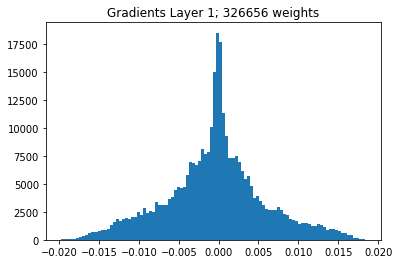

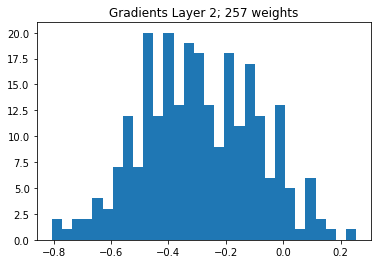

In [203]:


plt.hist(weights_layer_1, bins = 100)
plt.title("Gradients Layer 1; "+str(len(weights_layer_1))+" weights")
plt.show()

plt.hist(weights_layer_2, bins = 30)
plt.title("Gradients Layer 2; "+str(len(weights_layer_2))+" weights")
plt.show()




In [204]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val_scaled))

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 3s 275us/step - loss: 0.1083 - val_loss: 0.0570
Epoch 2/250
9745/9745 [==============================] - 2s 161us/step - loss: 0.0628 - val_loss: 0.0437
Epoch 3/250
9745/9745 [==============================] - 2s 165us/step - loss: 0.0527 - val_loss: 0.0392
Epoch 4/250
9745/9745 [==============================] - 2s 166us/step - loss: 0.0477 - val_loss: 0.0365
Epoch 5/250
9745/9745 [==============================] - 2s 168us/step - loss: 0.0443 - val_loss: 0.0346
Epoch 6/250
9745/9745 [==============================] - 2s 167us/step - loss: 0.0414 - val_loss: 0.0335
Epoch 7/250
9745/9745 [==============================] - 2s 163us/step - loss: 0.0399 - val_loss: 0.0318
Epoch 8/250
9745/9745 [==============================] - 2s 163us/step - loss: 0.0378 - val_loss: 0.0295
Epoch 9/250
9745/9745 [==============================] - 2s 168us/step - loss: 0.0362 - val_loss: 0.0391
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 2s 201us/step - loss: 0.0051 - val_loss: 0.0062
Epoch 79/250
9745/9745 [==============================] - 2s 185us/step - loss: 0.0051 - val_loss: 0.0066
Epoch 80/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.0050 - val_loss: 0.0064
Epoch 81/250
9745/9745 [==============================] - 2s 166us/step - loss: 0.0049 - val_loss: 0.0061
Epoch 82/250
9745/9745 [==============================] - 2s 162us/step - loss: 0.0051 - val_loss: 0.0061
Epoch 83/250
9745/9745 [==============================] - 2s 160us/step - loss: 0.0050 - val_loss: 0.0061
Epoch 84/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.0049 - val_loss: 0.0069
Epoch 85/250
9745/9745 [==============================] - 2s 185us/step - loss: 0.0049 - val_loss: 0.0063
Epoch 86/250
9745/9745 [==============================] - 2s 184us/step - loss: 0.0046 - val_loss: 0.0076
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 1s 141us/step - loss: 0.0034 - val_loss: 0.0051
Epoch 156/250
9745/9745 [==============================] - 1s 141us/step - loss: 0.0034 - val_loss: 0.0051
Epoch 157/250
9745/9745 [==============================] - 1s 145us/step - loss: 0.0033 - val_loss: 0.0051
Epoch 158/250
9745/9745 [==============================] - 2s 160us/step - loss: 0.0034 - val_loss: 0.0057
Epoch 159/250
9745/9745 [==============================] - 1s 148us/step - loss: 0.0033 - val_loss: 0.0052
Epoch 160/250
9745/9745 [==============================] - 1s 153us/step - loss: 0.0034 - val_loss: 0.0056
Epoch 161/250
9745/9745 [==============================] - 1s 153us/step - loss: 0.0033 - val_loss: 0.0055
Epoch 162/250
9745/9745 [==============================] - 2s 178us/step - loss: 0.0033 - val_loss: 0.0052
Epoch 163/250
9745/9745 [==============================] - 2s 179us/step - loss: 0.0033 - val_loss: 0.0054
Epoch 164/250
9745/9745 [============

### Red de una capa, después del entrenamiento

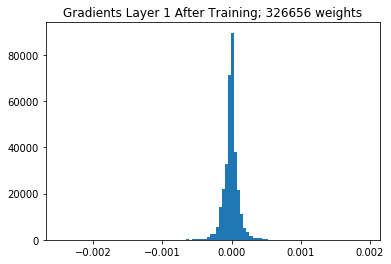

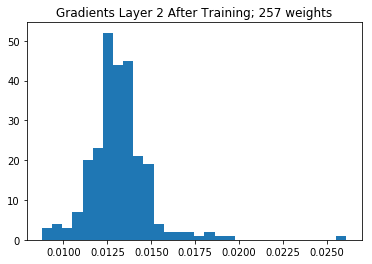

In [205]:
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train_scaled) for gradient in evaluated_gradients]

# Extrating weights 
weights_layer_1 = list()
weights_layer_2 = list()
for neuron in evaluated_gradients[0]:
    weights_layer_1 += list(neuron)
weights_layer_1 += list(evaluated_gradients[1]) # Bias   
for neuron in evaluated_gradients[2]:
    weights_layer_2 += list(neuron)
weights_layer_2 += list(evaluated_gradients[3]) # Bias


weights_layer_1 = np.array(weights_layer_1)
weights_layer_2 = np.array(weights_layer_2)
# Ploting
plt.hist(weights_layer_1, bins = 100)
plt.title("Gradients Layer 1 After Training; "+str(len(weights_layer_1))+" weights")
plt.savefig('2-b-capa1-after.png')
plt.show()

plt.hist(weights_layer_2, bins = 30)
plt.title("Gradients Layer 2 After Training; "+str(len(weights_layer_2))+" weights")
plt.savefig('2-b-capa2-after.png')
plt.show()


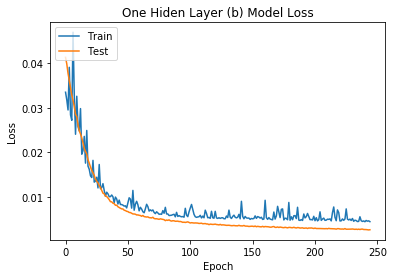

In [206]:
# Ploting Loss And Val_Loss
# Data
val_loss = history.history['val_loss'][5:]
loss = history.history['loss'][5:]

# Ploting
plt.plot(val_loss)
plt.plot(loss)
plt.title('One Hiden Layer (b) Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
fig.savefig("b-model-loss.png")
plt.show()

In [207]:
score = model.evaluate(X_test_scaled, y_test_scaled, verbose=0) 
print(score,model.metrics_names)

0.0032152952990354418 ['loss']


Se puede apreciar que en la primera capa los gradientes empiezan siendo pequeños pero no insignificantes, siguiendo una distribucion normal centrada en 0, y luego del entrenamiento siguen siguiendo esta distribución pero con una varianza mucho menos. En la capa de salida los gradientes empiezan siendo casi todos negativos y terminan siendo positivos.

### c) Uniform initializer + Sigmoid activation


In [159]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256,  kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')



### Gradientes antes del entrenamiento 

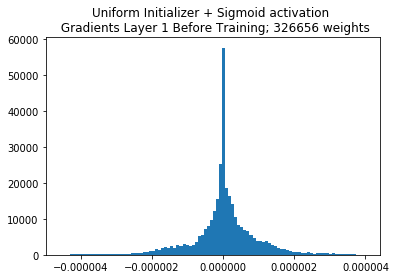

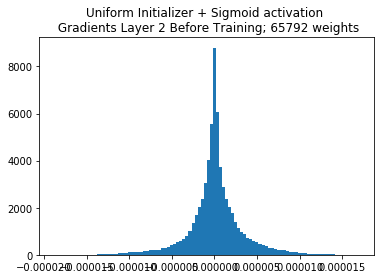

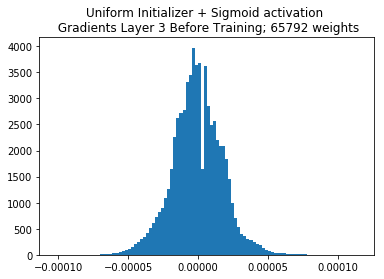

In [160]:
# Gradientes
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train_scaled) for gradient in evaluated_gradients]

weights_list = list()

for i in [0,2,4]:
    weights_in_layer = list()
    for neuron in evaluated_gradients[i]:
        weights_in_layer += list(neuron)
    weights_in_layer += list(evaluated_gradients[i+1])
    weights_list.append(weights_in_layer)

for i in range(len(weights_list)):
    weights = weights_list[i]
    weights = np.array(weights)
    plt.title("Uniform Initializer + Sigmoid activation \n Gradients Layer "+str(i+1)+" Before Training; "+str(len(weights))+" weights")
    plt.hist(weights, bins = 100)
    plt.savefig('2-c-capa'+str(i+1)+'-before.png')
    plt.show()

In [161]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val_scaled))

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 4s 391us/step - loss: 1.0459 - val_loss: 1.0171
Epoch 2/250
9745/9745 [==============================] - 2s 247us/step - loss: 1.0404 - val_loss: 1.0571
Epoch 3/250
9745/9745 [==============================] - 2s 250us/step - loss: 1.0604 - val_loss: 1.0391
Epoch 4/250
9745/9745 [==============================] - 2s 208us/step - loss: 1.0514 - val_loss: 1.0673
Epoch 5/250
9745/9745 [==============================] - 2s 239us/step - loss: 1.0387 - val_loss: 1.0319
Epoch 6/250
9745/9745 [==============================] - 3s 261us/step - loss: 1.0517 - val_loss: 1.0904
Epoch 7/250
9745/9745 [==============================] - 3s 278us/step - loss: 1.0353 - val_loss: 1.0804
Epoch 8/250
9745/9745 [==============================] - 3s 266us/step - loss: 1.0340 - val_loss: 1.2852
Epoch 9/250
9745/9745 [==============================] - 2s 214us/step - loss: 1.0318 - val_loss: 1.0152
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 2s 231us/step - loss: 1.0063 - val_loss: 1.0420
Epoch 79/250
9745/9745 [==============================] - 2s 229us/step - loss: 1.0063 - val_loss: 1.0856
Epoch 80/250
9745/9745 [==============================] - 3s 278us/step - loss: 1.0050 - val_loss: 1.0693
Epoch 81/250
9745/9745 [==============================] - 2s 226us/step - loss: 1.0056 - val_loss: 1.0660
Epoch 82/250
9745/9745 [==============================] - 2s 244us/step - loss: 1.0029 - val_loss: 1.0908
Epoch 83/250
9745/9745 [==============================] - 2s 213us/step - loss: 1.0060 - val_loss: 1.0996
Epoch 84/250
9745/9745 [==============================] - 2s 216us/step - loss: 1.0050 - val_loss: 1.0435
Epoch 85/250
9745/9745 [==============================] - 2s 222us/step - loss: 1.0055 - val_loss: 1.0943
Epoch 86/250
9745/9745 [==============================] - 2s 240us/step - loss: 1.0048 - val_loss: 1.0134
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 3s 309us/step - loss: 0.1472 - val_loss: 0.1374
Epoch 156/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.1301 - val_loss: 0.1128
Epoch 157/250
9745/9745 [==============================] - 3s 290us/step - loss: 0.1132 - val_loss: 0.0948
Epoch 158/250
9745/9745 [==============================] - 3s 288us/step - loss: 0.0965 - val_loss: 0.0820
Epoch 159/250
9745/9745 [==============================] - 3s 312us/step - loss: 0.0812 - val_loss: 0.0773
Epoch 160/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.0718 - val_loss: 0.0578
Epoch 161/250
9745/9745 [==============================] - 3s 283us/step - loss: 0.0635 - val_loss: 0.0689
Epoch 162/250
9745/9745 [==============================] - 3s 298us/step - loss: 0.0593 - val_loss: 0.0534
Epoch 163/250
9745/9745 [==============================] - 3s 285us/step - loss: 0.0563 - val_loss: 0.0483
Epoch 164/250
9745/9745 [============

### Gradientes después del entrenamiento

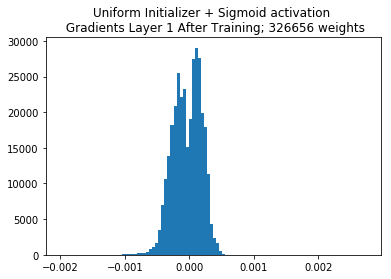

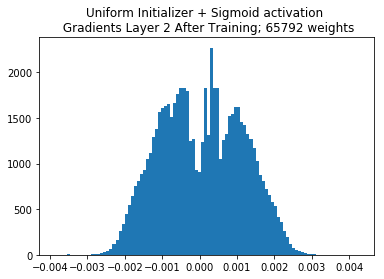

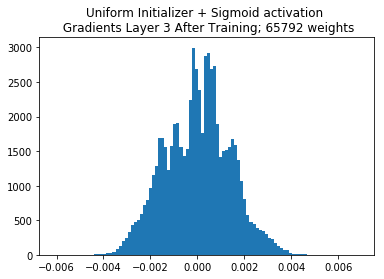

In [162]:
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train_scaled) for gradient in evaluated_gradients]


weights_list = list()
for i in [0,2,4]: # Solo las 3 primeras capas
    weights_in_layer = list()
    for neuron in evaluated_gradients[i]:
        weights_in_layer += list(neuron)
    weights_in_layer += list(evaluated_gradients[i+1]) # bias
    weights_list.append(weights_in_layer)

# Ploting
for i in range(len(weights_list)):
    weights = weights_list[i]
    weights = np.array(weights)
    plt.title("Uniform Initializer + Sigmoid activation \n Gradients Layer "+str(i+1)+" After Training; "+str(len(weights))+" weights")
    plt.hist(weights, bins = 100)
    plt.savefig('2-c-capa'+str(i+1)+'-after.png')
    plt.show()

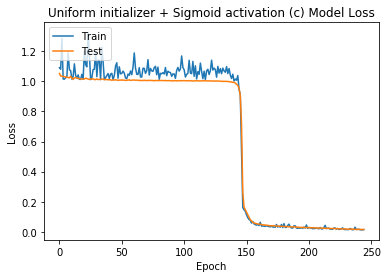

In [164]:
# Ploting Loss And Val_Loss
# Data
val_loss = history.history['val_loss'][5:]
loss = history.history['loss'][5:]

# Ploting
plt.plot(val_loss)
plt.plot(loss)
plt.title('Uniform initializer + Sigmoid activation (c) Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
fig.savefig("b-model-loss.png")
plt.show()

**Comentario**: Se aprecia claramente el problema del gradiente desvaneciente. Los gradientes de las primeras capas de la red son extremadamente pequeños, y esto parece tratar de arreglarse con el entrenamiento pero aún luego de este los gradientes son muy pequeños. El salto que se aprecia en el loss_value del problema parece ser bastante extraño y no sabemos a que se debe.

### d)
### Glorot uniform initializer + Sigmoid activation

In [179]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256,  kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='glorot_uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')



### Gradientes antes del entrenamiento

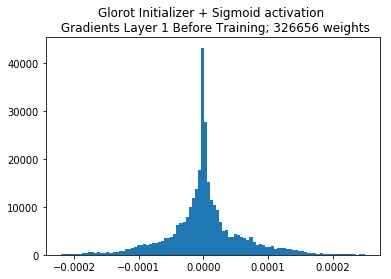

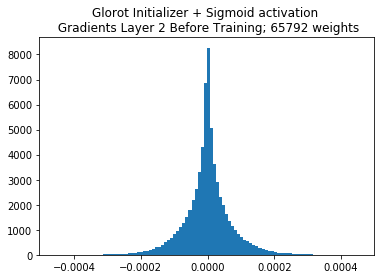

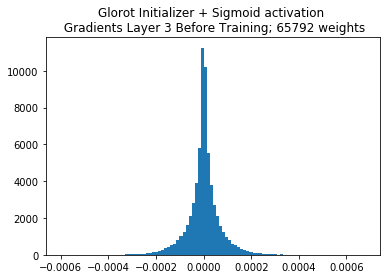

In [180]:
# Gradientes
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train_scaled) for gradient in evaluated_gradients]

weights_list = list()

for i in [0,2,4]:
    weights_in_layer = list()
    for neuron in evaluated_gradients[i]:
        weights_in_layer += list(neuron)
    weights_in_layer += list(evaluated_gradients[i+1])
    weights_list.append(weights_in_layer)

for i in range(len(weights_list)):
    weights = weights_list[i]
    weights = np.array(weights)
    plt.title("Glorot Initializer + Sigmoid activation \n Gradients Layer "+str(i+1)+" Before Training; "+str(len(weights))+" weights")
    plt.hist(weights, bins = 100)
    plt.savefig('2-d-capa'+str(i+1)+'-before.png')
    plt.show()

### Gradientes después del entrenamiento

In [181]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val_scaled))

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 3s 348us/step - loss: 1.0701 - val_loss: 1.0566
Epoch 2/250
9745/9745 [==============================] - 2s 247us/step - loss: 1.0676 - val_loss: 1.0976
Epoch 3/250
9745/9745 [==============================] - 2s 253us/step - loss: 1.0241 - val_loss: 1.0377
Epoch 4/250
9745/9745 [==============================] - 2s 243us/step - loss: 0.9837 - val_loss: 0.8703
Epoch 5/250
9745/9745 [==============================] - 2s 251us/step - loss: 0.7653 - val_loss: 0.4530
Epoch 6/250
9745/9745 [==============================] - 2s 246us/step - loss: 0.2699 - val_loss: 0.1833
Epoch 7/250
9745/9745 [==============================] - 2s 256us/step - loss: 0.1741 - val_loss: 0.1352
Epoch 8/250
9745/9745 [==============================] - 2s 237us/step - loss: 0.1554 - val_loss: 0.1273
Epoch 9/250
9745/9745 [==============================] - 2s 249us/step - loss: 0.1440 - val_loss: 0.1100
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 2s 205us/step - loss: 0.0194 - val_loss: 0.0313
Epoch 79/250
9745/9745 [==============================] - 2s 231us/step - loss: 0.0228 - val_loss: 0.0174
Epoch 80/250
9745/9745 [==============================] - 2s 249us/step - loss: 0.0186 - val_loss: 0.0186
Epoch 81/250
9745/9745 [==============================] - 2s 219us/step - loss: 0.0175 - val_loss: 0.0167
Epoch 82/250
9745/9745 [==============================] - 2s 208us/step - loss: 0.0169 - val_loss: 0.0161
Epoch 83/250
9745/9745 [==============================] - 2s 220us/step - loss: 0.0192 - val_loss: 0.0138
Epoch 84/250
9745/9745 [==============================] - 2s 207us/step - loss: 0.0166 - val_loss: 0.0180
Epoch 85/250
9745/9745 [==============================] - 2s 206us/step - loss: 0.0177 - val_loss: 0.0124
Epoch 86/250
9745/9745 [==============================] - 2s 205us/step - loss: 0.0164 - val_loss: 0.0122
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 2s 229us/step - loss: 0.0078 - val_loss: 0.0068
Epoch 156/250
9745/9745 [==============================] - 2s 243us/step - loss: 0.0076 - val_loss: 0.0156
Epoch 157/250
9745/9745 [==============================] - 3s 305us/step - loss: 0.0082 - val_loss: 0.0203
Epoch 158/250
9745/9745 [==============================] - 3s 300us/step - loss: 0.0073 - val_loss: 0.0066
Epoch 159/250
9745/9745 [==============================] - 3s 280us/step - loss: 0.0066 - val_loss: 0.0066
Epoch 160/250
9745/9745 [==============================] - 3s 257us/step - loss: 0.0072 - val_loss: 0.0070
Epoch 161/250
9745/9745 [==============================] - 2s 241us/step - loss: 0.0070 - val_loss: 0.0064
Epoch 162/250
9745/9745 [==============================] - 2s 243us/step - loss: 0.0081 - val_loss: 0.0141
Epoch 163/250
9745/9745 [==============================] - 2s 217us/step - loss: 0.0083 - val_loss: 0.0069
Epoch 164/250
9745/9745 [============

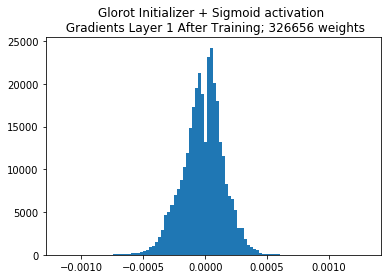

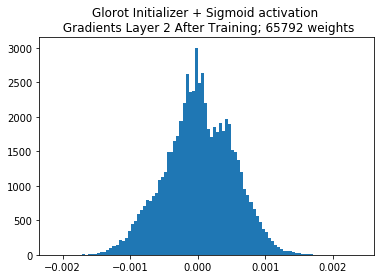

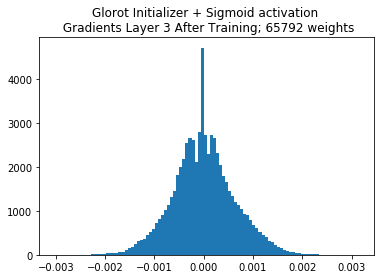

In [182]:
# Gradientes
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train_scaled) for gradient in evaluated_gradients]

weights_list = list()

for i in [0,2,4]:
    weights_in_layer = list()
    for neuron in evaluated_gradients[i]:
        weights_in_layer += list(neuron)
    weights_in_layer += list(evaluated_gradients[i+1])
    weights_list.append(weights_in_layer)

for i in range(len(weights_list)):
    weights = weights_list[i]
    weights = np.array(weights)
    plt.title("Glorot Initializer + Sigmoid activation \n Gradients Layer "+str(i+1)+" After Training; "+str(len(weights))+" weights")
    plt.hist(weights, bins = 100)
    plt.savefig('2-d-capa'+str(i+1)+'-after.png')
    plt.show()

### Loss value

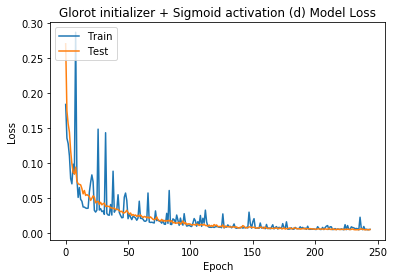

In [183]:
# Ploting Loss And Val_Loss
# Data
val_loss = history.history['val_loss'][5:]
loss = history.history['loss'][5:]

# Ploting
plt.plot(val_loss)
plt.plot(loss)
plt.title('Glorot initializer + Sigmoid activation (d) Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
fig.savefig("d-model-loss.png")
plt.show()

El efecto del gradiente desvaneciente parece irse arreglando una vez entrenado el modelo, ya que los pesos crecen, pasando de valores insignificantes en las primeras capas a valores un poco mayores, pero aún pequeños.

### e)


### Uniform + Relu

In [194]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(256,  kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')


#model.add(Dense(nh, kernel_initializer='uniform',activation='relu')) #uniform
#model.add(Dense(nh, kernel_initializer='he_uniform',activation='relu')) #he

### Gradientes antes del entrenamiento

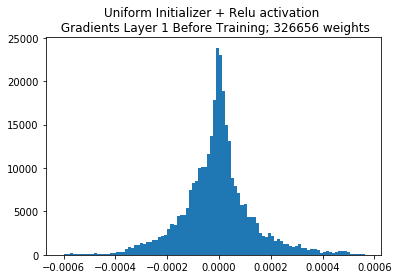

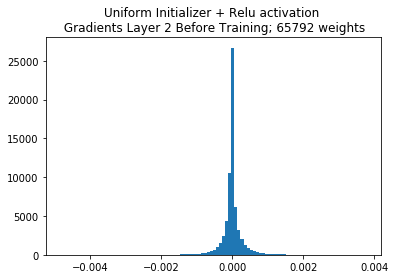

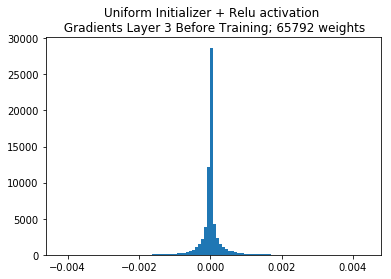

In [195]:
# Gradientes
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train_scaled) for gradient in evaluated_gradients]

weights_list = list()

for i in [0,2,4]:
    weights_in_layer = list()
    for neuron in evaluated_gradients[i]:
        weights_in_layer += list(neuron)
    weights_in_layer += list(evaluated_gradients[i+1])
    weights_list.append(weights_in_layer)

for i in range(len(weights_list)):
    weights = weights_list[i]
    weights = np.array(weights)
    plt.title("Uniform Initializer + Relu activation \n Gradients Layer "+str(i+1)+" Before Training; "+str(len(weights))+" weights")
    plt.hist(weights, bins = 100)
    plt.savefig('2-e-capa'+str(i+1)+'-before.png')
    plt.show()

In [196]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val_scaled))

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 3s 341us/step - loss: 0.5414 - val_loss: 0.2250
Epoch 2/250
9745/9745 [==============================] - 2s 242us/step - loss: 0.1102 - val_loss: 0.0465
Epoch 3/250
9745/9745 [==============================] - 2s 231us/step - loss: 0.0303 - val_loss: 0.0298
Epoch 4/250
9745/9745 [==============================] - 2s 239us/step - loss: 0.0199 - val_loss: 0.0259
Epoch 5/250
9745/9745 [==============================] - 2s 242us/step - loss: 0.0159 - val_loss: 0.0208
Epoch 6/250
9745/9745 [==============================] - 2s 236us/step - loss: 0.0129 - val_loss: 0.0189
Epoch 7/250
9745/9745 [==============================] - 3s 260us/step - loss: 0.0113 - val_loss: 0.0155
Epoch 8/250
9745/9745 [==============================] - 2s 238us/step - loss: 0.0098 - val_loss: 0.0154
Epoch 9/250
9745/9745 [==============================] - 2s 231us/step - loss: 0.0088 - val_loss: 0.0138
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 2s 221us/step - loss: 0.0017 - val_loss: 0.0037
Epoch 79/250
9745/9745 [==============================] - 2s 207us/step - loss: 0.0018 - val_loss: 0.0204
Epoch 80/250
9745/9745 [==============================] - 2s 210us/step - loss: 0.0018 - val_loss: 0.0035
Epoch 81/250
9745/9745 [==============================] - 2s 203us/step - loss: 0.0017 - val_loss: 0.0040
Epoch 82/250
9745/9745 [==============================] - 2s 221us/step - loss: 0.0016 - val_loss: 0.0046
Epoch 83/250
9745/9745 [==============================] - 2s 231us/step - loss: 0.0017 - val_loss: 0.0036
Epoch 84/250
9745/9745 [==============================] - 2s 214us/step - loss: 0.0016 - val_loss: 0.0033
Epoch 85/250
9745/9745 [==============================] - 2s 217us/step - loss: 0.0017 - val_loss: 0.0046
Epoch 86/250
9745/9745 [==============================] - 2s 200us/step - loss: 0.0015 - val_loss: 0.0037
Epoch 87/250
9745/9745 [======================

9745/9745 [==============================] - 2s 200us/step - loss: 8.1547e-04 - val_loss: 0.0025
Epoch 229/250
9745/9745 [==============================] - 2s 198us/step - loss: 8.8483e-04 - val_loss: 0.0027
Epoch 230/250
9745/9745 [==============================] - 2s 199us/step - loss: 8.0058e-04 - val_loss: 0.0026
Epoch 231/250
9745/9745 [==============================] - 2s 199us/step - loss: 9.0813e-04 - val_loss: 0.0026
Epoch 232/250
9745/9745 [==============================] - 2s 200us/step - loss: 8.4178e-04 - val_loss: 0.0025
Epoch 233/250
9745/9745 [==============================] - 2s 199us/step - loss: 8.4658e-04 - val_loss: 0.0025
Epoch 234/250
9745/9745 [==============================] - 2s 200us/step - loss: 8.5313e-04 - val_loss: 0.0028
Epoch 235/250
9745/9745 [==============================] - 2s 199us/step - loss: 8.3140e-04 - val_loss: 0.0025
Epoch 236/250
9745/9745 [==============================] - 2s 198us/step - loss: 8.5830e-04 - val_loss: 0.0026
Epoch 237/250
9

### Gradientes después del entrenamiento

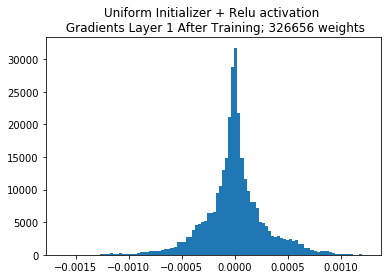

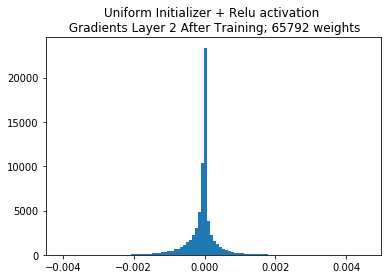

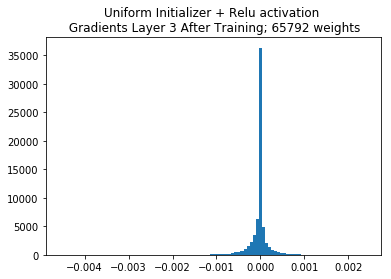

In [197]:
# Gradientes
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train_scaled) for gradient in evaluated_gradients]

weights_list = list()

for i in [0,2,4]:
    weights_in_layer = list()
    for neuron in evaluated_gradients[i]:
        weights_in_layer += list(neuron)
    weights_in_layer += list(evaluated_gradients[i+1])
    weights_list.append(weights_in_layer)

for i in range(len(weights_list)):
    weights = weights_list[i]
    weights = np.array(weights)
    plt.title("Uniform Initializer + Relu activation \n Gradients Layer "+str(i+1)+" After Training; "+str(len(weights))+" weights")
    plt.hist(weights, bins = 100)
    plt.savefig('2-e-capa'+str(i+1)+'-after.png')
    plt.show()

### Loss Value

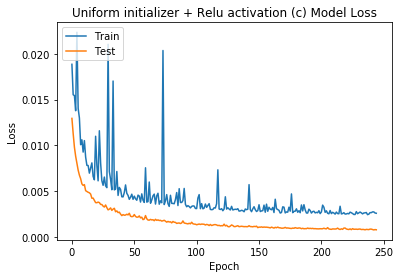

In [199]:
# Ploting Loss And Val_Loss
# Data
val_loss = history.history['val_loss'][5:]
loss = history.history['loss'][5:]

# Ploting
plt.plot(val_loss)
plt.plot(loss)
plt.title('Uniform initializer + Relu activation (e) Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
fig.savefig("e-model-loss.png")
plt.show()

**Comentario**: Se aprecia como Relu no sufre tanto el problema del gradiente desvaneciente debido a su derivada, que es mayor a la de la función sigmoide y no se hace 0 al estar cerca del 0. Este modelo lográ converger rapido y dar mejores resultados que b) y c)

### He Uniform + Relu



In [4]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(256,  kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='he_uniform',activation='linear'))
sgd = SGD(lr=0.0005)
model.compile(optimizer=sgd,loss='mean_squared_error')


#model.add(Dense(nh, kernel_initializer='uniform',activation='relu')) #uniform
#model.add(Dense(nh, kernel_initializer='he_uniform',activation='relu')) #he

/home/diego/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Gradientes antes del entrenamiento

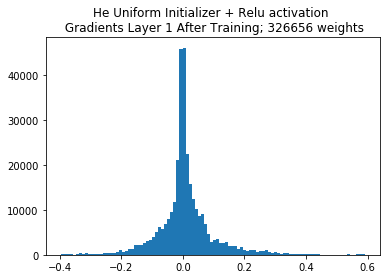

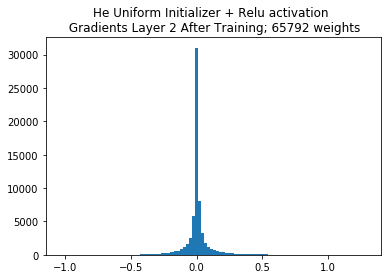

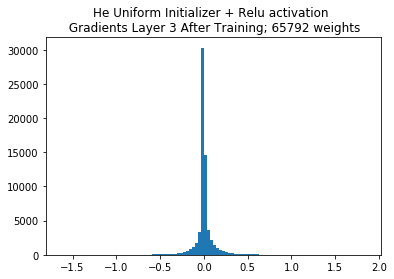

In [10]:
import keras
from keras import backend as K
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


# Gradientes
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train_scaled) for gradient in evaluated_gradients]

weights_list = list()

for i in [0,2,4]:
    weights_in_layer = list()
    for neuron in evaluated_gradients[i]:
        weights_in_layer += list(neuron)
    weights_in_layer += list(evaluated_gradients[i+1])
    weights_list.append(weights_in_layer)

for i in range(len(weights_list)):
    weights = weights_list[i]
    weights = np.array(weights)
    plt.title("He Uniform Initializer + Relu activation \n Gradients Layer "+str(i+1)+" After Training; "+str(len(weights))+" weights")
    plt.hist(weights, bins = 100)
    plt.savefig('2-e-capa'+str(i+1)+'-after-he.png')
    plt.show()

In [11]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val_scaled))

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 3s 257us/step - loss: 0.2186 - val_loss: 0.0682
Epoch 2/250
9745/9745 [==============================] - 2s 223us/step - loss: 0.0682 - val_loss: 0.0580
Epoch 3/250
9745/9745 [==============================] - 2s 220us/step - loss: 0.0579 - val_loss: 0.0480
Epoch 4/250
9745/9745 [==============================] - 2s 226us/step - loss: 0.0378 - val_loss: 0.0519
Epoch 5/250
9745/9745 [==============================] - 2s 225us/step - loss: 0.0284 - val_loss: 0.0428
Epoch 6/250
9745/9745 [==============================] - 2s 222us/step - loss: 0.0195 - val_loss: 0.0377
Epoch 7/250
9745/9745 [==============================] - 2s 219us/step - loss: 0.0158 - val_loss: 0.0341
Epoch 8/250
9745/9745 [==============================] - 2s 219us/step - loss: 0.0141 - val_loss: 0.0334
Epoch 9/250
9745/9745 [==============================] - 2s 224us/step - loss: 0.0130 - val_loss: 0.0331
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 2s 214us/step - loss: 0.0034 - val_loss: 0.0152
Epoch 79/250
9745/9745 [==============================] - 2s 215us/step - loss: 0.0033 - val_loss: 0.0151
Epoch 80/250
9745/9745 [==============================] - 2s 213us/step - loss: 0.0033 - val_loss: 0.0152
Epoch 81/250
9745/9745 [==============================] - 2s 215us/step - loss: 0.0032 - val_loss: 0.0147
Epoch 82/250
9745/9745 [==============================] - 2s 216us/step - loss: 0.0032 - val_loss: 0.0146
Epoch 83/250
9745/9745 [==============================] - 2s 213us/step - loss: 0.0032 - val_loss: 0.0145
Epoch 84/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0032 - val_loss: 0.0158
Epoch 85/250
9745/9745 [==============================] - 2s 213us/step - loss: 0.0032 - val_loss: 0.0145
Epoch 86/250
9745/9745 [==============================] - 2s 216us/step - loss: 0.0032 - val_loss: 0.0144
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 2s 214us/step - loss: 0.0022 - val_loss: 0.0127
Epoch 156/250
9745/9745 [==============================] - 2s 216us/step - loss: 0.0022 - val_loss: 0.0130
Epoch 157/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0022 - val_loss: 0.0144
Epoch 158/250
9745/9745 [==============================] - 2s 214us/step - loss: 0.0022 - val_loss: 0.0123
Epoch 159/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0021 - val_loss: 0.0127
Epoch 160/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0021 - val_loss: 0.0122
Epoch 161/250
9745/9745 [==============================] - 2s 210us/step - loss: 0.0021 - val_loss: 0.0127
Epoch 162/250
9745/9745 [==============================] - 2s 215us/step - loss: 0.0021 - val_loss: 0.0126
Epoch 163/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0021 - val_loss: 0.0128
Epoch 164/250
9745/9745 [============

### Gradientes después del entrenamiento

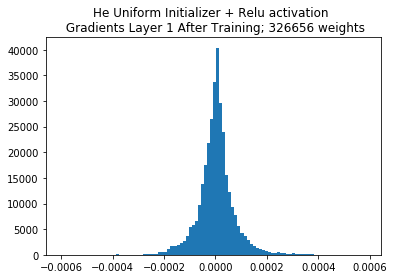

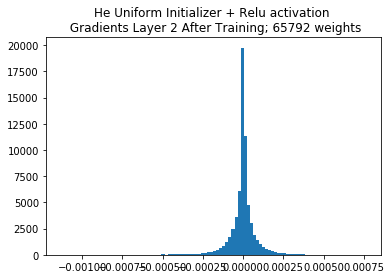

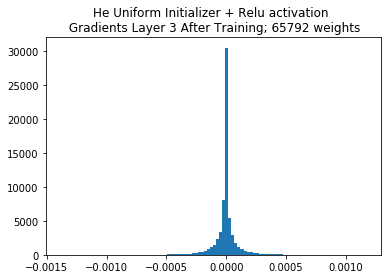

In [12]:
# Gradientes
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train_scaled) for gradient in evaluated_gradients]

weights_list = list()

for i in [0,2,4]:
    weights_in_layer = list()
    for neuron in evaluated_gradients[i]:
        weights_in_layer += list(neuron)
    weights_in_layer += list(evaluated_gradients[i+1])
    weights_list.append(weights_in_layer)

for i in range(len(weights_list)):
    weights = weights_list[i]
    weights = np.array(weights)
    plt.title("He Uniform Initializer + Relu activation \n Gradients Layer "+str(i+1)+" After Training; "+str(len(weights))+" weights")
    plt.hist(weights, bins = 100)
    plt.savefig('2-e-capa'+str(i+1)+'-after-he.png')
    plt.show()

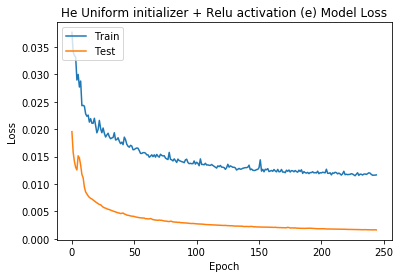

In [15]:
# Ploting Loss And Val_Loss
# Data
val_loss = history.history['val_loss'][5:]
loss = history.history['loss'][5:]

# Ploting
plt.plot(val_loss)
plt.plot(loss)
plt.title('He Uniform initializer + Relu activation (e) Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
#fig.savefig("e-model-loss.png")
plt.show()

**Comentario**: Podemos apreciar que la inicialización de pesos de He hace que no haya problema del gradiente descendiente antes del inicio del entrenamiento, ya que los gradientes parecen ser muy grandes en comparación a los modelos anteriores. Luego del entremiento se aprecia nuevamente gradientes muy pequeños en las primeras capas de la red. El modelo logra converger pero con un learning rate mucho menor a los modelos anteriores (Se aplicó prueba y error)

### f)

El modelo presentado en la pregunta e), que usaba inializador uniforme + Relu ya supero por un poco al modelo de la pregunta b). Intentaremos mejorarlo aún mas cambiando el lr.



In [208]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(256,  kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(256, kernel_initializer='uniform',activation='relu'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')


#model.add(Dense(nh, kernel_initializer='uniform',activation='relu')) #uniform
#model.add(Dense(nh, kernel_initializer='he_uniform',activation='relu')) #he

In [209]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val_scaled))

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 4s 373us/step - loss: 0.5279 - val_loss: 0.1962
Epoch 2/250
9745/9745 [==============================] - 3s 263us/step - loss: 0.0812 - val_loss: 0.0403
Epoch 3/250
9745/9745 [==============================] - 3s 352us/step - loss: 0.0255 - val_loss: 0.0262
Epoch 4/250
9745/9745 [==============================] - 3s 355us/step - loss: 0.0174 - val_loss: 0.0221
Epoch 5/250
9745/9745 [==============================] - 3s 292us/step - loss: 0.0137 - val_loss: 0.0184
Epoch 6/250
9745/9745 [==============================] - 3s 271us/step - loss: 0.0111 - val_loss: 0.0153
Epoch 7/250
9745/9745 [==============================] - 3s 275us/step - loss: 0.0099 - val_loss: 0.0145
Epoch 8/250
9745/9745 [==============================] - 3s 257us/step - loss: 0.0087 - val_loss: 0.0130
Epoch 9/250
9745/9745 [==============================] - 2s 250us/step - loss: 0.0081 - val_loss: 0.0163
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 2s 246us/step - loss: 0.0016 - val_loss: 0.0042
Epoch 79/250
9745/9745 [==============================] - 2s 241us/step - loss: 0.0016 - val_loss: 0.0035
Epoch 80/250
9745/9745 [==============================] - 2s 254us/step - loss: 0.0016 - val_loss: 0.0034
Epoch 81/250
9745/9745 [==============================] - 2s 239us/step - loss: 0.0016 - val_loss: 0.0046
Epoch 82/250
9745/9745 [==============================] - 2s 249us/step - loss: 0.0016 - val_loss: 0.0035
Epoch 83/250
9745/9745 [==============================] - 2s 238us/step - loss: 0.0016 - val_loss: 0.0035
Epoch 84/250
9745/9745 [==============================] - 2s 242us/step - loss: 0.0016 - val_loss: 0.0036
Epoch 85/250
9745/9745 [==============================] - 2s 252us/step - loss: 0.0017 - val_loss: 0.0040
Epoch 86/250
9745/9745 [==============================] - 2s 244us/step - loss: 0.0016 - val_loss: 0.0034
Epoch 87/250
9745/9745 [======================

9745/9745 [==============================] - 2s 249us/step - loss: 8.2036e-04 - val_loss: 0.0028
Epoch 229/250
9745/9745 [==============================] - 3s 260us/step - loss: 8.9399e-04 - val_loss: 0.0025
Epoch 230/250
9745/9745 [==============================] - 3s 263us/step - loss: 8.0014e-04 - val_loss: 0.0027
Epoch 231/250
9745/9745 [==============================] - 2s 254us/step - loss: 8.3179e-04 - val_loss: 0.0026
Epoch 232/250
9745/9745 [==============================] - 2s 240us/step - loss: 8.0957e-04 - val_loss: 0.0026
Epoch 233/250
9745/9745 [==============================] - 2s 256us/step - loss: 8.0593e-04 - val_loss: 0.0025
Epoch 234/250
9745/9745 [==============================] - 2s 240us/step - loss: 7.7573e-04 - val_loss: 0.0025
Epoch 235/250
9745/9745 [==============================] - 2s 242us/step - loss: 8.1354e-04 - val_loss: 0.0026
Epoch 236/250
9745/9745 [==============================] - 2s 242us/step - loss: 7.9694e-04 - val_loss: 0.0024
Epoch 237/250
9

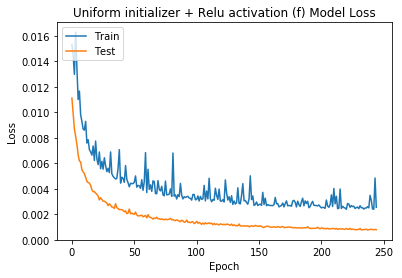

In [210]:
# Ploting Loss And Val_Loss
# Data
val_loss = history.history['val_loss'][5:]
loss = history.history['loss'][5:]

# Ploting
plt.plot(val_loss)
plt.plot(loss)
plt.title('Uniform initializer + Relu activation (f) Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
fig.savefig("f-model-loss.png")
plt.show()

In [211]:
score = model.evaluate(X_test_scaled, y_test_scaled, verbose=0) 
print(score,model.metrics_names)b

0.001724913309388066 ['loss']


**Comentario:** Comprobamos que el modelo de 6 capas con unicializacion uniforme y función de activación Relu, logra mitigar el problema del gradiente desvaneciente y superar el MSE del modelo de 1 capa oculta.

### g)
### Softplus

In [138]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(256,  kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(256, kernel_initializer='he_uniform',activation='softplus'))
model.add(Dense(1, kernel_initializer='he_uniform',activation='linear'))
sgd = SGD(lr=0.0005)
model.compile(optimizer=sgd,loss='mean_squared_error')

#model.add(Dense(nh, kernel_initializer='he_uniform',activation='softplus')) #softplus

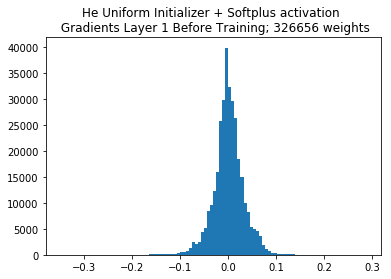

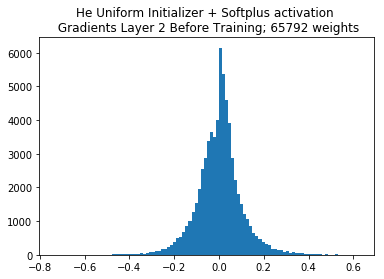

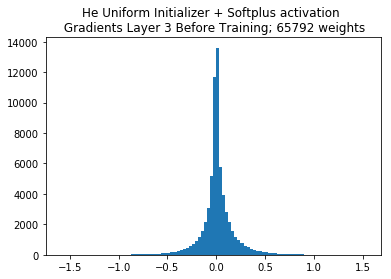

In [139]:
# Gradientes
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gra# Gradientes
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train_scaled) for gradient in evaluated_gradients]

weights_list = list()

for i in [0,2,4]:
    weights_in_layer = list()
    for neuron in evaluated_gradients[i]:
        weights_in_layer += list(neuron)
    weights_in_layer += list(evaluated_gradients[i+1])
    weights_list.append(weights_in_layer)

for i in range(len(weights_list)):
    weights = weights_list[i]
    weights = np.array(weights)
    plt.title("He Uniform Initializer + Softplus activation \n Gradients Layer "+str(i+1)+" Before Training; "+str(len(weights))+" weights")
    plt.hist(weights, bins = 100)
    plt.savefig('2-g-capa'+str(i+1)+'-before.png')
    plt.show()dients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train_scaled) for gradient in evaluated_gradients]

weights_list = list()

for i in [0,2,4]:
    weights_in_layer = list()
    for neuron in evaluated_gradients[i]:
        weights_in_layer += list(neuron)
    weights_in_layer += list(evaluated_gradients[i+1])
    weights_list.append(weights_in_layer)

for i in range(len(weights_list)):
    weights = weights_list[i]
    weights = np.array(weights)
    plt.title("He Uniform Initializer + Softplus activation \n Gradients Layer "+str(i+1)+" Before Training; "+str(len(weights))+" weights")
    plt.hist(weights, bins = 100)
    plt.savefig('2-g-capa'+str(i+1)+'-before.png')
    plt.show()

In [140]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val_scaled))

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.4343 - val_loss: 0.0648
Epoch 2/250
9745/9745 [==============================] - 2s 248us/step - loss: 0.0706 - val_loss: 0.1404
Epoch 3/250
9745/9745 [==============================] - 2s 243us/step - loss: 0.0551 - val_loss: 0.0403
Epoch 4/250
9745/9745 [==============================] - 2s 245us/step - loss: 0.0427 - val_loss: 0.0435
Epoch 5/250
9745/9745 [==============================] - 2s 241us/step - loss: 0.0369 - val_loss: 0.0326
Epoch 6/250
9745/9745 [==============================] - 2s 243us/step - loss: 0.0319 - val_loss: 0.0318
Epoch 7/250
9745/9745 [==============================] - 2s 256us/step - loss: 0.0283 - val_loss: 0.0285
Epoch 8/250
9745/9745 [==============================] - 3s 270us/step - loss: 0.0259 - val_loss: 0.0276
Epoch 9/250
9745/9745 [==============================] - 3s 280us/step - loss: 0.0239 - val_loss: 0.0251
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0075 - val_loss: 0.0105
Epoch 79/250
9745/9745 [==============================] - 2s 217us/step - loss: 0.0074 - val_loss: 0.0118
Epoch 80/250
9745/9745 [==============================] - 2s 225us/step - loss: 0.0074 - val_loss: 0.0105
Epoch 81/250
9745/9745 [==============================] - 2s 214us/step - loss: 0.0074 - val_loss: 0.0104
Epoch 82/250
9745/9745 [==============================] - 2s 215us/step - loss: 0.0072 - val_loss: 0.0104
Epoch 83/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0071 - val_loss: 0.0119
Epoch 84/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0072 - val_loss: 0.0103
Epoch 85/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0071 - val_loss: 0.0105
Epoch 86/250
9745/9745 [==============================] - 2s 213us/step - loss: 0.0070 - val_loss: 0.0122
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0053 - val_loss: 0.0083
Epoch 156/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0053 - val_loss: 0.0082
Epoch 157/250
9745/9745 [==============================] - 2s 213us/step - loss: 0.0053 - val_loss: 0.0084
Epoch 158/250
9745/9745 [==============================] - 2s 216us/step - loss: 0.0053 - val_loss: 0.0081
Epoch 159/250
9745/9745 [==============================] - 2s 214us/step - loss: 0.0053 - val_loss: 0.0084
Epoch 160/250
9745/9745 [==============================] - 2s 214us/step - loss: 0.0053 - val_loss: 0.0080
Epoch 161/250
9745/9745 [==============================] - 2s 210us/step - loss: 0.0053 - val_loss: 0.0084
Epoch 162/250
9745/9745 [==============================] - 2s 209us/step - loss: 0.0052 - val_loss: 0.0097
Epoch 163/250
9745/9745 [==============================] - 2s 208us/step - loss: 0.0052 - val_loss: 0.0081
Epoch 164/250
9745/9745 [============

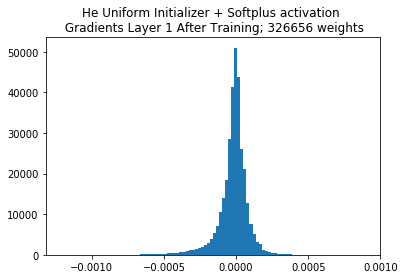

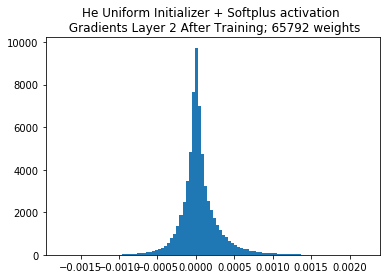

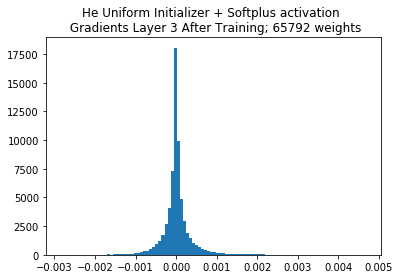

In [142]:
# Gradientes
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train_scaled) for gradient in evaluated_gradients]

weights_list = list()

for i in [0,2,4]:
    weights_in_layer = list()
    for neuron in evaluated_gradients[i]:
        weights_in_layer += list(neuron)
    weights_in_layer += list(evaluated_gradients[i+1])
    weights_list.append(weights_in_layer)

for i in range(len(weights_list)):
    weights = weights_list[i]
    weights = np.array(weights)
    plt.title("He Uniform Initializer + Softplus activation \n Gradients Layer "+str(i+1)+" After Training; "+str(len(weights))+" weights")
    plt.hist(weights, bins = 100)
    plt.savefig('2-g-capa'+str(i+1)+'-after.png')
    plt.show()

**Comentarios:** Aquí como resultado podemos ver que si bien los gradientes parten siendo  mucho mas grandes que los gradientes de las preguntas anteriores, luego del entrenamiento estos se acercan mucho al 0 en las primeras capas, es decir se cae luego del entrenamiento en el problema del gradiente desvaneciente. Aún asi el modelo logra rendir bastante bien en comparación a modelos anteriores.

### h)

In [146]:
model = Sequential()
model.add(Dense(1024, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
model.compile(optimizer=sgd,loss='mean_squared_error')
model.fit(X_train_scaled.values, y_train_scaled, epochs=250, verbose=1, validation_data=(X_val_scaled.values, y_val_scaled))

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 5s 484us/step - loss: 0.1869 - val_loss: 0.1062
Epoch 2/250
9745/9745 [==============================] - 4s 400us/step - loss: 0.1048 - val_loss: 0.0872
Epoch 3/250
9745/9745 [==============================] - 4s 400us/step - loss: 0.0943 - val_loss: 0.0820
Epoch 4/250
9745/9745 [==============================] - 4s 402us/step - loss: 0.0873 - val_loss: 0.0750
Epoch 5/250
9745/9745 [==============================] - 4s 402us/step - loss: 0.0818 - val_loss: 0.0673
Epoch 6/250
9745/9745 [==============================] - 4s 402us/step - loss: 0.0773 - val_loss: 0.0636
Epoch 7/250
9745/9745 [==============================] - 4s 402us/step - loss: 0.0738 - val_loss: 0.0605
Epoch 8/250
9745/9745 [==============================] - 4s 402us/step - loss: 0.0707 - val_loss: 0.0588
Epoch 9/250
9745/9745 [==============================] - 4s 402us/step - loss: 0.0683 - val_loss: 0.0564
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 4s 442us/step - loss: 0.0378 - val_loss: 0.0329
Epoch 79/250
9745/9745 [==============================] - 4s 431us/step - loss: 0.0377 - val_loss: 0.0321
Epoch 80/250
9745/9745 [==============================] - 5s 528us/step - loss: 0.0375 - val_loss: 0.0319
Epoch 81/250
9745/9745 [==============================] - 4s 447us/step - loss: 0.0374 - val_loss: 0.0322
Epoch 82/250
9745/9745 [==============================] - 4s 413us/step - loss: 0.0373 - val_loss: 0.0320
Epoch 83/250
9745/9745 [==============================] - 4s 360us/step - loss: 0.0372 - val_loss: 0.0316
Epoch 84/250
9745/9745 [==============================] - 3s 358us/step - loss: 0.0370 - val_loss: 0.0315
Epoch 85/250
9745/9745 [==============================] - 4s 362us/step - loss: 0.0369 - val_loss: 0.0313
Epoch 86/250
9745/9745 [==============================] - 3s 359us/step - loss: 0.0368 - val_loss: 0.0316
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 4s 402us/step - loss: 0.0303 - val_loss: 0.0267
Epoch 156/250
9745/9745 [==============================] - 4s 398us/step - loss: 0.0302 - val_loss: 0.0265
Epoch 157/250
9745/9745 [==============================] - 4s 399us/step - loss: 0.0302 - val_loss: 0.0265
Epoch 158/250
9745/9745 [==============================] - 4s 397us/step - loss: 0.0301 - val_loss: 0.0267
Epoch 159/250
9745/9745 [==============================] - 4s 398us/step - loss: 0.0300 - val_loss: 0.0267
Epoch 160/250
9745/9745 [==============================] - 4s 400us/step - loss: 0.0299 - val_loss: 0.0264
Epoch 161/250
9745/9745 [==============================] - 4s 399us/step - loss: 0.0298 - val_loss: 0.0262
Epoch 162/250
9745/9745 [==============================] - 4s 398us/step - loss: 0.0298 - val_loss: 0.0269
Epoch 163/250
9745/9745 [==============================] - 4s 400us/step - loss: 0.0297 - val_loss: 0.0267
Epoch 164/250
9745/9745 [============

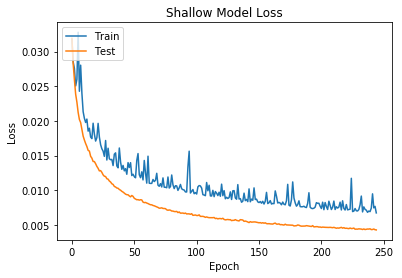

In [151]:
# Ploting Loss And Val_Loss
# Data
val_loss = history.history['val_loss'][5:]
loss = history.history['loss'][5:]

# Ploting
plt.plot(val_loss)
plt.plot(loss)
plt.title('Shallow Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
fig.savefig("shallow-model-loss.png")
plt.show()


**Comentario:** Podemos apreciar como el modelo logra la rapida convergencia, sin embargo no logra un valor de error tan pequeño como en la red de la pregunta b) o de la f).

<a id="tercero"></a>
## 3. Entendimiento de imágenes de personas

El problema de inferir ciertas características de una persona a través de una foto de ella puede resultar bastante dificil incluso para nosotros, como por ejemplo de qué país es, la emoción que expresa, la edad que tiene, o el género. La automatización de este proceso para que máquinas logren identificar ciertas características de una persona puede ser algo crucial para el futuro desarrollo de Inteligencia Artificial.


<img src="https://i.imgur.com/6B072GE.jpg" width="60%" height="20%" />


En esta actividad trabajaremos con unos datos (imágenes) con la tarea de predecir la **edad** (*target value*) de la persona en la imagen. Los datos con corresponden a 3640 imágenes de Flickr de rostros de personas, pero, debido a que trabajamos con redes *feed forward*, se trabajará con representaciones de características extraídas. Para ésto necesitará descargar los datos del siguiente __[link](http://chenlab.ece.cornell.edu/people/Andy/ImagesOfGroups.html)__ en el extracto de *ageGenderClassification* o a través de la consola Unix.
```
wget http://chenlab.ece.cornell.edu/projects/ImagesOfGroups/ageGenderClassification.zip
```

Se trabajará con archivos *.mat* que pueden ser cargados de la siguiente manera:
```python
import scipy.io as sio
sio.loadmat("file.mat")
```

Para descripción sobre las columnas están en el archivo readme a través del siguiente __[link](http://chenlab.ece.cornell.edu/projects/ImagesOfGroups/README.txt)__ o a través de la consola Unix:
```
wget http://chenlab.ece.cornell.edu/projects/ImagesOfGroups/README.txt
```


> a) Cargue los datos dos dataset de entrenamiento y de pruebas ¿Cuántos datos hay en cada conjunto?
```python
import scipy.io as sio
mat_train = sio.loadmat("./eventrain.mat")
mat_test = sio.loadmat("./eventest.mat")
data_train= mat_train["trcoll"][0][0]
data_test= mat_test["tecoll"][0][0]
```

> b) Eliga cuál representación utilizará para trabajar los datos y entregárselos como *input* al modelo neuronal denso. Además extraiga las etiquetas del problema. Describa los datos utilziados.
```python
genFeat = data[0]  #it can be used as representation: contextual features
ageClass = data[1] #target
ffcoefs = data[3]   #it can be used as representation: fisherface space
faceGist = data[4]  #it can be used as representation
```

> c) Defina y entrene una modelo de red neuronal *feed forward* para la inferencia de la edad de la persona a través de la representación escogida. Intente llegar a un *mse* menor a 100 en el conjunto de pruebas. Recuerde que **NO** puede seleccionar modelos a través del conjunto de pruebas. Visualice sus resultados si estima conveniente.


*Nota: Puede notar que la cantidad de edades presentes en el problema son pocas (1,  5, 10, 16, 28, 51 o 75 años), por lo que puede tratar al problema así como de regresión o clasificación (considerando cada edad como una clase)*


#### Ayuda:
> Para problemas de clasificación de múltiples clases es necesario transformar las etiquetas categóricas en *one hot vector*, donde cada columna del vector representará una categoría. Por ejemplo, si existen tres categorías (perro, gato, ratón), la categoría perro puede ser codificada como [1,0,0], y la categoría ratón puede ser codificada como [0,0,1]. Para ésto la librería *keras* nos ayuda:

```python
import keras
y_onehot = keras.utils.to_categorical(y_train,num_classes=edades_distintas)
```

In [231]:
import scipy.io as sio
import keras
from keras.metrics import categorical_accuracy
import pandas as pd
import collections
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam,SGD, RMSprop, Adagrad, Adadelta
from keras import regularizers
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
import matplotlib
import matplotlib.pyplot as plt

def netFace(method=Adam(lr=0.001),numEpochs=100,szBatch=32):
    mat_train = sio.loadmat("AgeGenderClassification/eventrain.mat")
    mat_test = sio.loadmat("AgeGenderClassification/eventest.mat")
    data_train= mat_train["trcoll"][0][0]
    data_test= mat_test["tecoll"][0][0]

    histories = dict()

    #dtype=[('genFeat', 'O'), ('ageClass', 'O'), ('genClass', 'O'), ('ffcoefs', 'O'), ('faceGist', 'O'), 
    #        ('faceimg', 'O'), ('genderGuessNN', 'O'), ('ageGuess1', 'O'), ('name', 'O'), ('facePosSize', 'O'), 
    #        ('origin', 'O')])

    #ffcoefs: [1090x37 double]	    Nx37. Each row is a projection of that face into a fisherFace space, 
                                        # effective for facial similarity measurement. 

    # Train
    genFeat = data_train[0]  #it can be used as representation: contextual features
    ageClass = data_train[1] #target
    ffcoefs = data_train[3]   #it can be used as representation: fisherface space
    faceGist = data_train[4]  #it can be used as representation

    x_train = ffcoefs #x_train = ffcoefs # 3500x37
    y_train = ageClass # 3500x1
    #print(collections.Counter(np.array(y_train).reshape(3500)))

    x_test = data_test[3] #x_test = data_test[3]
    y_test = data_test[1]
    
    dic_class = {1:0,5:1,10:2,16:3,28:4,51:5,75:6}
    scaled_y_train = np.zeros((3500,1))
    scaled_y_test = np.zeros(y_test.shape)

    for i in range(1050):
        scaled_y_test[i][0] = dic_class[y_test[i][0]]

    for i in range(3500):
        scaled_y_train[i][0] = dic_class[y_train[i][0]]


    print(y_train.shape,y_test.shape)
    y_onehot = keras.utils.to_categorical(scaled_y_train,num_classes=7) #y_onehot = keras.utils.to_categorical(y_train) 
    y_onehot_test = keras.utils.to_categorical(scaled_y_test,num_classes=7) #y_onehot_test = keras.utils.to_categorical(y_test) 

    print(y_onehot.shape,y_onehot_test.shape)
    
    # Modelo

    model = Sequential()
    model.add(Dense(10, input_dim=x_train.shape[1], kernel_initializer='glorot_uniform',activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(7, input_dim=x_train.shape[1], kernel_initializer='glorot_uniform',activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(10, input_dim=x_train.shape[1], kernel_initializer='glorot_uniform',activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(8, input_dim=x_train.shape[1], kernel_initializer='glorot_uniform',activation="relu"))
    model.add(Dense(8, input_dim=x_train.shape[1], kernel_initializer='glorot_uniform',activation="relu"))
    model.add(Dense(7, kernel_initializer='uniform',activation="softmax")) 

    model.compile(optimizer=method, metrics=[categorical_accuracy],loss='categorical_crossentropy')#,loss='mse')#loss='binary_crossentropy'

    print(model.summary()) 
    history = model.fit(x_train, y_onehot, epochs=numEpochs,batch_size=szBatch, verbose=0, validation_data=(x_test, y_onehot_test))

    loss= history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(val_loss)
    plt.plot(loss)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Test', 'Train'], loc='upper left')
    plt.show()

    score = model.evaluate(x_test, y_onehot_test, verbose=0) 
    print(score,model.metrics_names)
    return model

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_447 (Dense)            (None, 10)                380       
_________________________________________________________________
dropout_140 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_448 (Dense)            (None, 7)                 77        
_________________________________________________________________
dropout_141 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_449 (Dense)            (None, 10)                80        
_________________________________________________________________
dropout_142 (Dropout)        (None, 10)                0         
_________________________________________________________________
dense_450 (Dense)            (None, 

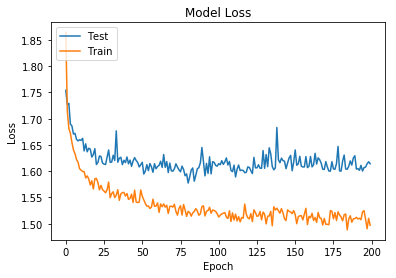

[1.6141373053051176, 0.346666666723433] ['loss', 'categorical_accuracy']
623.2790476190477


In [233]:
dec = np.logspace(-6,0,10)[1]
mod = netFace(numEpochs=200,method=Adam(lr=0.01,decay=dec),szBatch=32)
print(EMC(mod))

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_336 (Dense)            (None, 10)                380       
_________________________________________________________________
dropout_92 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_337 (Dense)            (None, 7)                 77        
_________________________________________________________________
dropout_93 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_338 (Dense)            (None, 7)                 56        
_________________________________________________________________
dense_339 (Dense)            (None, 10)                80        
_________________________________________________________________
dense_340 (Dense)            (None, 

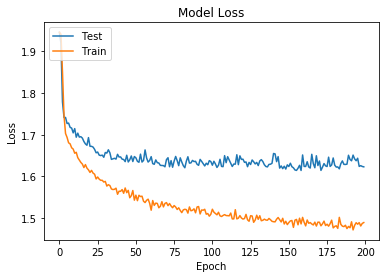

[1.6229769511449905, 0.3504761904761905] ['loss', 'categorical_accuracy']
489.65238095238095


In [197]:
dec = np.logspace(-6,0,10)[1]
mod = netFace(numEpochs=200,method=Adam(lr=0.001,decay=dec),szBatch=32)
print(EMC(mod))

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_282 (Dense)            (None, 100)               3800      
_________________________________________________________________
dropout_63 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_283 (Dense)            (None, 40)                4040      
_________________________________________________________________
dropout_64 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_284 (Dense)            (None, 20)                820       
_________________________________________________________________
dropout_65 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_285 (Dense)            (None, 

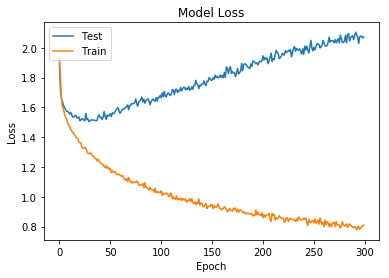

[2.071423020362854, 0.36857142834436324] ['loss', 'categorical_accuracy']
570.1


In [173]:
dec = np.logspace(-6,0,10)[1]
mod = netFace(numEpochs=300,method=Adam(lr=0.001,decay=dec),szBatch=32)
print(EMC(mod))

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_276 (Dense)            (None, 100)               3800      
_________________________________________________________________
dropout_59 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_277 (Dense)            (None, 50)                5050      
_________________________________________________________________
dropout_60 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_278 (Dense)            (None, 40)                2040      
_________________________________________________________________
dropout_61 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_279 (Dense)            (None, 

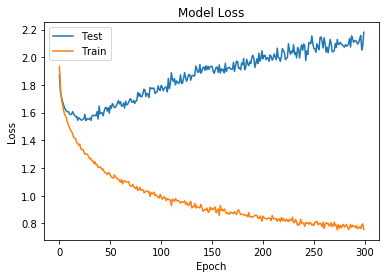

[2.1803418727148145, 0.4047619046483721] ['loss', 'categorical_accuracy']
543.7114285714285


In [171]:
dec = np.logspace(-6,0,10)[1]
mod = netFace(numEpochs=300,method=Adam(lr=0.001,decay=dec),szBatch=32)
print(EMC(mod))

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_268 (Dense)            (None, 100)               3800      
_________________________________________________________________
dropout_53 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_269 (Dense)            (None, 50)                5050      
_________________________________________________________________
dropout_54 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_270 (Dense)            (None, 40)                2040      
_________________________________________________________________
dropout_55 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_271 (Dense)            (None, 

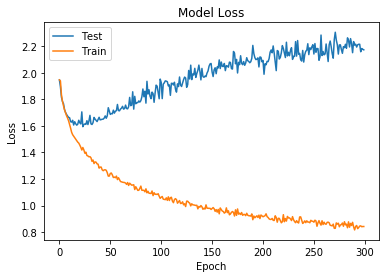

[2.1723466553006854, 0.3952380951245626] ['loss', 'categorical_accuracy']
549.4609523809523


In [169]:
dec = np.logspace(-6,0,10)[1]
mod = netFace(numEpochs=300,method=Adam(lr=0.001,decay=dec),szBatch=32)
print(EMC(mod))

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_252 (Dense)            (None, 50)                750       
_________________________________________________________________
dropout_41 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_253 (Dense)            (None, 50)                2550      
_________________________________________________________________
dropout_42 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_254 (Dense)            (None, 40)                2040      
_________________________________________________________________
dropout_43 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_255 (Dense)            (None, 

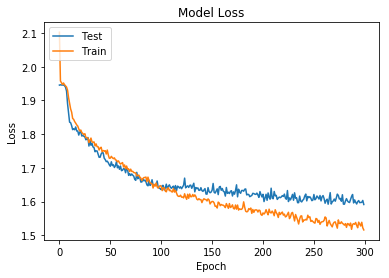

[1.5914381871904646, 0.3476190478461129] ['loss', 'categorical_accuracy']
702.9314285714286


In [162]:
dec = np.logspace(-6,0,10)[1]
mod = netFace(numEpochs=300,method=Adam(lr=0.001,decay=dec),szBatch=64)
print(EMC(mod))

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_228 (Dense)            (None, 50)                750       
_________________________________________________________________
dropout_26 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_229 (Dense)            (None, 50)                2550      
_________________________________________________________________
dropout_27 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_230 (Dense)            (None, 40)                2040      
_________________________________________________________________
dropout_28 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_231 (Dense)            (None, 

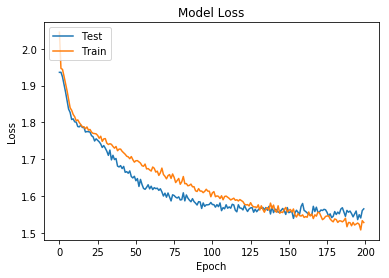

[1.5651438946951004, 0.379047619217918] ['loss', 'categorical_accuracy']
656.792380952381


In [158]:
dec = np.logspace(-6,0,10)[1]
mod = netFace(numEpochs=200,method=Adam(lr=0.001,decay=dec),szBatch=64)
print(EMC(mod))

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_175 (Dense)            (None, 15)                225       
_________________________________________________________________
dropout_19 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_176 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_177 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_178 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_179 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_180 (Dense)            (None, 

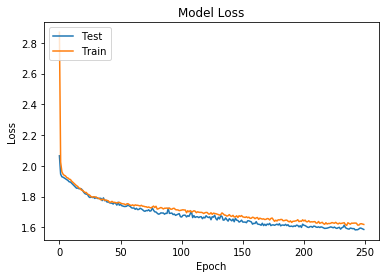

[1.586705990291777, 0.360000000170299] ['loss', 'categorical_accuracy']
678.615238095238


In [147]:
dec = np.logspace(-6,0,10)[1]
mod = netFace(numEpochs=250,method=Adam(lr=0.001,decay=dec),szBatch=128)
print(EMC(mod))

In [167]:
def EMC(mod):
    # MSE 
    mat_test = sio.loadmat("AgeGenderClassification/eventest.mat")   
    data_test= mat_test["tecoll"][0][0]

    x_test = data_test[3] #x_test = data_test[3]
    y_test = data_test[1]

    clas = [1,5,10,16,28,51,75]

    EMC = 0
    for fila_ind in range(x_test.shape[0]):
        index = int(mod.predict_classes(x_test[fila_ind,:].reshape(1,37), verbose=0))
        EMC = EMC + pow((clas[index]-int(y_test[fila_ind,:])),2)
    
    return(EMC/x_test.shape[0])

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_168 (Dense)            (None, 15)                225       
_________________________________________________________________
dropout_18 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_169 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_170 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_171 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_172 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_173 (Dense)            (None, 

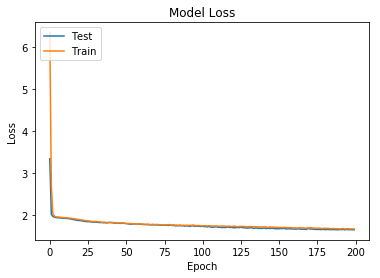

[1.6522281769343785, 0.3228571429706755] ['loss', 'categorical_accuracy']
749.6580952380953


In [146]:
dec = np.logspace(-6,0,10)[1]
mod = netFace(numEpochs=200,method=Adam(lr=0.001,decay=dec),szBatch=128)
print(EMC(mod))

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_163 (Dense)            (None, 15)                225       
_________________________________________________________________
dropout_17 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_164 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_165 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_166 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_167 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
______________________________________

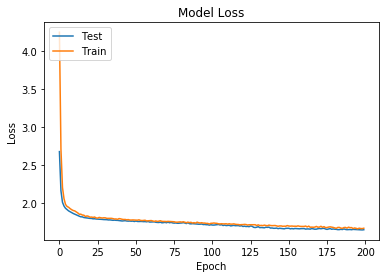

[1.6533423730305263, 0.32666666666666666] ['loss', 'categorical_accuracy']
730.2142857142857


In [144]:
dec = np.logspace(-6,0,10)[1]
mod = netFace(numEpochs=200,method=Adam(lr=0.001,decay=dec),szBatch=128)
print(EMC(mod))

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 15)                225       
_________________________________________________________________
dropout_3 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_109 (Dense)            (None, 15)                240       
_________________________________________________________________
dropout_4 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_110 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_111 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_112 (Dense)            (None, 

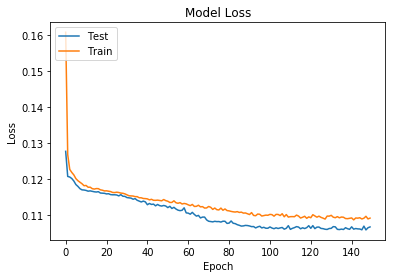

[0.10667452048687708, 0.333333333617165] ['loss', 'categorical_accuracy']


In [95]:
dec = np.logspace(-6,0,10)[1]
netFace(numEpochs=150,method=Adam(lr=0.001))

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 15)                225       
_________________________________________________________________
dropout_2 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_104 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_105 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_106 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_107 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
______________________________________

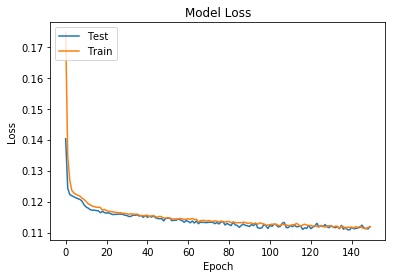

[0.11191405121769224, 0.29809523837906976] ['loss', 'categorical_accuracy']


In [93]:
dec = np.logspace(-6,0,10)[1]
netFace(numEpochs=150,method=Adam(lr=0.001))

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_98 (Dense)             (None, 15)                225       
_________________________________________________________________
dense_99 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_100 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_101 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_102 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


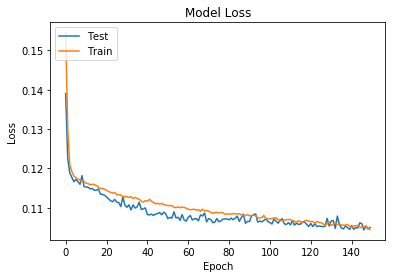

[0.10500009417533875, 0.360000000170299] ['loss', 'categorical_accuracy']


In [91]:
dec = np.logspace(-6,0,10)[1]
netFace(numEpochs=150,method=Adam(lr=0.001))

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 15)                225       
_________________________________________________________________
dropout_1 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_89 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_90 (Dense)             (None, 10)                160       
_________________________________________________________________
dense_91 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_92 (Dense)             (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
______________________________________

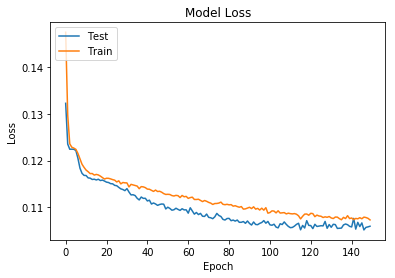

[0.10592905414955957, 0.3771428572563898] ['loss', 'categorical_accuracy']


In [88]:
dec = np.logspace(-6,0,10)[1]
netFace(numEpochs=150,method=Adam(lr=0.001))

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 15)                225       
_________________________________________________________________
dense_83 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_84 (Dense)             (None, 10)                160       
_________________________________________________________________
dense_85 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_86 (Dense)             (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


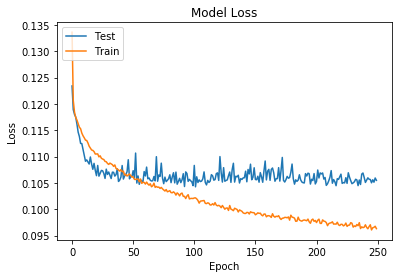

[0.10548403840689433, 0.39428571462631223] ['loss', 'categorical_accuracy']


In [61]:
dec = np.logspace(-6,0,10)[1]
netFace(numEpochs=250,method=Adam(lr=0.001,decay=dec),szBatch=10)

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 15)                225       
_________________________________________________________________
dense_72 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_73 (Dense)             (None, 10)                160       
_________________________________________________________________
dense_74 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_75 (Dense)             (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


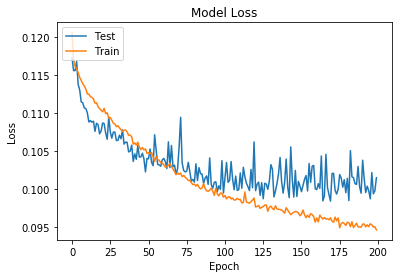

[0.10146475993451617, 0.4257142857142857] ['loss', 'categorical_accuracy']


In [56]:
dec = np.logspace(-6,0,10)[1]
netFace(numEpochs=200,method=Adam(lr=0.001,decay=dec),szBatch=10)

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 15)                225       
_________________________________________________________________
dense_17 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_18 (Dense)             (None, 10)                160       
_________________________________________________________________
dense_19 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_20 (Dense)             (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


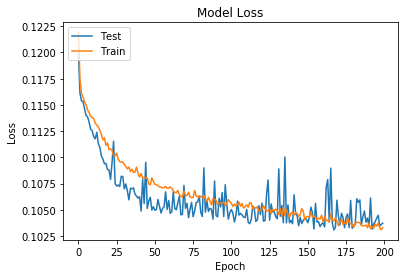

[0.10373611357950029, 0.3733333340145293] ['loss', 'categorical_accuracy']


In [15]:
dec = np.logspace(-6,0,10)[1]
netFace(numEpochs=200,method=Adam(lr=0.001,decay=dec),szBatch=10)

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 15)                225       
_________________________________________________________________
dense_7 (Dense)              (None, 15)                240       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


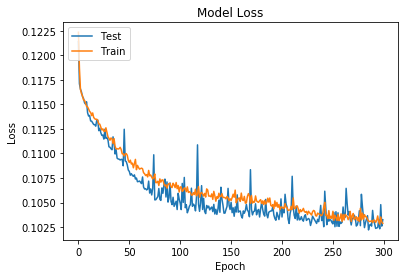

[0.10325900243861334, 0.3790476191043854] ['loss', 'categorical_accuracy']


In [13]:
dec = np.logspace(-6,0,10)[1]
netFace(numEpochs=300,method=Adam(lr=0.001,decay=dec))

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 15)                225       
_________________________________________________________________
dense_12 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_13 (Dense)             (None, 10)                160       
_________________________________________________________________
dense_14 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_15 (Dense)             (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


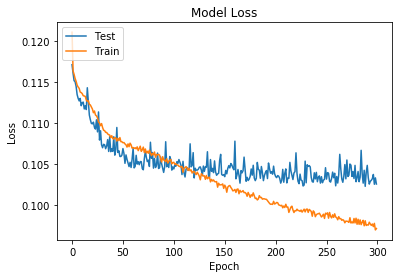

[0.10254337861424401, 0.40000000017029896] ['loss', 'categorical_accuracy']


In [14]:
dec = np.logspace(-6,0,10)[1]
netFace(numEpochs=300,method=Adam(lr=0.001,decay=dec),szBatch=10)

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_450 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_451 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_452 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_453 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_454 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


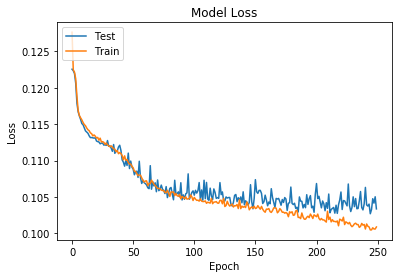

[0.10335109550328482, 0.3657142858278184] ['loss', 'categorical_accuracy']
(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_455 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_456 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_457 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_458 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_459 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


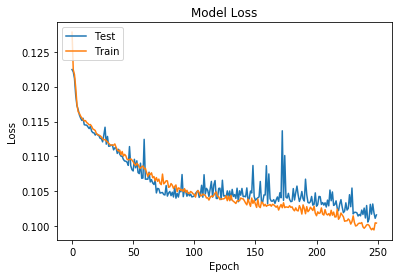

[0.10164172445024763, 0.41714285717124033] ['loss', 'categorical_accuracy']
(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_460 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_461 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_462 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_463 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_464 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


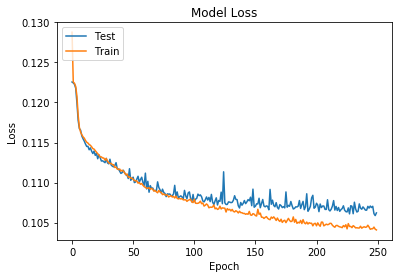

[0.10621494971570515, 0.33809523815200443] ['loss', 'categorical_accuracy']
(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_465 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_466 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_467 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_468 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_469 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


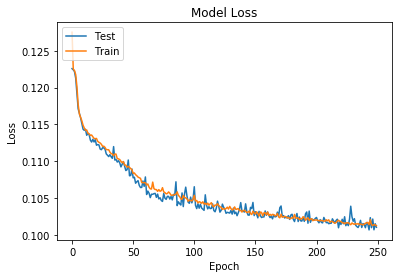

[0.10102363275630133, 0.3742857144560133] ['loss', 'categorical_accuracy']
(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_470 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_471 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_472 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_473 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_474 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


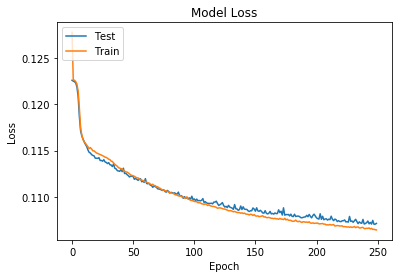

[0.10714243870405923, 0.3457142858845847] ['loss', 'categorical_accuracy']
(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_475 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_476 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_477 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_478 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_479 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


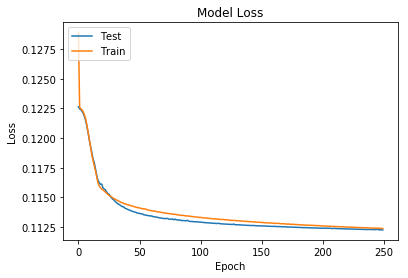

[0.11225466848838897, 0.28190476201829456] ['loss', 'categorical_accuracy']
(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_480 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_481 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_482 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_483 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_484 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


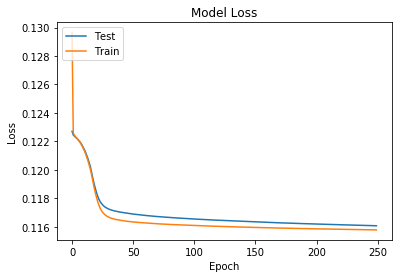

[0.11606732012260527, 0.23142857142857143] ['loss', 'categorical_accuracy']
(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_485 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_486 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_487 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_488 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_489 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


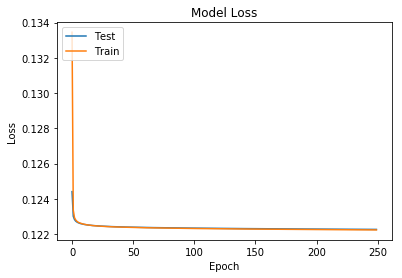

[0.12225857843955358, 0.1571428574266888] ['loss', 'categorical_accuracy']
(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_490 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_491 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_492 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_493 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_494 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


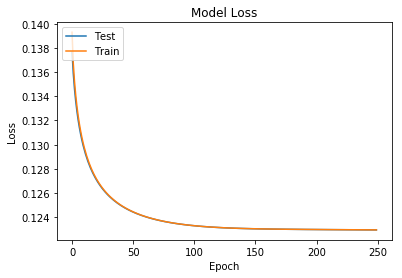

[0.12295298804839452, 0.14285714285714285] ['loss', 'categorical_accuracy']
(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_495 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_496 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_497 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_498 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_499 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


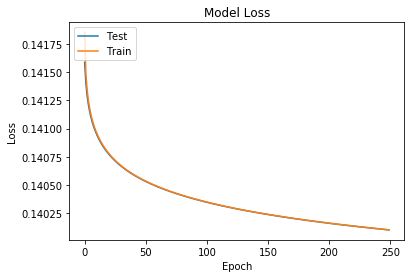

[0.14009883293083736, 0.14285714285714285] ['loss', 'categorical_accuracy']


In [224]:
for lear_decay in np.logspace(-6,0,10):
    netFace(numEpochs=250,method=Adam(lr=0.001,decay=lear_decay))

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_395 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_396 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_397 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_398 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_399 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


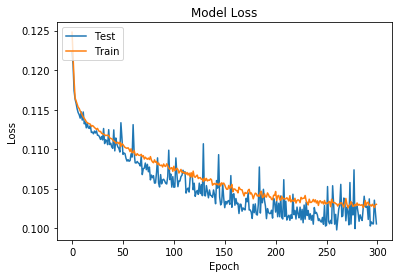

[0.10056593426636287, 0.41238095266478403] ['loss', 'categorical_accuracy']
(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_400 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_401 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_402 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_403 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_404 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


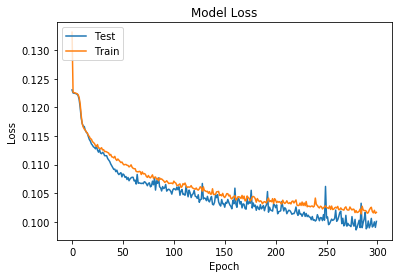

[0.10005437677814846, 0.4028571435383388] ['loss', 'categorical_accuracy']
(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_405 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_406 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_407 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_408 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_409 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


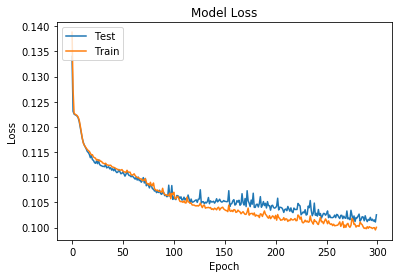

[0.10254185440994444, 0.38952380941027687] ['loss', 'categorical_accuracy']
(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_410 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_411 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_412 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_413 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_414 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


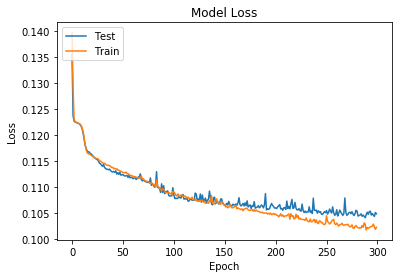

[0.10485749219145094, 0.37238095240933555] ['loss', 'categorical_accuracy']
(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_415 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_416 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_417 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_418 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_419 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


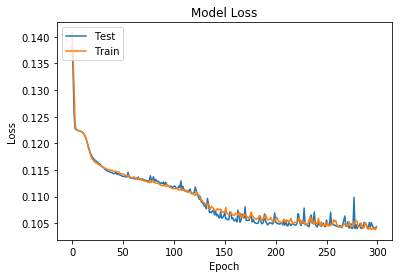

[0.10434497000206085, 0.34095238117944626] ['loss', 'categorical_accuracy']
(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_420 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_421 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_422 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_423 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_424 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


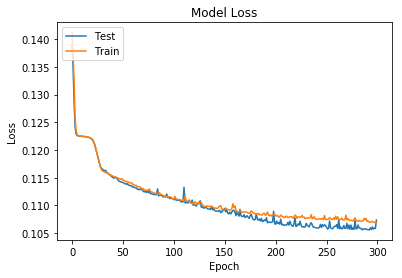

[0.10734169186580748, 0.32476190481867107] ['loss', 'categorical_accuracy']
(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_425 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_426 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_427 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_428 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_429 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


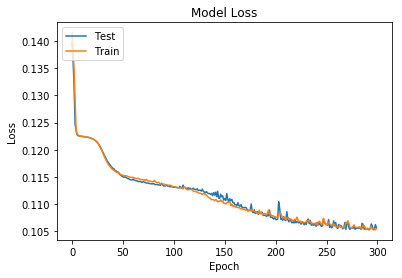

[0.10571610277607327, 0.3371428574834551] ['loss', 'categorical_accuracy']
(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_430 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_431 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_432 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_433 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_434 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


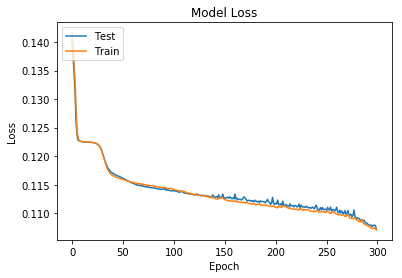

[0.10715419796251115, 0.326666666723433] ['loss', 'categorical_accuracy']
(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_435 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_436 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_437 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_438 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_439 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


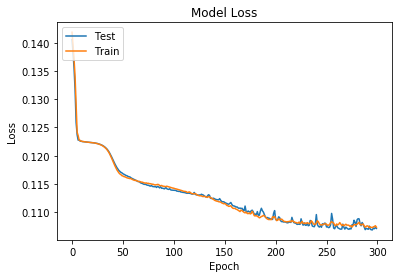

[0.10714365248169218, 0.32380952392305645] ['loss', 'categorical_accuracy']
(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_440 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_441 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_442 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_443 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_444 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


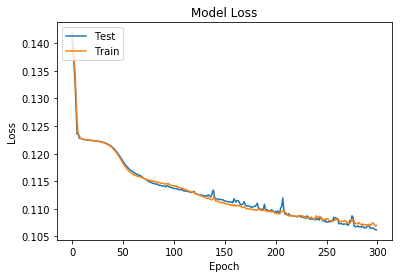

[0.10618127046596436, 0.3352380953516279] ['loss', 'categorical_accuracy']


In [221]:
for siz in np.linspace(10,500,10):
    netFace(numEpochs=300,method=Adam(lr=0.001),szBatch=int(siz))

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_375 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_376 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_377 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_378 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_379 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


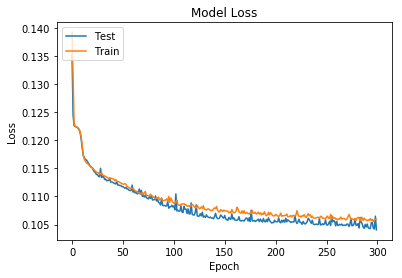

[0.10403593750227065, 0.35999999988646736] ['loss', 'categorical_accuracy']


In [217]:
netFace(numEpochs=300,method=Adam(lr=0.001),szBatch=128)

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_370 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_371 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_372 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_373 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_374 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


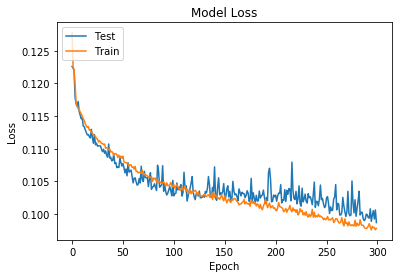

[0.09866868572575706, 0.41904761904761906] ['loss', 'categorical_accuracy']


In [216]:
netFace(numEpochs=300,method=Adam(lr=0.001))

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_360 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_361 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_362 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_363 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_364 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


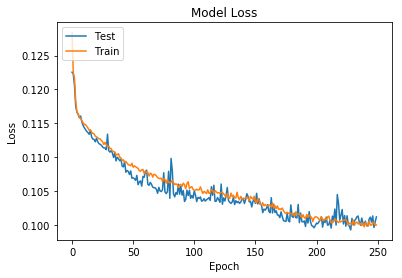

[0.10116615127949488, 0.4142857142857143] ['loss', 'categorical_accuracy']


In [214]:
netFace(numEpochs=250,method=Adam(lr=0.001))

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_340 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_341 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_342 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_343 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_344 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


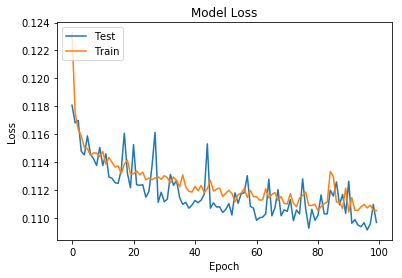

[0.10968126257260641, 0.3076190477893466] ['loss', 'categorical_accuracy']


In [210]:
netFace(numEpochs=100,method=Adam(lr=0.01))

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_330 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_331 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_332 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_333 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_334 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


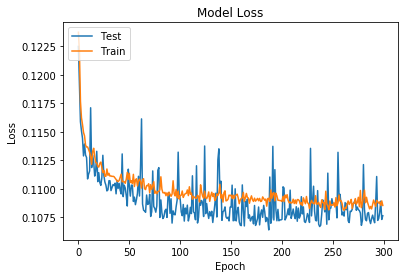

[0.10763651300044287, 0.31428571405864897] ['loss', 'categorical_accuracy']


In [208]:
netFace(numEpochs=300,method=Adam(lr=0.01))

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_325 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_326 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_327 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_328 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_329 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


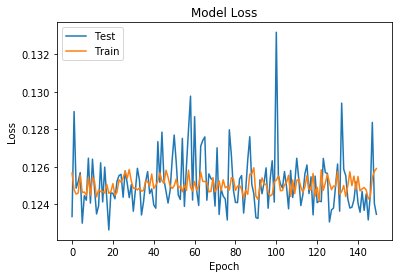

[0.12346386665389651, 0.14285714285714285] ['loss', 'categorical_accuracy']


In [207]:
netFace(numEpochs=150,method=Adam(lr=0.1))

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_355 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_356 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_357 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_358 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_359 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


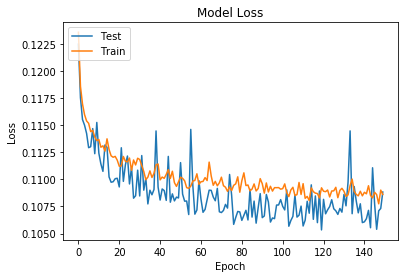

[0.10883338151943116, 0.32476190532956806] ['loss', 'categorical_accuracy']


In [213]:
netFace(numEpochs=150,method=Adam(lr=0.01))

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_315 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_316 (Dense)            (None, 15)                240       
_________________________________________________________________
dense_317 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_318 (Dense)            (None, 10)                110       
_________________________________________________________________
dense_319 (Dense)            (None, 7)                 77        
Total params: 812
Trainable params: 812
Non-trainable params: 0
_________________________________________________________________
None


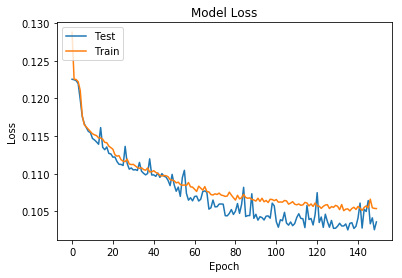

[0.10360920954318274, 0.3523809523809524] ['loss', 'categorical_accuracy']


In [205]:
netFace(numEpochs=150)

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_312 (Dense)            (None, 15)                225       
_________________________________________________________________
dense_313 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_314 (Dense)            (None, 7)                 77        
Total params: 462
Trainable params: 462
Non-trainable params: 0
_________________________________________________________________
None


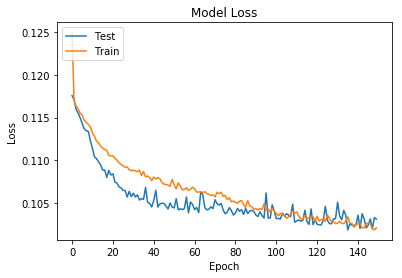

[0.10310155732291085, 0.3923809526080177] ['loss', 'categorical_accuracy']


In [203]:
netFace(numEpochs=150) #featFace

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_309 (Dense)            (None, 15)                9015      
_________________________________________________________________
dense_310 (Dense)            (None, 10)                160       
_________________________________________________________________
dense_311 (Dense)            (None, 7)                 77        
Total params: 9,252
Trainable params: 9,252
Non-trainable params: 0
_________________________________________________________________
None


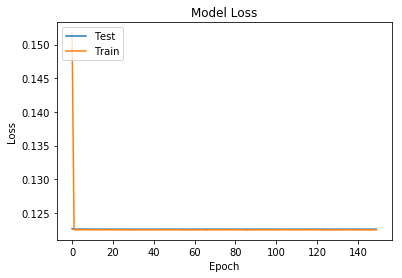

[0.1225843299286706, 0.14285714285714285] ['loss', 'categorical_accuracy']


In [201]:
netFace(numEpochs=150) # faceGist

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_271 (Dense)            (None, 30)                1140      
_________________________________________________________________
dense_272 (Dense)            (None, 20)                620       
_________________________________________________________________
dense_273 (Dense)            (None, 10)                210       
_________________________________________________________________
dense_274 (Dense)            (None, 7)                 77        
Total params: 2,047
Trainable params: 2,047
Non-trainable params: 0
_________________________________________________________________
None


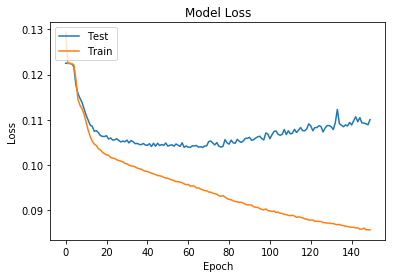

[0.11003023252600715, 0.36857142913909186] ['loss', 'categorical_accuracy']


In [185]:
netFace(numEpochs=150)

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_263 (Dense)            (None, 70)                2660      
_________________________________________________________________
dense_264 (Dense)            (None, 60)                4260      
_________________________________________________________________
dense_265 (Dense)            (None, 50)                3050      
_________________________________________________________________
dense_266 (Dense)            (None, 40)                2040      
_________________________________________________________________
dense_267 (Dense)            (None, 30)                1230      
_________________________________________________________________
dense_268 (Dense)            (None, 20)                620       
_________________________________________________________________
dense_269 (Dense)            (None, 

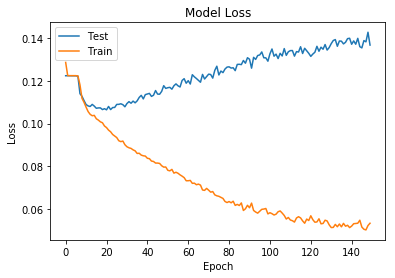

[0.13689202710276557, 0.35047619115738643] ['loss', 'categorical_accuracy']


In [183]:
netFace(numEpochs=150)

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_256 (Dense)            (None, 60)                2280      
_________________________________________________________________
dense_257 (Dense)            (None, 50)                3050      
_________________________________________________________________
dense_258 (Dense)            (None, 40)                2040      
_________________________________________________________________
dense_259 (Dense)            (None, 30)                1230      
_________________________________________________________________
dense_260 (Dense)            (None, 20)                620       
_________________________________________________________________
dense_261 (Dense)            (None, 10)                210       
_________________________________________________________________
dense_262 (Dense)            (None, 

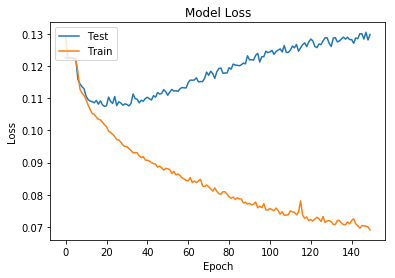

[0.12976538226717993, 0.34380952386629016] ['loss', 'categorical_accuracy']


In [180]:
netFace(numEpochs=150)

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_250 (Dense)            (None, 50)                1900      
_________________________________________________________________
dense_251 (Dense)            (None, 40)                2040      
_________________________________________________________________
dense_252 (Dense)            (None, 30)                1230      
_________________________________________________________________
dense_253 (Dense)            (None, 20)                620       
_________________________________________________________________
dense_254 (Dense)            (None, 10)                210       
_________________________________________________________________
dense_255 (Dense)            (None, 7)                 77        
Total params: 6,077
Trainable params: 6,077
Non-trainable params: 0
__________________________________

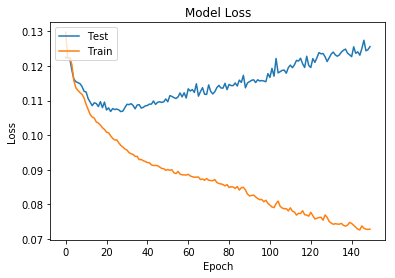

[0.12558972785870234, 0.34190476179122925] ['loss', 'categorical_accuracy']


In [177]:
netFace(numEpochs=150)

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_244 (Dense)            (None, 200)               7600      
_________________________________________________________________
dense_245 (Dense)            (None, 200)               40200     
_________________________________________________________________
dense_246 (Dense)            (None, 100)               20100     
_________________________________________________________________
dense_247 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_248 (Dense)            (None, 20)                2020      
_________________________________________________________________
dense_249 (Dense)            (None, 7)                 147       
Total params: 80,167
Trainable params: 80,167
Non-trainable params: 0
________________________________

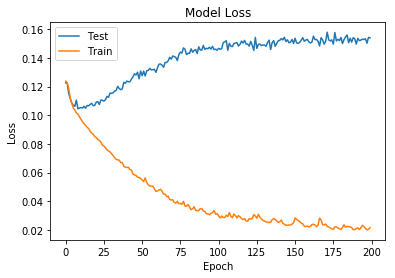

[0.15388513400441126, 0.3466666668369657] ['loss', 'categorical_accuracy']


In [174]:
netFace(numEpochs=200)

(3500, 1) (1050, 1)
(3500, 7) (1050, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_238 (Dense)            (None, 200)               7600      
_________________________________________________________________
dense_239 (Dense)            (None, 200)               40200     
_________________________________________________________________
dense_240 (Dense)            (None, 100)               20100     
_________________________________________________________________
dense_241 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_242 (Dense)            (None, 20)                2020      
_________________________________________________________________
dense_243 (Dense)            (None, 7)                 147       
Total params: 80,167
Trainable params: 80,167
Non-trainable params: 0
________________________________

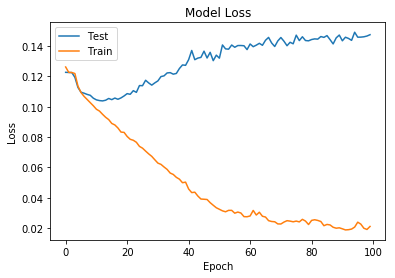

[0.14740434039206732, 0.3628571435383388] ['loss', 'categorical_accuracy']


In [173]:
netFace() # 100 epoch

(3500, 1) (1050, 1)
(3500, 76) (1050, 76)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_202 (Dense)            (None, 100)               3800      
_________________________________________________________________
dense_203 (Dense)            (None, 70)                7070      
_________________________________________________________________
dense_204 (Dense)            (None, 50)                3550      
_________________________________________________________________
dense_205 (Dense)            (None, 30)                1530      
_________________________________________________________________
dense_206 (Dense)            (None, 10)                310       
_________________________________________________________________
dense_207 (Dense)            (None, 76)                836       
Total params: 17,096
Trainable params: 17,096
Non-trainable params: 0
______________________________

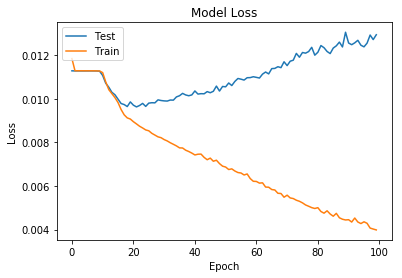

[0.012939867031361376, 0.3628571428571429] ['loss', 'categorical_accuracy']


In [156]:
netFace() # With matrix 76

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_160 (Dense)            (None, 100)               3800      
_________________________________________________________________
dense_161 (Dense)            (None, 70)                7070      
_________________________________________________________________
dense_162 (Dense)            (None, 50)                3550      
_________________________________________________________________
dense_163 (Dense)            (None, 30)                1530      
_________________________________________________________________
dense_164 (Dense)            (None, 10)                310       
_________________________________________________________________
dense_165 (Dense)            (None, 7)                 77        
Total params: 16,337
Trainable params: 16,337
Non-trainable params: 0
_________________________________________________________________
None


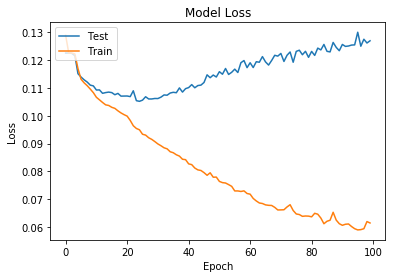

[0.126886943479379, 0.3600000005676633] ['loss', 'categorical_accuracy']


In [142]:
netFace() # Last Activation linear, method Adam

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_166 (Dense)            (None, 100)               3800      
_________________________________________________________________
dense_167 (Dense)            (None, 70)                7070      
_________________________________________________________________
dense_168 (Dense)            (None, 50)                3550      
_________________________________________________________________
dense_169 (Dense)            (None, 30)                1530      
_________________________________________________________________
dense_170 (Dense)            (None, 10)                310       
_________________________________________________________________
dense_171 (Dense)            (None, 7)                 77        
Total params: 16,337
Trainable params: 16,337
Non-trainable params: 0
_________________________________________________________________
None


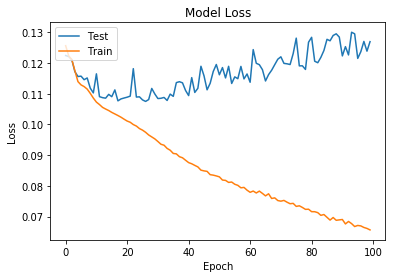

[0.12694192548592886, 0.3685714286281949] ['loss', 'categorical_accuracy']


In [143]:
netFace(method=RMSprop(lr=0.001)) # Last activation linear, method RMSprop

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_172 (Dense)            (None, 100)               3800      
_________________________________________________________________
dense_173 (Dense)            (None, 70)                7070      
_________________________________________________________________
dense_174 (Dense)            (None, 50)                3550      
_________________________________________________________________
dense_175 (Dense)            (None, 30)                1530      
_________________________________________________________________
dense_176 (Dense)            (None, 10)                310       
_________________________________________________________________
dense_177 (Dense)            (None, 7)                 77        
Total params: 16,337
Trainable params: 16,337
Non-trainable params: 0
_________________________________________________________________
None


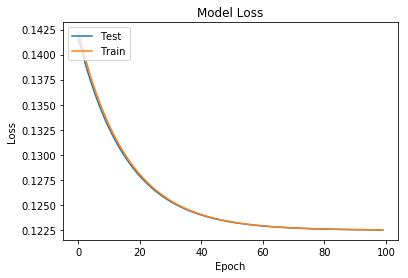

[0.12248509659653618, 0.14285714285714285] ['loss', 'categorical_accuracy']


In [144]:
netFace(method=SGD(lr=0.001)) # Last activation linear, method SGD

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_130 (Dense)            (None, 100)               3800      
_________________________________________________________________
dense_131 (Dense)            (None, 70)                7070      
_________________________________________________________________
dense_132 (Dense)            (None, 50)                3550      
_________________________________________________________________
dense_133 (Dense)            (None, 30)                1530      
_________________________________________________________________
dense_134 (Dense)            (None, 10)                310       
_________________________________________________________________
dense_135 (Dense)            (None, 7)                 77        
Total params: 16,337
Trainable params: 16,337
Non-trainable params: 0
_________________________________________________________________
None


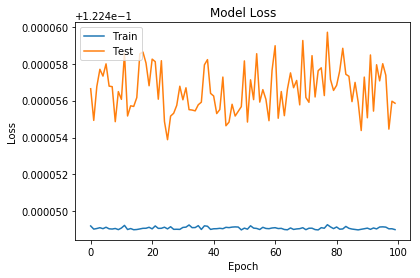

[0.12244901489643824, 0.14285714285714285] ['loss', 'categorical_accuracy']


In [134]:
netFace() # Last Activation softmax

<a id="refs"></a>
## Referencias
[1] Glorot, X., & Bengio, Y. (2010, March). *Understanding the difficulty of training deep feedforward neural networks*. In Proceedings of the thirteenth international conference on artificial intelligence and statistics (pp. 249-256).    
[2]  He, K., Zhang, X., Ren, S., & Sun, J. (2015). *Delving deep into rectifiers: Surpassing human-level performance on imagenet classification*. In Proceedings of the IEEE international conference on computer vision (pp. 1026-1034).  
[3] Gallagher, A. C., & Chen, T. (2009, June). *Understanding images of groups of people*. In Computer Vision and Pattern Recognition, 2009. CVPR 2009. IEEE Conference on (pp. 256-263). IEEE.